In [21]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [22]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization, Bidirectional, LSTM, concatenate, Flatten
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [23]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [24]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [25]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [26]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.9)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [27]:
def mean_squared_error(X, lenght = 5):
    squared_error = 0
    for i in range(0, X.shape[0] - lenght):
        x = X[i:i+lenght]
        mean = x.mean()
        std = x.std()
        x = (x - mean)/std
        y = (X[i+lenght] - mean)/std
        squared_error += np.square(x[-1]-y)
    return squared_error/X.shape[0]

In [28]:
# For generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [29]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [30]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [31]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    
    # Define the first Densely Connected Bidirectional LSTM layer
    lstm_1 = Bidirectional(LSTM(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal', dropout=0.3))(inputs)
    lstm_1_batch_norm = BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(lstm_1_batch_norm)
    lstm_1_dropout = Dropout(0.3)(lstm_1_LRelu)
    
    # Define the second Densely Connected Bidirectional LSTM layer
    lstm_2_input = concatenate([lstm_1, inputs], axis=2)
    lstm_2 = Bidirectional(LSTM(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal', dropout=0.3))(lstm_2_input)
    lstm_2_batch_norm = BatchNormalization()(lstm_2)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(lstm_2_batch_norm)
    lstm_2_dropout = Dropout(0.3)(lstm_2_LRelu)
    
    # Define the output layer
    output_dense = Dense(n_features, activation=None)(lstm_2_dropout)
    output = LeakyReLU(alpha=0.3)(output_dense)
    
    # Define the model
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()
    
    return model

## Discriminator

In [32]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [33]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [34]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
#         if(cur_gen_loss > 0.85):
#                 break;
    return history, history_val

## Visualization

In [35]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [36]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [37]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [38]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [39]:
stock_code = "AMZN"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2000-01-10    3.628125    3.631250    3.278125    3.459375    3.459375   
6    2000-01-11    3.343750    3.500000    3.250000    3.337500    3.337500   
7    2000-01-12    3.393750    3.400000    3.150000    3.178125    3.178125   
8    2000-01-13    3.246875    3.359375    3.156250    3.296875    3.296875   
9    2000-01-14    3.337500    3.431250    3.200000    3.212500    3.212500   
...         ...         ...         ...         ...         ...         ...   
5278 2020-12-23  160.250000  160.506500  159.208496  159.263504  159.263504   
5279 2020-12-24  159.695007  160.100006  158.449997  158.634506  158.634506   
5280 2020-12-28  159.699997  165.199997  158.634506  164.197998  164.197998   
5281 2020-12-29  165.496994  167.532501  164.061005  166.100006  166.100006   
5282 2020-12-30  167.050003  167.104996  164.123505  164.292496  164.292496   

         Volume          Ma  
5     295158000    3.761875  
6     210654000    3.560000  
7     216090000    3.408125  
8     208962000    3.346250  
9     137072000    3.350000  
...         ...         ...  
5278   41876000  160.913904  
5279   29038000  160.357004  
5280  113736000  159.723105  
5281   97458000  160.546204  
5282   64186000  161.704404  

[5278 rows x 8 columns]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 5, 20)        1440        ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 5, 27)        0           ['bidirectional[0][0]',          
                                                                  'input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20)          3040        ['concatenate[0][0]']        

Time for epoch 48 is 0.8842556476593018 sec Generator Loss: 0.8788326382637024,  Discriminator_loss: 1.3041443824768066
Time for epoch 49 is 0.9098432064056396 sec Generator Loss: 0.8960652351379395,  Discriminator_loss: 1.3036093711853027
Time for epoch 50 is 0.8732059001922607 sec Generator Loss: 0.8984029293060303,  Discriminator_loss: 1.2966711521148682
Time for epoch 51 is 0.8715803623199463 sec Generator Loss: 0.878173291683197,  Discriminator_loss: 1.3078035116195679
Time for epoch 52 is 0.874683141708374 sec Generator Loss: 0.8788169026374817,  Discriminator_loss: 1.3050144910812378
Time for epoch 53 is 0.8869485855102539 sec Generator Loss: 0.8706563115119934,  Discriminator_loss: 1.3121354579925537
Time for epoch 54 is 0.8938064575195312 sec Generator Loss: 0.8667164444923401,  Discriminator_loss: 1.3134819269180298
Time for epoch 55 is 0.8771340847015381 sec Generator Loss: 0.8779050707817078,  Discriminator_loss: 1.3133058547973633
Time for epoch 56 is 0.8858113288879395 se

Time for epoch 117 is 0.8736629486083984 sec Generator Loss: 0.8510939478874207,  Discriminator_loss: 1.3217209577560425
Time for epoch 118 is 0.8711607456207275 sec Generator Loss: 0.8252085447311401,  Discriminator_loss: 1.337453842163086
Time for epoch 119 is 0.8736987113952637 sec Generator Loss: 0.8714354038238525,  Discriminator_loss: 1.3245502710342407
Time for epoch 120 is 0.8709828853607178 sec Generator Loss: 0.8227435350418091,  Discriminator_loss: 1.3405401706695557
Time for epoch 121 is 0.8793256282806396 sec Generator Loss: 0.8466148972511292,  Discriminator_loss: 1.3290834426879883
Time for epoch 122 is 0.876659631729126 sec Generator Loss: 0.8373803496360779,  Discriminator_loss: 1.338332176208496
Time for epoch 123 is 0.8682491779327393 sec Generator Loss: 0.8414705991744995,  Discriminator_loss: 1.3294121026992798
Time for epoch 124 is 0.8716850280761719 sec Generator Loss: 0.8252722024917603,  Discriminator_loss: 1.3355439901351929
Time for epoch 125 is 0.89550662040

Time for epoch 186 is 0.9167308807373047 sec Generator Loss: 0.816429853439331,  Discriminator_loss: 1.3367931842803955
Time for epoch 187 is 0.9265367984771729 sec Generator Loss: 0.832574188709259,  Discriminator_loss: 1.3429697751998901
Time for epoch 188 is 0.9173049926757812 sec Generator Loss: 0.8140043616294861,  Discriminator_loss: 1.338107705116272
Time for epoch 189 is 0.9182009696960449 sec Generator Loss: 0.8215909600257874,  Discriminator_loss: 1.3415186405181885
Time for epoch 190 is 0.8927264213562012 sec Generator Loss: 0.8251023888587952,  Discriminator_loss: 1.3434898853302002
Time for epoch 191 is 0.9041166305541992 sec Generator Loss: 0.8318578600883484,  Discriminator_loss: 1.3482027053833008
Time for epoch 192 is 0.8717455863952637 sec Generator Loss: 0.8437194228172302,  Discriminator_loss: 1.3346279859542847
Time for epoch 193 is 0.868868350982666 sec Generator Loss: 0.8202555775642395,  Discriminator_loss: 1.3382776975631714
Time for epoch 194 is 0.901890516281

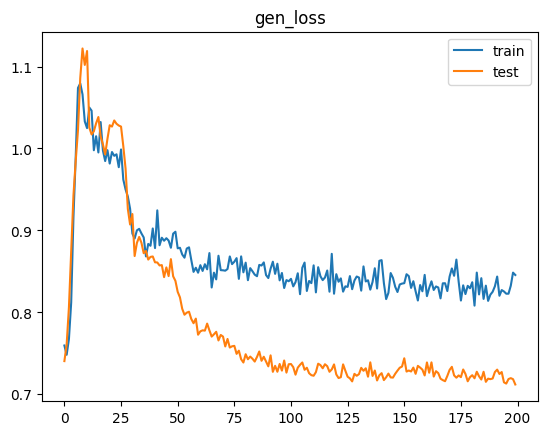

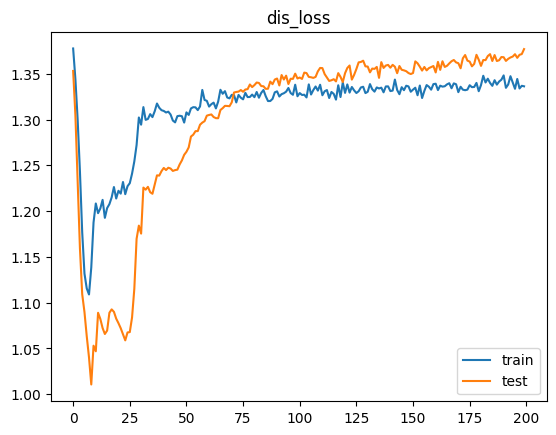

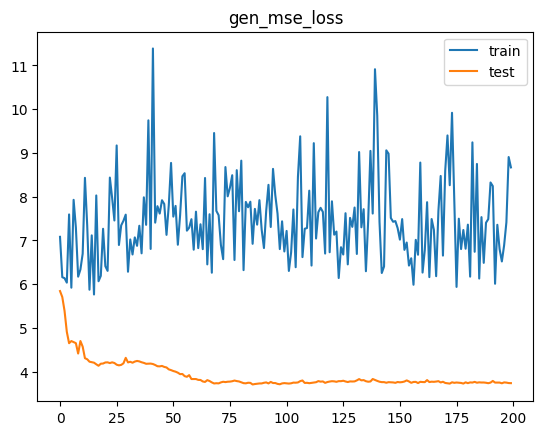

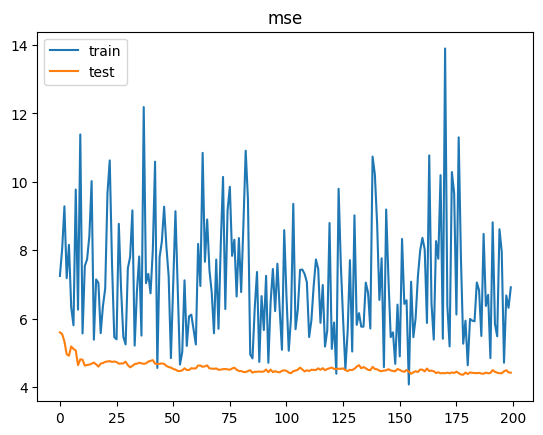

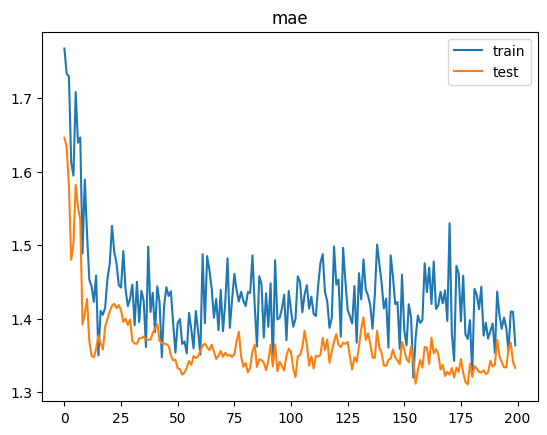

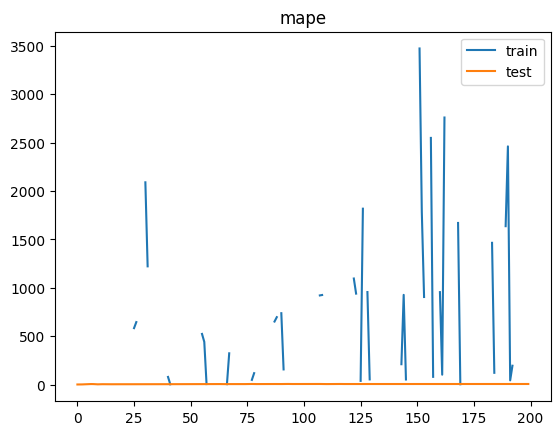

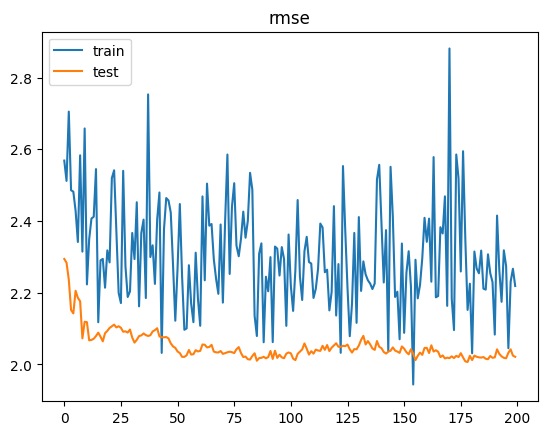

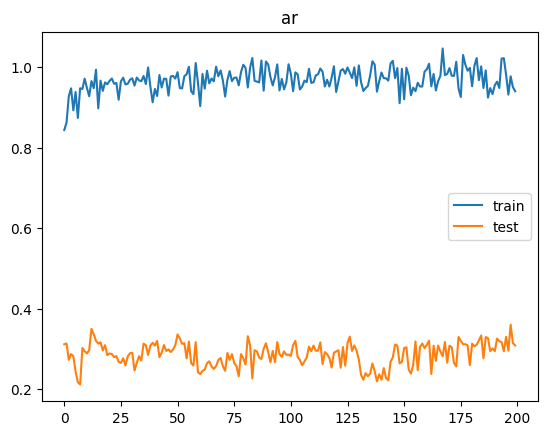

2/2 [==============================] - 1s 3ms/step


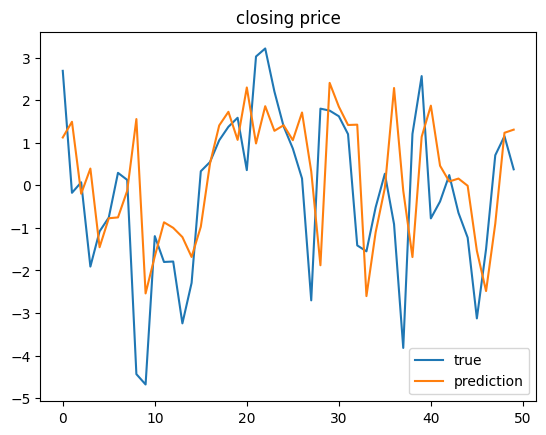

[MSE Baseline] train: 6.950788373372936  test: 4.137918162168212
Delta time with epochs = 200: 0:03:13.080288
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 5, 20)       1440        ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 5, 27)        0           ['bidirectional_2[0][0]',        
                                                                  'input_2[0][0]'

Time for epoch 46 is 0.9027962684631348 sec Generator Loss: 0.8782108426094055,  Discriminator_loss: 1.3005125522613525
Time for epoch 47 is 0.8967888355255127 sec Generator Loss: 0.8777329325675964,  Discriminator_loss: 1.3016961812973022
Time for epoch 48 is 0.9047274589538574 sec Generator Loss: 0.8690486550331116,  Discriminator_loss: 1.310043215751648
Time for epoch 49 is 0.8940563201904297 sec Generator Loss: 0.8588828444480896,  Discriminator_loss: 1.309072494506836
Time for epoch 50 is 0.900043249130249 sec Generator Loss: 0.8998468518257141,  Discriminator_loss: 1.3051837682724
Time for epoch 51 is 0.919187068939209 sec Generator Loss: 0.879071831703186,  Discriminator_loss: 1.3210774660110474
Time for epoch 52 is 0.944598913192749 sec Generator Loss: 0.8542975783348083,  Discriminator_loss: 1.3262276649475098
Time for epoch 53 is 0.9482591152191162 sec Generator Loss: 0.857015073299408,  Discriminator_loss: 1.315785527229309
Time for epoch 54 is 0.940662145614624 sec Generato

Time for epoch 115 is 0.9154243469238281 sec Generator Loss: 0.8322053551673889,  Discriminator_loss: 1.3305330276489258
Time for epoch 116 is 0.9028923511505127 sec Generator Loss: 0.8158619403839111,  Discriminator_loss: 1.3314480781555176
Time for epoch 117 is 0.8822896480560303 sec Generator Loss: 0.8330517411231995,  Discriminator_loss: 1.3330451250076294
Time for epoch 118 is 0.9242095947265625 sec Generator Loss: 0.8335680365562439,  Discriminator_loss: 1.3319480419158936
Time for epoch 119 is 0.8944065570831299 sec Generator Loss: 0.835630476474762,  Discriminator_loss: 1.3305375576019287
Time for epoch 120 is 0.8868381977081299 sec Generator Loss: 0.8206288814544678,  Discriminator_loss: 1.329249382019043
Time for epoch 121 is 0.8804962635040283 sec Generator Loss: 0.8381795287132263,  Discriminator_loss: 1.330115556716919
Time for epoch 122 is 0.9059431552886963 sec Generator Loss: 0.8312987089157104,  Discriminator_loss: 1.3371026515960693
Time for epoch 123 is 1.04231023788

Time for epoch 183 is 0.998957633972168 sec Generator Loss: 0.8351287245750427,  Discriminator_loss: 1.3386907577514648
Time for epoch 184 is 1.071504831314087 sec Generator Loss: 0.8138667941093445,  Discriminator_loss: 1.3350623846054077
Time for epoch 185 is 1.112398386001587 sec Generator Loss: 0.8417790532112122,  Discriminator_loss: 1.3277819156646729
Time for epoch 186 is 1.0266315937042236 sec Generator Loss: 0.8114620447158813,  Discriminator_loss: 1.343554973602295
Time for epoch 187 is 0.9991979598999023 sec Generator Loss: 0.815315306186676,  Discriminator_loss: 1.3371665477752686
Time for epoch 188 is 1.0309326648712158 sec Generator Loss: 0.8167840838432312,  Discriminator_loss: 1.3413827419281006
Time for epoch 189 is 0.9936151504516602 sec Generator Loss: 0.822649359703064,  Discriminator_loss: 1.3347067832946777
Time for epoch 190 is 1.0102214813232422 sec Generator Loss: 0.8259751200675964,  Discriminator_loss: 1.329249382019043
Time for epoch 191 is 1.006316423416137

Time for epoch 252 is 0.9618899822235107 sec Generator Loss: 0.8282154202461243,  Discriminator_loss: 1.333317518234253
Time for epoch 253 is 0.9581060409545898 sec Generator Loss: 0.8144163489341736,  Discriminator_loss: 1.3351943492889404
Time for epoch 254 is 0.9632940292358398 sec Generator Loss: 0.8216402530670166,  Discriminator_loss: 1.3340318202972412
Time for epoch 255 is 0.9436004161834717 sec Generator Loss: 0.8231784105300903,  Discriminator_loss: 1.3286935091018677
Time for epoch 256 is 0.9607429504394531 sec Generator Loss: 0.8321104645729065,  Discriminator_loss: 1.3315361738204956
Time for epoch 257 is 0.9342398643493652 sec Generator Loss: 0.8268375396728516,  Discriminator_loss: 1.3403114080429077
Time for epoch 258 is 0.9160006046295166 sec Generator Loss: 0.8121817708015442,  Discriminator_loss: 1.3380581140518188
Time for epoch 259 is 0.9523577690124512 sec Generator Loss: 0.8079463243484497,  Discriminator_loss: 1.3413469791412354
Time for epoch 260 is 1.019451141

Time for epoch 320 is 1.0330214500427246 sec Generator Loss: 0.8303735852241516,  Discriminator_loss: 1.3271818161010742
Time for epoch 321 is 0.9998867511749268 sec Generator Loss: 0.8361190557479858,  Discriminator_loss: 1.3251750469207764
Time for epoch 322 is 1.002216100692749 sec Generator Loss: 0.8300415873527527,  Discriminator_loss: 1.3302794694900513
Time for epoch 323 is 1.0071418285369873 sec Generator Loss: 0.844987154006958,  Discriminator_loss: 1.334520936012268
Time for epoch 324 is 0.9627749919891357 sec Generator Loss: 0.8230714201927185,  Discriminator_loss: 1.329761266708374
Time for epoch 325 is 0.9515225887298584 sec Generator Loss: 0.8447538614273071,  Discriminator_loss: 1.3197423219680786
Time for epoch 326 is 0.9838156700134277 sec Generator Loss: 0.8324762582778931,  Discriminator_loss: 1.3253060579299927
Time for epoch 327 is 0.9836628437042236 sec Generator Loss: 0.8243054151535034,  Discriminator_loss: 1.3236567974090576
Time for epoch 328 is 0.966740369796

Time for epoch 388 is 1.0543878078460693 sec Generator Loss: 0.8573616147041321,  Discriminator_loss: 1.3180575370788574
Time for epoch 389 is 0.9918110370635986 sec Generator Loss: 0.854061484336853,  Discriminator_loss: 1.3113682270050049
Time for epoch 390 is 1.0556206703186035 sec Generator Loss: 0.8493958115577698,  Discriminator_loss: 1.319358229637146
Time for epoch 391 is 0.9891700744628906 sec Generator Loss: 0.8449556827545166,  Discriminator_loss: 1.3177540302276611
Time for epoch 392 is 1.0642693042755127 sec Generator Loss: 0.8518061637878418,  Discriminator_loss: 1.3151658773422241
Time for epoch 393 is 0.9964909553527832 sec Generator Loss: 0.8500136733055115,  Discriminator_loss: 1.3125873804092407
Time for epoch 394 is 1.0258381366729736 sec Generator Loss: 0.8622811436653137,  Discriminator_loss: 1.3212779760360718
Time for epoch 395 is 1.0139951705932617 sec Generator Loss: 0.852169394493103,  Discriminator_loss: 1.3202732801437378
Time for epoch 396 is 0.95100641250

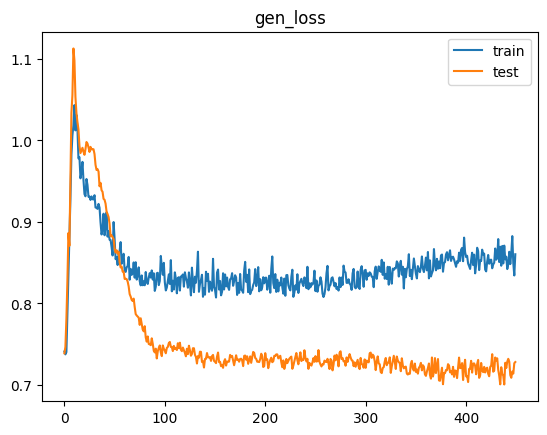

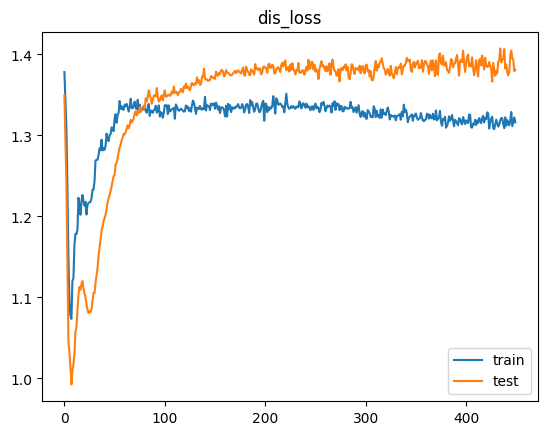

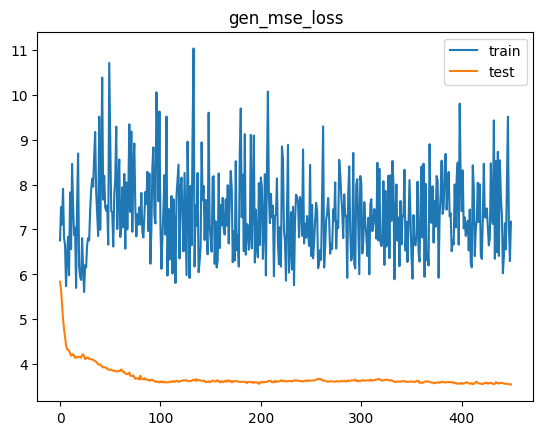

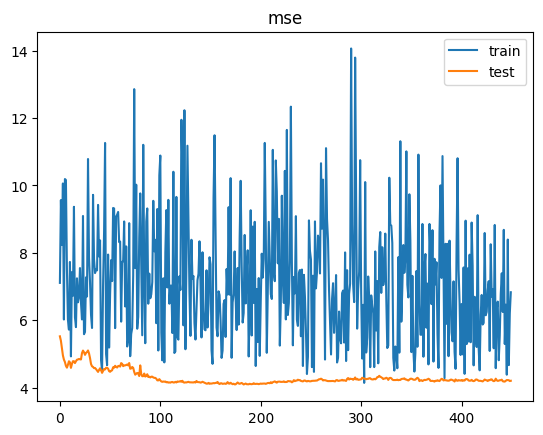

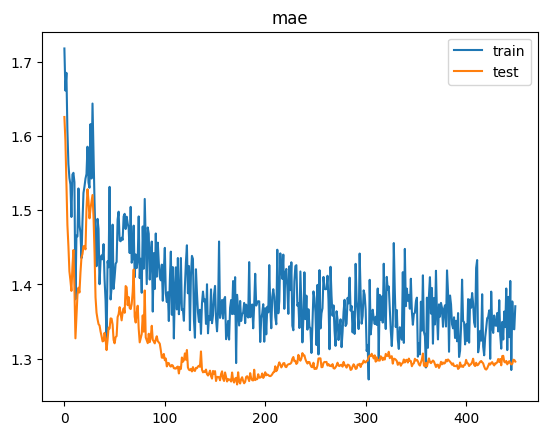

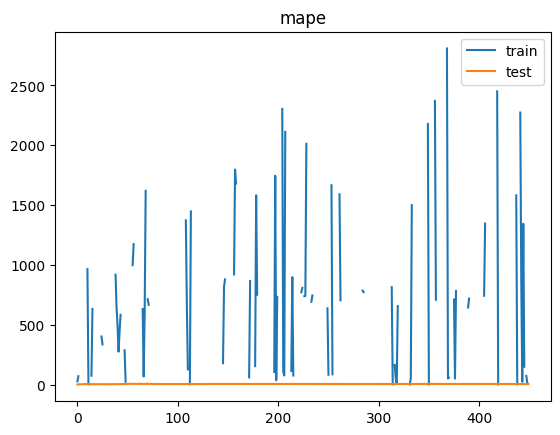

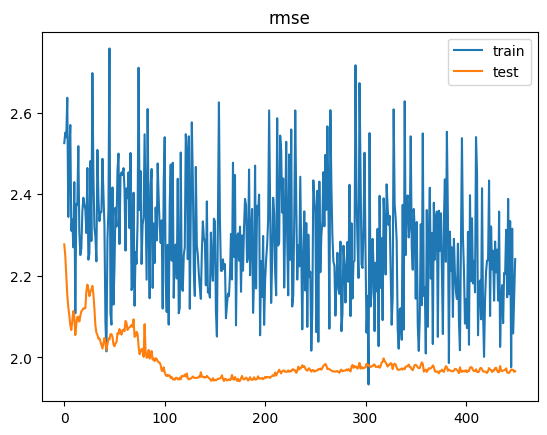

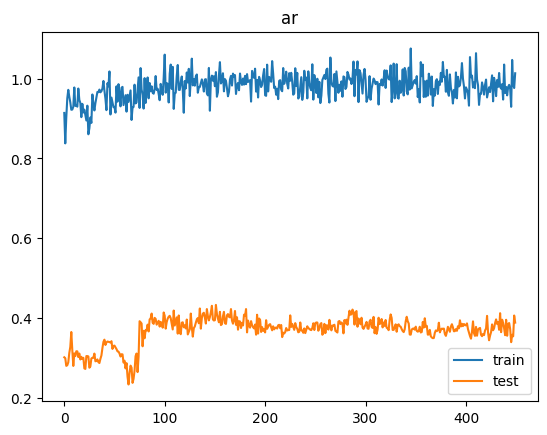

2/2 [==============================] - 1s 3ms/step


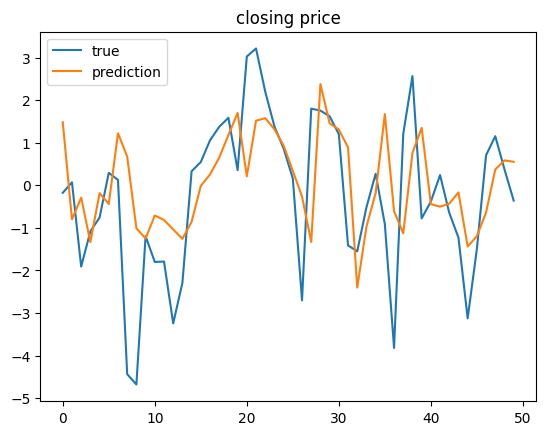

[MSE Baseline] train: 6.253122712757188  test: 4.1521541466081695
Delta time with epochs = 450: 0:07:20.739428
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 5, 20)       1440        ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 5, 27)        0           ['bidirectional_4[0][0]',        
                                                                  'input_3[0][0]

Time for epoch 46 is 0.9237480163574219 sec Generator Loss: 0.8783667683601379,  Discriminator_loss: 1.3191590309143066
Time for epoch 47 is 0.9261953830718994 sec Generator Loss: 0.8587169647216797,  Discriminator_loss: 1.3257060050964355
Time for epoch 48 is 0.9201428890228271 sec Generator Loss: 0.8661301136016846,  Discriminator_loss: 1.3256969451904297
Time for epoch 49 is 0.9297254085540771 sec Generator Loss: 0.8922979235649109,  Discriminator_loss: 1.3249255418777466
Time for epoch 50 is 0.9203217029571533 sec Generator Loss: 0.8526313304901123,  Discriminator_loss: 1.3349852561950684
Time for epoch 51 is 0.9277477264404297 sec Generator Loss: 0.8528764247894287,  Discriminator_loss: 1.3298859596252441
Time for epoch 52 is 0.9570622444152832 sec Generator Loss: 0.8601304888725281,  Discriminator_loss: 1.329400897026062
Time for epoch 53 is 0.912510871887207 sec Generator Loss: 0.8325363993644714,  Discriminator_loss: 1.332007884979248
Time for epoch 54 is 0.8984825611114502 sec

Time for epoch 115 is 0.8770287036895752 sec Generator Loss: 0.8131846785545349,  Discriminator_loss: 1.3432260751724243
Time for epoch 116 is 0.8985028266906738 sec Generator Loss: 0.8351784348487854,  Discriminator_loss: 1.343961477279663
Time for epoch 117 is 0.8868234157562256 sec Generator Loss: 0.8284237384796143,  Discriminator_loss: 1.3264635801315308
Time for epoch 118 is 0.9430630207061768 sec Generator Loss: 0.8511241674423218,  Discriminator_loss: 1.3272899389266968
Time for epoch 119 is 0.8817038536071777 sec Generator Loss: 0.8211960792541504,  Discriminator_loss: 1.3416171073913574
Time for epoch 120 is 0.875922679901123 sec Generator Loss: 0.8310233950614929,  Discriminator_loss: 1.3421019315719604
Time for epoch 121 is 1.0292229652404785 sec Generator Loss: 0.8176388740539551,  Discriminator_loss: 1.3348212242126465
Time for epoch 122 is 0.8974926471710205 sec Generator Loss: 0.8377981185913086,  Discriminator_loss: 1.33877694606781
Time for epoch 123 is 0.880407810211

Time for epoch 184 is 0.8845865726470947 sec Generator Loss: 0.8186656832695007,  Discriminator_loss: 1.3444032669067383
Time for epoch 185 is 0.875018835067749 sec Generator Loss: 0.8312599062919617,  Discriminator_loss: 1.3359087705612183
Time for epoch 186 is 0.8862142562866211 sec Generator Loss: 0.8179749846458435,  Discriminator_loss: 1.3460280895233154
Time for epoch 187 is 0.88690185546875 sec Generator Loss: 0.8389096260070801,  Discriminator_loss: 1.3418688774108887
Time for epoch 188 is 0.8794095516204834 sec Generator Loss: 0.8206484913825989,  Discriminator_loss: 1.3440293073654175
Time for epoch 189 is 0.877981424331665 sec Generator Loss: 0.8232740759849548,  Discriminator_loss: 1.3447825908660889
Time for epoch 190 is 0.8766670227050781 sec Generator Loss: 0.812877893447876,  Discriminator_loss: 1.3444342613220215
Time for epoch 191 is 0.8765864372253418 sec Generator Loss: 0.8158386945724487,  Discriminator_loss: 1.3403538465499878
Time for epoch 192 is 0.8724551200866

Time for epoch 252 is 0.8751327991485596 sec Generator Loss: 0.8090130686759949,  Discriminator_loss: 1.3343408107757568
Time for epoch 253 is 0.8779449462890625 sec Generator Loss: 0.8228904604911804,  Discriminator_loss: 1.334818959236145
Time for epoch 254 is 0.8909847736358643 sec Generator Loss: 0.8308731317520142,  Discriminator_loss: 1.337053656578064
Time for epoch 255 is 0.8760013580322266 sec Generator Loss: 0.833031177520752,  Discriminator_loss: 1.3388895988464355
Time for epoch 256 is 0.8751769065856934 sec Generator Loss: 0.829277753829956,  Discriminator_loss: 1.3363131284713745
Time for epoch 257 is 0.9043097496032715 sec Generator Loss: 0.8313385248184204,  Discriminator_loss: 1.3360223770141602
Time for epoch 258 is 0.8782346248626709 sec Generator Loss: 0.8277817368507385,  Discriminator_loss: 1.338947057723999
Time for epoch 259 is 0.8833978176116943 sec Generator Loss: 0.8315014243125916,  Discriminator_loss: 1.3405847549438477
Time for epoch 260 is 0.8770351409912

Time for epoch 321 is 0.8768086433410645 sec Generator Loss: 0.857428789138794,  Discriminator_loss: 1.3250384330749512
Time for epoch 322 is 0.8749072551727295 sec Generator Loss: 0.8282753229141235,  Discriminator_loss: 1.3295049667358398
Time for epoch 323 is 0.8737845420837402 sec Generator Loss: 0.8534591794013977,  Discriminator_loss: 1.3289237022399902
Time for epoch 324 is 0.8716530799865723 sec Generator Loss: 0.8341864943504333,  Discriminator_loss: 1.3343569040298462
Time for epoch 325 is 0.8843371868133545 sec Generator Loss: 0.8527764678001404,  Discriminator_loss: 1.3240731954574585
Time for epoch 326 is 0.878662109375 sec Generator Loss: 0.8354363441467285,  Discriminator_loss: 1.3362383842468262
Time for epoch 327 is 0.8741419315338135 sec Generator Loss: 0.8260524868965149,  Discriminator_loss: 1.3304940462112427
Time for epoch 328 is 0.8715837001800537 sec Generator Loss: 0.8413577079772949,  Discriminator_loss: 1.3228185176849365
Time for epoch 329 is 0.8706991672515

Time for epoch 390 is 0.8701133728027344 sec Generator Loss: 0.8684576749801636,  Discriminator_loss: 1.3112497329711914
Time for epoch 391 is 0.909454345703125 sec Generator Loss: 0.8698874115943909,  Discriminator_loss: 1.3186230659484863
Time for epoch 392 is 0.8767023086547852 sec Generator Loss: 0.8432462215423584,  Discriminator_loss: 1.3150279521942139
Time for epoch 393 is 0.8842439651489258 sec Generator Loss: 0.8613812327384949,  Discriminator_loss: 1.3169560432434082
Time for epoch 394 is 0.8688623905181885 sec Generator Loss: 0.8517357707023621,  Discriminator_loss: 1.3204668760299683
Time for epoch 395 is 0.8729889392852783 sec Generator Loss: 0.8781471848487854,  Discriminator_loss: 1.317152500152588
Time for epoch 396 is 0.8739778995513916 sec Generator Loss: 0.8625763058662415,  Discriminator_loss: 1.3138058185577393
Time for epoch 397 is 0.8707172870635986 sec Generator Loss: 0.8645304441452026,  Discriminator_loss: 1.3236956596374512
Time for epoch 398 is 0.8782031536

Time for epoch 458 is 0.8741915225982666 sec Generator Loss: 0.8529583811759949,  Discriminator_loss: 1.321189045906067
Time for epoch 459 is 0.9225020408630371 sec Generator Loss: 0.8771499395370483,  Discriminator_loss: 1.3128063678741455
Time for epoch 460 is 0.922579288482666 sec Generator Loss: 0.8589240908622742,  Discriminator_loss: 1.324803352355957
Time for epoch 461 is 0.9161322116851807 sec Generator Loss: 0.853701651096344,  Discriminator_loss: 1.317249059677124
Time for epoch 462 is 0.9043319225311279 sec Generator Loss: 0.8660547137260437,  Discriminator_loss: 1.3176183700561523
Time for epoch 463 is 0.8828117847442627 sec Generator Loss: 0.8543791770935059,  Discriminator_loss: 1.3218430280685425
Time for epoch 464 is 0.8733835220336914 sec Generator Loss: 0.8648924231529236,  Discriminator_loss: 1.314133644104004
Time for epoch 465 is 0.8738350868225098 sec Generator Loss: 0.864549458026886,  Discriminator_loss: 1.314577579498291
Time for epoch 466 is 0.880699872970581 

Time for epoch 527 is 0.9131624698638916 sec Generator Loss: 0.8712594509124756,  Discriminator_loss: 1.3186390399932861
Time for epoch 528 is 0.8906137943267822 sec Generator Loss: 0.8827643394470215,  Discriminator_loss: 1.310542345046997
Time for epoch 529 is 0.8830862045288086 sec Generator Loss: 0.8638432025909424,  Discriminator_loss: 1.3075714111328125
Time for epoch 530 is 0.880002498626709 sec Generator Loss: 0.8505363464355469,  Discriminator_loss: 1.3180012702941895
Time for epoch 531 is 0.8800432682037354 sec Generator Loss: 0.8767485618591309,  Discriminator_loss: 1.3128207921981812
Time for epoch 532 is 0.9048488140106201 sec Generator Loss: 0.8619800209999084,  Discriminator_loss: 1.311913251876831
Time for epoch 533 is 0.9281501770019531 sec Generator Loss: 0.8614641427993774,  Discriminator_loss: 1.3161306381225586
Time for epoch 534 is 0.909412145614624 sec Generator Loss: 0.8493556976318359,  Discriminator_loss: 1.3233147859573364
Time for epoch 535 is 0.875944614410

Time for epoch 595 is 0.8759589195251465 sec Generator Loss: 0.8618070483207703,  Discriminator_loss: 1.309330701828003
Time for epoch 596 is 0.8777005672454834 sec Generator Loss: 0.8790023326873779,  Discriminator_loss: 1.3161770105361938
Time for epoch 597 is 0.8797087669372559 sec Generator Loss: 0.8764611482620239,  Discriminator_loss: 1.3080507516860962
Time for epoch 598 is 0.8734848499298096 sec Generator Loss: 0.8867330551147461,  Discriminator_loss: 1.310074806213379
Time for epoch 599 is 0.872859001159668 sec Generator Loss: 0.8736072182655334,  Discriminator_loss: 1.3101612329483032
Time for epoch 600 is 0.881939172744751 sec Generator Loss: 0.8704130053520203,  Discriminator_loss: 1.3112603425979614
Time for epoch 601 is 0.8752787113189697 sec Generator Loss: 0.8723347783088684,  Discriminator_loss: 1.3152662515640259
Time for epoch 602 is 0.8752951622009277 sec Generator Loss: 0.8641276359558105,  Discriminator_loss: 1.3195490837097168
Time for epoch 603 is 0.885023117065

Time for epoch 663 is 0.8713018894195557 sec Generator Loss: 0.8693013191223145,  Discriminator_loss: 1.3063100576400757
Time for epoch 664 is 0.896679162979126 sec Generator Loss: 0.868524968624115,  Discriminator_loss: 1.314615249633789
Time for epoch 665 is 0.8946306705474854 sec Generator Loss: 0.8656695485115051,  Discriminator_loss: 1.3242722749710083
Time for epoch 666 is 0.8874664306640625 sec Generator Loss: 0.8764739632606506,  Discriminator_loss: 1.3046456575393677
Time for epoch 667 is 0.8906207084655762 sec Generator Loss: 0.8727333545684814,  Discriminator_loss: 1.3153156042099
Time for epoch 668 is 0.8836538791656494 sec Generator Loss: 0.8732434511184692,  Discriminator_loss: 1.310046911239624
Time for epoch 669 is 0.8897566795349121 sec Generator Loss: 0.8756939172744751,  Discriminator_loss: 1.324035882949829
Time for epoch 670 is 0.8790483474731445 sec Generator Loss: 0.8624814748764038,  Discriminator_loss: 1.316814661026001
Time for epoch 671 is 0.8830382823944092 

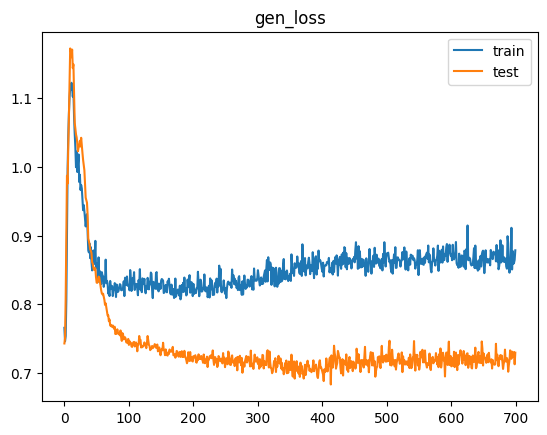

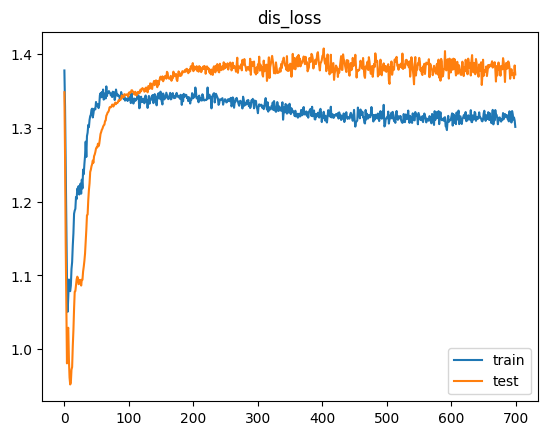

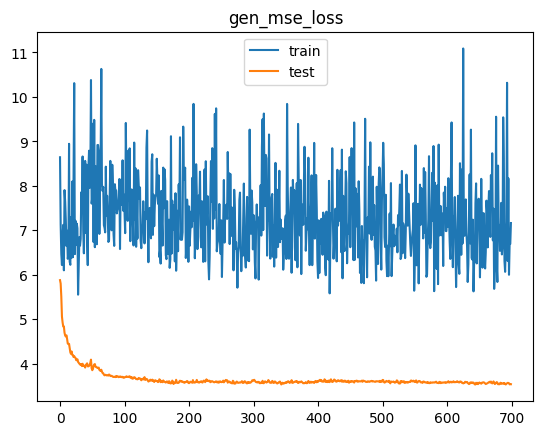

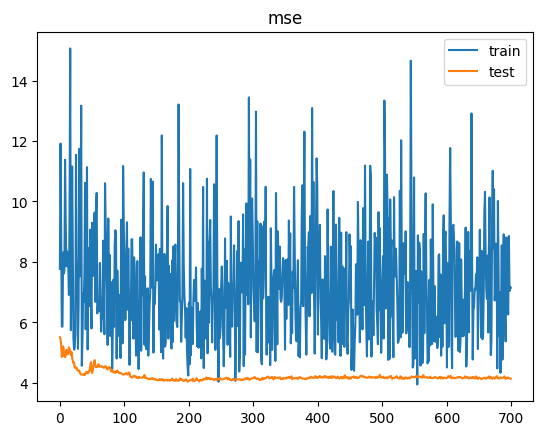

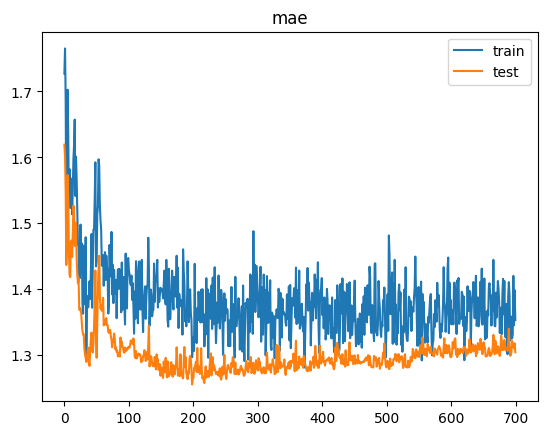

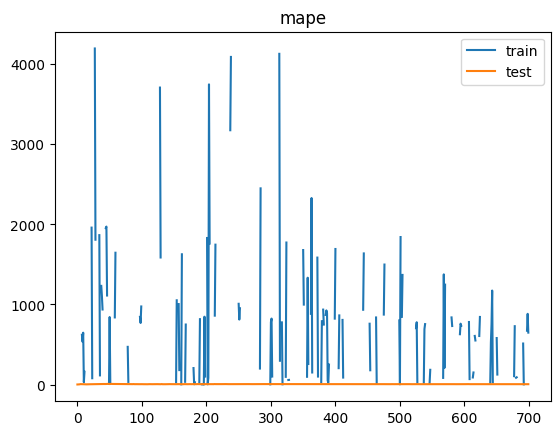

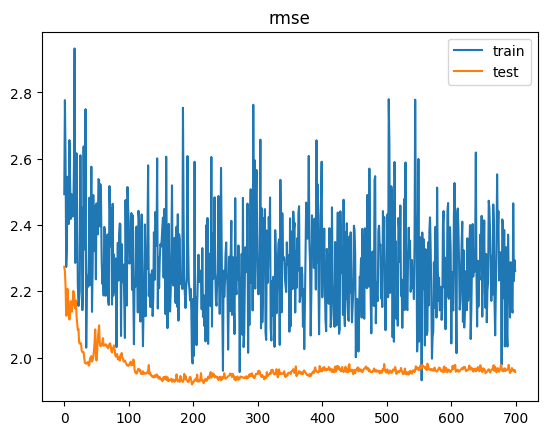

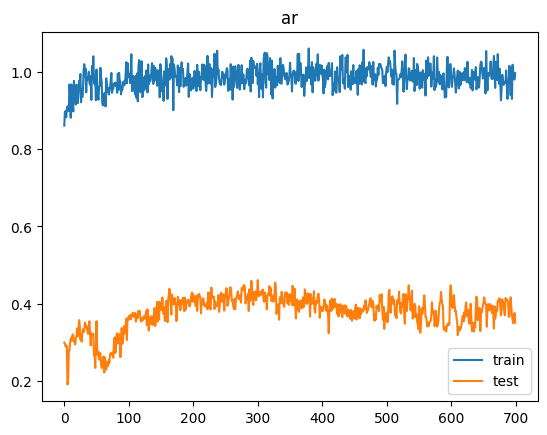

2/2 [==============================] - 1s 4ms/step


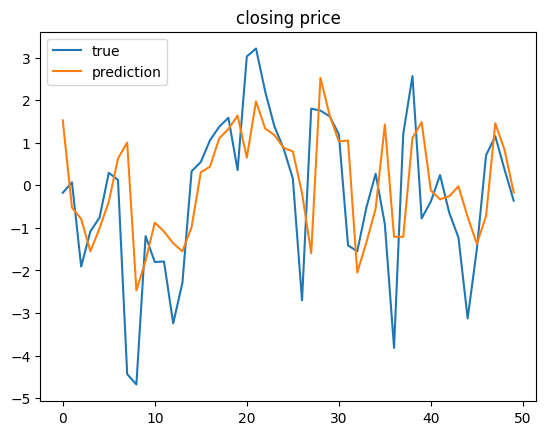

[MSE Baseline] train: 6.95896620511947  test: 4.1521541466081695
Delta time with epochs = 700: 0:10:53.122831
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 5, 20)       1440        ['input_4[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 5, 27)        0           ['bidirectional_6[0][0]',        
                                                                  'input_4[0][0]'

Time for epoch 46 is 0.9013152122497559 sec Generator Loss: 0.877240777015686,  Discriminator_loss: 1.302200436592102
Time for epoch 47 is 0.9010248184204102 sec Generator Loss: 0.8792049884796143,  Discriminator_loss: 1.3153367042541504
Time for epoch 48 is 0.8900735378265381 sec Generator Loss: 0.8599666953086853,  Discriminator_loss: 1.3225109577178955
Time for epoch 49 is 0.9425246715545654 sec Generator Loss: 0.8751821517944336,  Discriminator_loss: 1.3175158500671387
Time for epoch 50 is 0.9014437198638916 sec Generator Loss: 0.861735463142395,  Discriminator_loss: 1.3157446384429932
Time for epoch 51 is 0.9375250339508057 sec Generator Loss: 0.8558743000030518,  Discriminator_loss: 1.3183958530426025
Time for epoch 52 is 0.9351122379302979 sec Generator Loss: 0.8599532246589661,  Discriminator_loss: 1.3204915523529053
Time for epoch 53 is 0.9371912479400635 sec Generator Loss: 0.8648313283920288,  Discriminator_loss: 1.3236749172210693
Time for epoch 54 is 0.9006149768829346 sec

Time for epoch 115 is 0.8919851779937744 sec Generator Loss: 0.8473764657974243,  Discriminator_loss: 1.3285332918167114
Time for epoch 116 is 0.8860273361206055 sec Generator Loss: 0.8452555537223816,  Discriminator_loss: 1.338413119316101
Time for epoch 117 is 0.9067857265472412 sec Generator Loss: 0.8628568053245544,  Discriminator_loss: 1.328689694404602
Time for epoch 118 is 0.9329197406768799 sec Generator Loss: 0.8440489768981934,  Discriminator_loss: 1.3261960744857788
Time for epoch 119 is 0.9334414005279541 sec Generator Loss: 0.8385770916938782,  Discriminator_loss: 1.3223055601119995
Time for epoch 120 is 0.9007198810577393 sec Generator Loss: 0.8316056132316589,  Discriminator_loss: 1.3263914585113525
Time for epoch 121 is 0.886150598526001 sec Generator Loss: 0.8562681674957275,  Discriminator_loss: 1.3296420574188232
Time for epoch 122 is 0.8928272724151611 sec Generator Loss: 0.8397157788276672,  Discriminator_loss: 1.3240185976028442
Time for epoch 123 is 0.88819479942

Time for epoch 184 is 0.9128952026367188 sec Generator Loss: 0.8345913290977478,  Discriminator_loss: 1.3343486785888672
Time for epoch 185 is 0.943666934967041 sec Generator Loss: 0.8411686420440674,  Discriminator_loss: 1.324311375617981
Time for epoch 186 is 0.8898062705993652 sec Generator Loss: 0.8297485709190369,  Discriminator_loss: 1.3306809663772583
Time for epoch 187 is 0.8884875774383545 sec Generator Loss: 0.8214827179908752,  Discriminator_loss: 1.3391531705856323
Time for epoch 188 is 0.9092581272125244 sec Generator Loss: 0.8291297554969788,  Discriminator_loss: 1.3317111730575562
Time for epoch 189 is 0.8989725112915039 sec Generator Loss: 0.8412697315216064,  Discriminator_loss: 1.3320430517196655
Time for epoch 190 is 0.9182462692260742 sec Generator Loss: 0.8531370759010315,  Discriminator_loss: 1.3359339237213135
Time for epoch 191 is 0.9257826805114746 sec Generator Loss: 0.8327914476394653,  Discriminator_loss: 1.3286969661712646
Time for epoch 192 is 0.9084546566

Time for epoch 253 is 0.8929171562194824 sec Generator Loss: 0.849600076675415,  Discriminator_loss: 1.3208094835281372
Time for epoch 254 is 0.8997442722320557 sec Generator Loss: 0.8493695259094238,  Discriminator_loss: 1.3316432237625122
Time for epoch 255 is 0.9022617340087891 sec Generator Loss: 0.8541193604469299,  Discriminator_loss: 1.3256834745407104
Time for epoch 256 is 0.8991978168487549 sec Generator Loss: 0.8605436086654663,  Discriminator_loss: 1.3252811431884766
Time for epoch 257 is 0.9014270305633545 sec Generator Loss: 0.8503016829490662,  Discriminator_loss: 1.3255033493041992
Time for epoch 258 is 0.8854272365570068 sec Generator Loss: 0.832984983921051,  Discriminator_loss: 1.3238972425460815
Time for epoch 259 is 0.889707088470459 sec Generator Loss: 0.8524211645126343,  Discriminator_loss: 1.3214895725250244
Time for epoch 260 is 0.9247603416442871 sec Generator Loss: 0.8568418622016907,  Discriminator_loss: 1.3256418704986572
Time for epoch 261 is 0.88911938667

Time for epoch 321 is 0.8963825702667236 sec Generator Loss: 0.8697089552879333,  Discriminator_loss: 1.309097170829773
Time for epoch 322 is 0.8946139812469482 sec Generator Loss: 0.8530863523483276,  Discriminator_loss: 1.3197853565216064
Time for epoch 323 is 0.8973469734191895 sec Generator Loss: 0.8616981506347656,  Discriminator_loss: 1.3184242248535156
Time for epoch 324 is 0.8978455066680908 sec Generator Loss: 0.8557966351509094,  Discriminator_loss: 1.3135392665863037
Time for epoch 325 is 0.8939719200134277 sec Generator Loss: 0.8732405304908752,  Discriminator_loss: 1.3169918060302734
Time for epoch 326 is 0.90700364112854 sec Generator Loss: 0.8662950396537781,  Discriminator_loss: 1.3200603723526
Time for epoch 327 is 0.8979694843292236 sec Generator Loss: 0.8893156051635742,  Discriminator_loss: 1.3181058168411255
Time for epoch 328 is 0.8991937637329102 sec Generator Loss: 0.8611318469047546,  Discriminator_loss: 1.31186842918396
Time for epoch 329 is 0.8940610885620117

Time for epoch 390 is 0.8921895027160645 sec Generator Loss: 0.863913893699646,  Discriminator_loss: 1.317777395248413
Time for epoch 391 is 0.8946943283081055 sec Generator Loss: 0.861308753490448,  Discriminator_loss: 1.3087385892868042
Time for epoch 392 is 0.9137775897979736 sec Generator Loss: 0.8779211640357971,  Discriminator_loss: 1.3116703033447266
Time for epoch 393 is 0.8935537338256836 sec Generator Loss: 0.8697316646575928,  Discriminator_loss: 1.313205361366272
Time for epoch 394 is 0.89253830909729 sec Generator Loss: 0.8617419600486755,  Discriminator_loss: 1.3179051876068115
Time for epoch 395 is 0.9024679660797119 sec Generator Loss: 0.8523370623588562,  Discriminator_loss: 1.3169361352920532
Time for epoch 396 is 0.8937501907348633 sec Generator Loss: 0.8676683306694031,  Discriminator_loss: 1.3162592649459839
Time for epoch 397 is 0.8985104560852051 sec Generator Loss: 0.8731263279914856,  Discriminator_loss: 1.3030065298080444
Time for epoch 398 is 0.90466332435607

Time for epoch 458 is 0.900066614151001 sec Generator Loss: 0.89141845703125,  Discriminator_loss: 1.302803635597229
Time for epoch 459 is 0.8981218338012695 sec Generator Loss: 0.8699461221694946,  Discriminator_loss: 1.3081932067871094
Time for epoch 460 is 0.9007682800292969 sec Generator Loss: 0.8674144148826599,  Discriminator_loss: 1.3067667484283447
Time for epoch 461 is 0.903674840927124 sec Generator Loss: 0.883686363697052,  Discriminator_loss: 1.3013654947280884
Time for epoch 462 is 0.8922672271728516 sec Generator Loss: 0.874428927898407,  Discriminator_loss: 1.308767557144165
Time for epoch 463 is 0.908665657043457 sec Generator Loss: 0.8871697783470154,  Discriminator_loss: 1.3015928268432617
Time for epoch 464 is 0.8986301422119141 sec Generator Loss: 0.8893910050392151,  Discriminator_loss: 1.308480978012085
Time for epoch 465 is 0.8943982124328613 sec Generator Loss: 0.878404438495636,  Discriminator_loss: 1.3107460737228394
Time for epoch 466 is 0.8922257423400879 se

Time for epoch 527 is 0.9022815227508545 sec Generator Loss: 0.8686189651489258,  Discriminator_loss: 1.3061881065368652
Time for epoch 528 is 0.9015791416168213 sec Generator Loss: 0.8747401833534241,  Discriminator_loss: 1.3063446283340454
Time for epoch 529 is 0.9150547981262207 sec Generator Loss: 0.8828433752059937,  Discriminator_loss: 1.3025881052017212
Time for epoch 530 is 0.9330339431762695 sec Generator Loss: 0.8531768321990967,  Discriminator_loss: 1.3139188289642334
Time for epoch 531 is 0.8976504802703857 sec Generator Loss: 0.8679691553115845,  Discriminator_loss: 1.3145064115524292
Time for epoch 532 is 0.9019103050231934 sec Generator Loss: 0.8679012060165405,  Discriminator_loss: 1.2990225553512573
Time for epoch 533 is 0.8964018821716309 sec Generator Loss: 0.8704564571380615,  Discriminator_loss: 1.3117927312850952
Time for epoch 534 is 0.9205107688903809 sec Generator Loss: 0.879243791103363,  Discriminator_loss: 1.3074675798416138
Time for epoch 535 is 0.900255680

Time for epoch 595 is 0.9458041191101074 sec Generator Loss: 0.8645234704017639,  Discriminator_loss: 1.3204773664474487
Time for epoch 596 is 0.9398436546325684 sec Generator Loss: 0.8852259516716003,  Discriminator_loss: 1.3077932596206665
Time for epoch 597 is 0.933081865310669 sec Generator Loss: 0.8889738917350769,  Discriminator_loss: 1.3014858961105347
Time for epoch 598 is 0.9311535358428955 sec Generator Loss: 0.8608437776565552,  Discriminator_loss: 1.3204644918441772
Time for epoch 599 is 0.9418628215789795 sec Generator Loss: 0.8743802309036255,  Discriminator_loss: 1.309895634651184
Time for epoch 600 is 0.9671261310577393 sec Generator Loss: 0.8768775463104248,  Discriminator_loss: 1.310072660446167
Time for epoch 601 is 0.9268407821655273 sec Generator Loss: 0.8832407593727112,  Discriminator_loss: 1.3029085397720337
Time for epoch 602 is 0.9080994129180908 sec Generator Loss: 0.8670092821121216,  Discriminator_loss: 1.315297245979309
Time for epoch 603 is 0.895888090133

Time for epoch 664 is 0.8954474925994873 sec Generator Loss: 0.8586236238479614,  Discriminator_loss: 1.3104623556137085
Time for epoch 665 is 0.9339385032653809 sec Generator Loss: 0.879112958908081,  Discriminator_loss: 1.3058592081069946
Time for epoch 666 is 0.9068315029144287 sec Generator Loss: 0.872265636920929,  Discriminator_loss: 1.311164379119873
Time for epoch 667 is 0.8950684070587158 sec Generator Loss: 0.8753318786621094,  Discriminator_loss: 1.3109962940216064
Time for epoch 668 is 0.8978605270385742 sec Generator Loss: 0.8732672929763794,  Discriminator_loss: 1.3107017278671265
Time for epoch 669 is 0.893397331237793 sec Generator Loss: 0.8737133145332336,  Discriminator_loss: 1.3082143068313599
Time for epoch 670 is 0.895186185836792 sec Generator Loss: 0.8609578609466553,  Discriminator_loss: 1.3158549070358276
Time for epoch 671 is 0.9091837406158447 sec Generator Loss: 0.8775380253791809,  Discriminator_loss: 1.3044443130493164
Time for epoch 672 is 0.9009716510772

Time for epoch 733 is 0.901618480682373 sec Generator Loss: 0.9023379683494568,  Discriminator_loss: 1.304766297340393
Time for epoch 734 is 0.8996775150299072 sec Generator Loss: 0.8805180191993713,  Discriminator_loss: 1.3197523355484009
Time for epoch 735 is 0.8992273807525635 sec Generator Loss: 0.8528952598571777,  Discriminator_loss: 1.3187050819396973
Time for epoch 736 is 0.9048550128936768 sec Generator Loss: 0.8802517056465149,  Discriminator_loss: 1.3068581819534302
Time for epoch 737 is 0.9279119968414307 sec Generator Loss: 0.8732161521911621,  Discriminator_loss: 1.3070706129074097
Time for epoch 738 is 0.8992655277252197 sec Generator Loss: 0.870691180229187,  Discriminator_loss: 1.3102433681488037
Time for epoch 739 is 0.9312903881072998 sec Generator Loss: 0.865634024143219,  Discriminator_loss: 1.3083000183105469
Time for epoch 740 is 0.9891116619110107 sec Generator Loss: 0.8769891858100891,  Discriminator_loss: 1.311339020729065
Time for epoch 741 is 0.9397511482238

Time for epoch 802 is 0.9101767539978027 sec Generator Loss: 0.8740257024765015,  Discriminator_loss: 1.3191472291946411
Time for epoch 803 is 0.9028611183166504 sec Generator Loss: 0.8588124513626099,  Discriminator_loss: 1.3106769323349
Time for epoch 804 is 0.9028139114379883 sec Generator Loss: 0.8732821941375732,  Discriminator_loss: 1.3036420345306396
Time for epoch 805 is 0.9027304649353027 sec Generator Loss: 0.8703713417053223,  Discriminator_loss: 1.3121100664138794
Time for epoch 806 is 0.909775972366333 sec Generator Loss: 0.8625145554542542,  Discriminator_loss: 1.3052029609680176
Time for epoch 807 is 0.9084484577178955 sec Generator Loss: 0.8666682839393616,  Discriminator_loss: 1.3135111331939697
Time for epoch 808 is 0.9094371795654297 sec Generator Loss: 0.8752573728561401,  Discriminator_loss: 1.315434217453003
Time for epoch 809 is 0.8979904651641846 sec Generator Loss: 0.8910186290740967,  Discriminator_loss: 1.3057130575180054
Time for epoch 810 is 0.9019770622253

Time for epoch 871 is 0.9047720432281494 sec Generator Loss: 0.900980532169342,  Discriminator_loss: 1.3120276927947998
Time for epoch 872 is 0.911177396774292 sec Generator Loss: 0.8837118148803711,  Discriminator_loss: 1.3007535934448242
Time for epoch 873 is 0.917574405670166 sec Generator Loss: 0.875465989112854,  Discriminator_loss: 1.2971882820129395
Time for epoch 874 is 0.8980402946472168 sec Generator Loss: 0.8904135823249817,  Discriminator_loss: 1.3043755292892456
Time for epoch 875 is 0.9254460334777832 sec Generator Loss: 0.8703425526618958,  Discriminator_loss: 1.3128801584243774
Time for epoch 876 is 0.8930144309997559 sec Generator Loss: 0.8853002190589905,  Discriminator_loss: 1.3138678073883057
Time for epoch 877 is 0.8999710083007812 sec Generator Loss: 0.8690672516822815,  Discriminator_loss: 1.3207372426986694
Time for epoch 878 is 0.9210925102233887 sec Generator Loss: 0.8885164260864258,  Discriminator_loss: 1.3141976594924927
Time for epoch 879 is 0.904090166091

Time for epoch 939 is 0.8577663898468018 sec Generator Loss: 0.8635281920433044,  Discriminator_loss: 1.3167455196380615
Time for epoch 940 is 0.8419857025146484 sec Generator Loss: 0.8773202300071716,  Discriminator_loss: 1.3070262670516968
Time for epoch 941 is 0.901191234588623 sec Generator Loss: 0.8652142286300659,  Discriminator_loss: 1.3018817901611328
Time for epoch 942 is 0.9122908115386963 sec Generator Loss: 0.904498815536499,  Discriminator_loss: 1.2997018098831177
Time for epoch 943 is 0.9194836616516113 sec Generator Loss: 0.8771919012069702,  Discriminator_loss: 1.3027509450912476
Time for epoch 944 is 0.929095983505249 sec Generator Loss: 0.8834471702575684,  Discriminator_loss: 1.3108047246932983
Time for epoch 945 is 0.9075765609741211 sec Generator Loss: 0.9064546823501587,  Discriminator_loss: 1.3039370775222778
Time for epoch 946 is 0.9069762229919434 sec Generator Loss: 0.9055254459381104,  Discriminator_loss: 1.3080588579177856
Time for epoch 947 is 0.91156077384

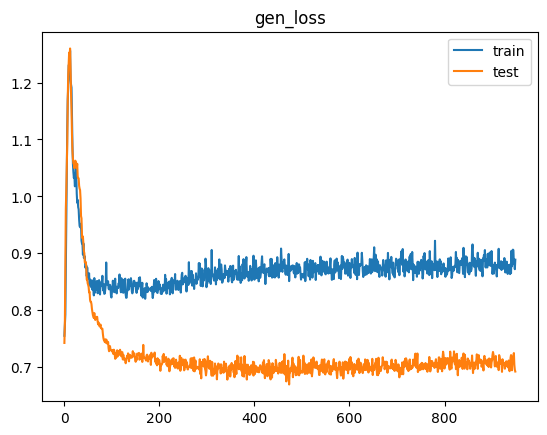

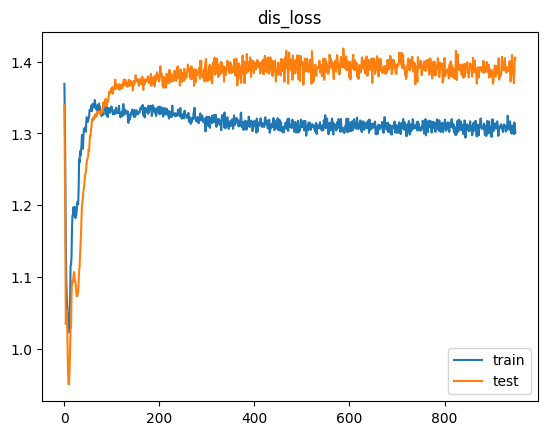

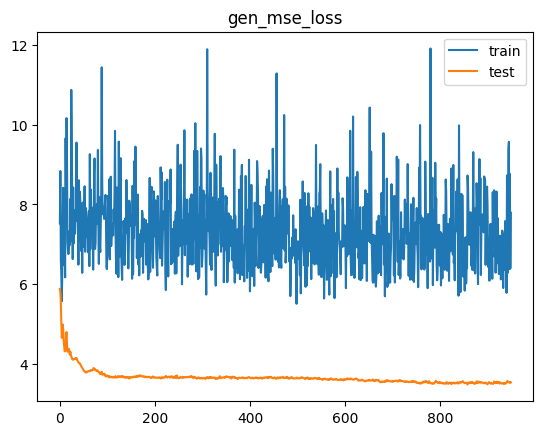

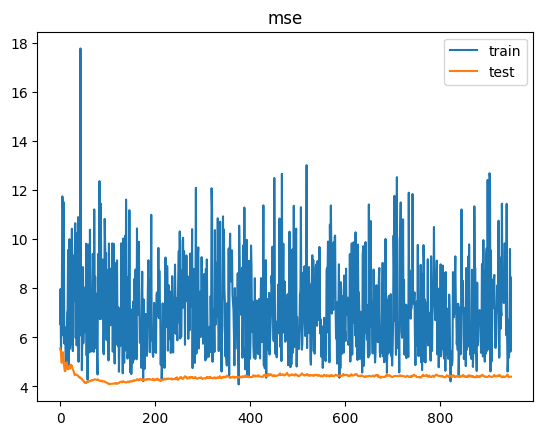

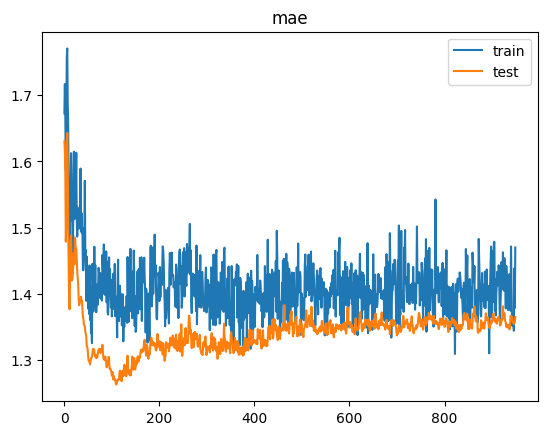

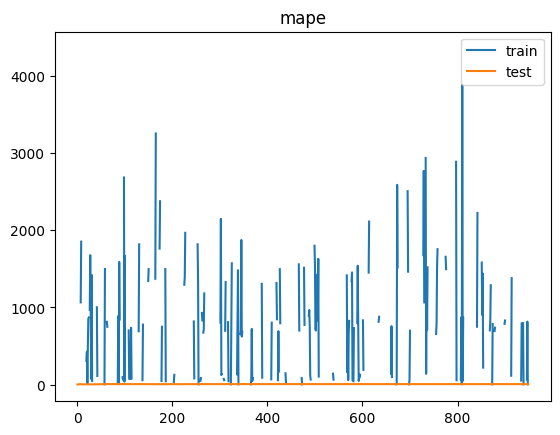

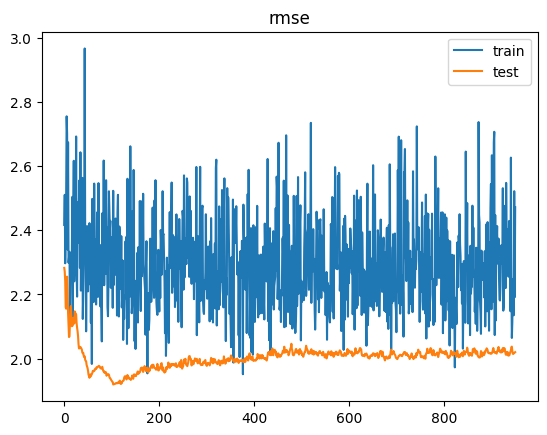

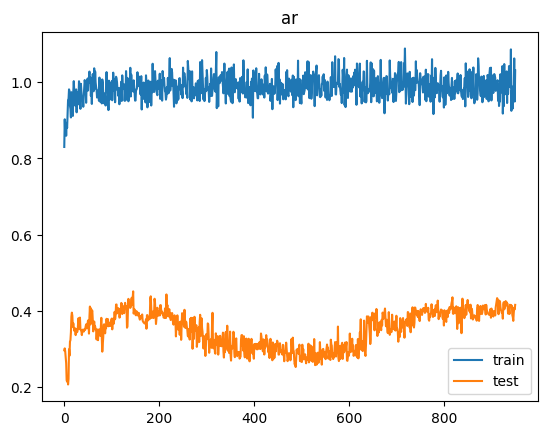

2/2 [==============================] - 1s 3ms/step


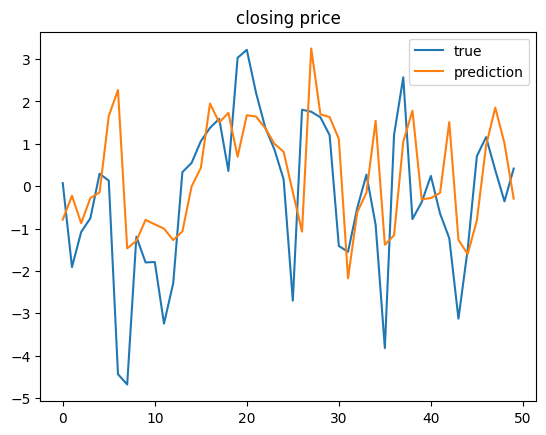

[MSE Baseline] train: 6.930795881937707  test: 4.16723565376744
Delta time with epochs = 950: 0:14:42.928882
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 5, 20)       1440        ['input_5[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 5, 27)        0           ['bidirectional_8[0][0]',        
                                                                  'input_5[0][0]']

Time for epoch 46 is 0.9045696258544922 sec Generator Loss: 0.8530282378196716,  Discriminator_loss: 1.3168624639511108
Time for epoch 47 is 0.9089739322662354 sec Generator Loss: 0.8595646619796753,  Discriminator_loss: 1.305309534072876
Time for epoch 48 is 0.9168944358825684 sec Generator Loss: 0.8505443930625916,  Discriminator_loss: 1.3231613636016846
Time for epoch 49 is 0.9054591655731201 sec Generator Loss: 0.8509926199913025,  Discriminator_loss: 1.3159966468811035
Time for epoch 50 is 0.9268264770507812 sec Generator Loss: 0.8397555947303772,  Discriminator_loss: 1.3138384819030762
Time for epoch 51 is 0.9077317714691162 sec Generator Loss: 0.8439110517501831,  Discriminator_loss: 1.3178174495697021
Time for epoch 52 is 0.9001059532165527 sec Generator Loss: 0.8387081623077393,  Discriminator_loss: 1.3286728858947754
Time for epoch 53 is 0.9023418426513672 sec Generator Loss: 0.8585723042488098,  Discriminator_loss: 1.3108716011047363
Time for epoch 54 is 0.9072015285491943 s

Time for epoch 115 is 0.9149620532989502 sec Generator Loss: 0.8301932215690613,  Discriminator_loss: 1.338685393333435
Time for epoch 116 is 0.8991587162017822 sec Generator Loss: 0.8353357315063477,  Discriminator_loss: 1.334946632385254
Time for epoch 117 is 0.8952209949493408 sec Generator Loss: 0.8532605767250061,  Discriminator_loss: 1.3323355913162231
Time for epoch 118 is 0.8997554779052734 sec Generator Loss: 0.8120124936103821,  Discriminator_loss: 1.3436592817306519
Time for epoch 119 is 0.9126825332641602 sec Generator Loss: 0.8223784565925598,  Discriminator_loss: 1.3325786590576172
Time for epoch 120 is 0.9010930061340332 sec Generator Loss: 0.8320552110671997,  Discriminator_loss: 1.3237745761871338
Time for epoch 121 is 0.904322624206543 sec Generator Loss: 0.8550606966018677,  Discriminator_loss: 1.329187035560608
Time for epoch 122 is 0.9263160228729248 sec Generator Loss: 0.8374205827713013,  Discriminator_loss: 1.3373292684555054
Time for epoch 123 is 0.902997970581

Time for epoch 183 is 1.042686939239502 sec Generator Loss: 0.8400662541389465,  Discriminator_loss: 1.3318778276443481
Time for epoch 184 is 1.0281200408935547 sec Generator Loss: 0.8402878642082214,  Discriminator_loss: 1.331184983253479
Time for epoch 185 is 1.021855115890503 sec Generator Loss: 0.8365827202796936,  Discriminator_loss: 1.3458137512207031
Time for epoch 186 is 1.0125606060028076 sec Generator Loss: 0.8280465006828308,  Discriminator_loss: 1.3323522806167603
Time for epoch 187 is 1.0063011646270752 sec Generator Loss: 0.8213747143745422,  Discriminator_loss: 1.325148582458496
Time for epoch 188 is 0.9530882835388184 sec Generator Loss: 0.8200224041938782,  Discriminator_loss: 1.3360613584518433
Time for epoch 189 is 0.950636625289917 sec Generator Loss: 0.8154335021972656,  Discriminator_loss: 1.3422718048095703
Time for epoch 190 is 0.9541802406311035 sec Generator Loss: 0.830856442451477,  Discriminator_loss: 1.3363431692123413
Time for epoch 191 is 1.07293248176574

Time for epoch 252 is 0.9866988658905029 sec Generator Loss: 0.8397444486618042,  Discriminator_loss: 1.3265800476074219
Time for epoch 253 is 0.9684081077575684 sec Generator Loss: 0.8345298767089844,  Discriminator_loss: 1.332301378250122
Time for epoch 254 is 0.9799644947052002 sec Generator Loss: 0.8540402054786682,  Discriminator_loss: 1.3370037078857422
Time for epoch 255 is 0.9691815376281738 sec Generator Loss: 0.8499005436897278,  Discriminator_loss: 1.3282517194747925
Time for epoch 256 is 1.0129899978637695 sec Generator Loss: 0.8560672998428345,  Discriminator_loss: 1.3256447315216064
Time for epoch 257 is 1.0605947971343994 sec Generator Loss: 0.8491366505622864,  Discriminator_loss: 1.3234349489212036
Time for epoch 258 is 1.0474467277526855 sec Generator Loss: 0.8456501960754395,  Discriminator_loss: 1.3203256130218506
Time for epoch 259 is 1.0125176906585693 sec Generator Loss: 0.8339731097221375,  Discriminator_loss: 1.3240779638290405
Time for epoch 260 is 1.039735555

Time for epoch 320 is 0.9728024005889893 sec Generator Loss: 0.8604195713996887,  Discriminator_loss: 1.324440836906433
Time for epoch 321 is 0.9966304302215576 sec Generator Loss: 0.8804060816764832,  Discriminator_loss: 1.3207968473434448
Time for epoch 322 is 1.0567660331726074 sec Generator Loss: 0.8561360836029053,  Discriminator_loss: 1.3165456056594849
Time for epoch 323 is 0.9990458488464355 sec Generator Loss: 0.8595005869865417,  Discriminator_loss: 1.3177669048309326
Time for epoch 324 is 1.0497984886169434 sec Generator Loss: 0.8479084372520447,  Discriminator_loss: 1.3175262212753296
Time for epoch 325 is 1.022589921951294 sec Generator Loss: 0.851854681968689,  Discriminator_loss: 1.3196120262145996
Time for epoch 326 is 1.0304927825927734 sec Generator Loss: 0.8488681316375732,  Discriminator_loss: 1.320812463760376
Time for epoch 327 is 0.9930863380432129 sec Generator Loss: 0.8549805879592896,  Discriminator_loss: 1.3195858001708984
Time for epoch 328 is 1.154328584671

Time for epoch 389 is 1.268172264099121 sec Generator Loss: 0.8555461168289185,  Discriminator_loss: 1.3176538944244385
Time for epoch 390 is 1.0034561157226562 sec Generator Loss: 0.8669014573097229,  Discriminator_loss: 1.317541480064392
Time for epoch 391 is 1.1396560668945312 sec Generator Loss: 0.8639585971832275,  Discriminator_loss: 1.3159842491149902
Time for epoch 392 is 0.9959080219268799 sec Generator Loss: 0.8541553616523743,  Discriminator_loss: 1.322596549987793
Time for epoch 393 is 0.9803364276885986 sec Generator Loss: 0.8527718782424927,  Discriminator_loss: 1.3124054670333862
Time for epoch 394 is 0.9760277271270752 sec Generator Loss: 0.852637767791748,  Discriminator_loss: 1.3249492645263672
Time for epoch 395 is 0.9723470211029053 sec Generator Loss: 0.8723226189613342,  Discriminator_loss: 1.318179726600647
Time for epoch 396 is 0.9558162689208984 sec Generator Loss: 0.8483901023864746,  Discriminator_loss: 1.3198941946029663
Time for epoch 397 is 1.0151665210723

Time for epoch 458 is 1.0092895030975342 sec Generator Loss: 0.8718833327293396,  Discriminator_loss: 1.3062036037445068
Time for epoch 459 is 1.0236849784851074 sec Generator Loss: 0.855196475982666,  Discriminator_loss: 1.3192366361618042
Time for epoch 460 is 1.0138640403747559 sec Generator Loss: 0.8536016345024109,  Discriminator_loss: 1.3186589479446411
Time for epoch 461 is 0.99424147605896 sec Generator Loss: 0.8693771958351135,  Discriminator_loss: 1.3131438493728638
Time for epoch 462 is 1.0221900939941406 sec Generator Loss: 0.8729833364486694,  Discriminator_loss: 1.3099920749664307
Time for epoch 463 is 1.0103979110717773 sec Generator Loss: 0.8689054250717163,  Discriminator_loss: 1.3042641878128052
Time for epoch 464 is 1.0066518783569336 sec Generator Loss: 0.8576682209968567,  Discriminator_loss: 1.31419837474823
Time for epoch 465 is 1.0285992622375488 sec Generator Loss: 0.8615390062332153,  Discriminator_loss: 1.3073872327804565
Time for epoch 466 is 1.0099573135375

Time for epoch 527 is 0.9517240524291992 sec Generator Loss: 0.8650232553482056,  Discriminator_loss: 1.3110605478286743
Time for epoch 528 is 0.9424643516540527 sec Generator Loss: 0.8779692053794861,  Discriminator_loss: 1.3154172897338867
Time for epoch 529 is 0.9407248497009277 sec Generator Loss: 0.8717244863510132,  Discriminator_loss: 1.311809778213501
Time for epoch 530 is 0.9729552268981934 sec Generator Loss: 0.8728379607200623,  Discriminator_loss: 1.3124390840530396
Time for epoch 531 is 0.9706315994262695 sec Generator Loss: 0.8745706677436829,  Discriminator_loss: 1.3129150867462158
Time for epoch 532 is 0.984485387802124 sec Generator Loss: 0.8696517944335938,  Discriminator_loss: 1.3049817085266113
Time for epoch 533 is 0.9867634773254395 sec Generator Loss: 0.8967353105545044,  Discriminator_loss: 1.3121676445007324
Time for epoch 534 is 0.9868407249450684 sec Generator Loss: 0.8552548885345459,  Discriminator_loss: 1.3138045072555542
Time for epoch 535 is 0.9922394752

Time for epoch 596 is 0.9487102031707764 sec Generator Loss: 0.900216281414032,  Discriminator_loss: 1.301934003829956
Time for epoch 597 is 0.9644932746887207 sec Generator Loss: 0.8693901896476746,  Discriminator_loss: 1.3124659061431885
Time for epoch 598 is 0.9665064811706543 sec Generator Loss: 0.8756992220878601,  Discriminator_loss: 1.3120276927947998
Time for epoch 599 is 0.9704265594482422 sec Generator Loss: 0.867862343788147,  Discriminator_loss: 1.308262586593628
Time for epoch 600 is 0.9572408199310303 sec Generator Loss: 0.898206353187561,  Discriminator_loss: 1.3076927661895752
Time for epoch 601 is 0.9630541801452637 sec Generator Loss: 0.879081130027771,  Discriminator_loss: 1.3045339584350586
Time for epoch 602 is 0.9717791080474854 sec Generator Loss: 0.8997628688812256,  Discriminator_loss: 1.3011128902435303
Time for epoch 603 is 0.9831488132476807 sec Generator Loss: 0.8786004781723022,  Discriminator_loss: 1.3055505752563477
Time for epoch 604 is 0.96727991104125

Time for epoch 665 is 1.0795512199401855 sec Generator Loss: 0.8891383409500122,  Discriminator_loss: 1.306472659111023
Time for epoch 666 is 1.043846845626831 sec Generator Loss: 0.8767397403717041,  Discriminator_loss: 1.30657958984375
Time for epoch 667 is 1.0611646175384521 sec Generator Loss: 0.869806706905365,  Discriminator_loss: 1.311312198638916
Time for epoch 668 is 1.0695836544036865 sec Generator Loss: 0.8749327063560486,  Discriminator_loss: 1.3077220916748047
Time for epoch 669 is 1.036041259765625 sec Generator Loss: 0.8678255081176758,  Discriminator_loss: 1.3118157386779785
Time for epoch 670 is 1.0325686931610107 sec Generator Loss: 0.8756598234176636,  Discriminator_loss: 1.312526822090149
Time for epoch 671 is 1.0085639953613281 sec Generator Loss: 0.8835523128509521,  Discriminator_loss: 1.307507038116455
Time for epoch 672 is 1.0033771991729736 sec Generator Loss: 0.8828960657119751,  Discriminator_loss: 1.302077293395996
Time for epoch 673 is 1.001725673675537 se

Time for epoch 733 is 1.0110089778900146 sec Generator Loss: 0.8672384023666382,  Discriminator_loss: 1.3151307106018066
Time for epoch 734 is 1.024155616760254 sec Generator Loss: 0.877318263053894,  Discriminator_loss: 1.3177056312561035
Time for epoch 735 is 1.0124077796936035 sec Generator Loss: 0.8687804341316223,  Discriminator_loss: 1.311946153640747
Time for epoch 736 is 1.0088143348693848 sec Generator Loss: 0.8833233118057251,  Discriminator_loss: 1.3038774728775024
Time for epoch 737 is 1.0061688423156738 sec Generator Loss: 0.8968585729598999,  Discriminator_loss: 1.3101214170455933
Time for epoch 738 is 1.0012197494506836 sec Generator Loss: 0.8718732595443726,  Discriminator_loss: 1.3055518865585327
Time for epoch 739 is 1.003753662109375 sec Generator Loss: 0.8779067993164062,  Discriminator_loss: 1.3103080987930298
Time for epoch 740 is 0.9894988536834717 sec Generator Loss: 0.8865801095962524,  Discriminator_loss: 1.308866024017334
Time for epoch 741 is 1.0734989643096

Time for epoch 801 is 1.0190110206604004 sec Generator Loss: 0.8849305510520935,  Discriminator_loss: 1.3020551204681396
Time for epoch 802 is 1.0560901165008545 sec Generator Loss: 0.8875283598899841,  Discriminator_loss: 1.3086683750152588
Time for epoch 803 is 1.037539005279541 sec Generator Loss: 0.8826196789741516,  Discriminator_loss: 1.2993850708007812
Time for epoch 804 is 1.0217955112457275 sec Generator Loss: 0.8727796077728271,  Discriminator_loss: 1.309187650680542
Time for epoch 805 is 1.0609638690948486 sec Generator Loss: 0.8861491084098816,  Discriminator_loss: 1.3081060647964478
Time for epoch 806 is 1.02803635597229 sec Generator Loss: 0.8782904148101807,  Discriminator_loss: 1.2976162433624268
Time for epoch 807 is 1.1752266883850098 sec Generator Loss: 0.8815122842788696,  Discriminator_loss: 1.304003119468689
Time for epoch 808 is 1.3296215534210205 sec Generator Loss: 0.8836076855659485,  Discriminator_loss: 1.3051830530166626
Time for epoch 809 is 1.4506123065948

Time for epoch 870 is 1.3020262718200684 sec Generator Loss: 0.886255145072937,  Discriminator_loss: 1.3006352186203003
Time for epoch 871 is 1.1577386856079102 sec Generator Loss: 0.8748846650123596,  Discriminator_loss: 1.3031187057495117
Time for epoch 872 is 1.1893260478973389 sec Generator Loss: 0.9008985757827759,  Discriminator_loss: 1.2988379001617432
Time for epoch 873 is 1.0976061820983887 sec Generator Loss: 0.8902178406715393,  Discriminator_loss: 1.298203706741333
Time for epoch 874 is 1.1361396312713623 sec Generator Loss: 0.8837950229644775,  Discriminator_loss: 1.3114902973175049
Time for epoch 875 is 1.0414371490478516 sec Generator Loss: 0.9166998863220215,  Discriminator_loss: 1.2921078205108643
Time for epoch 876 is 1.022129774093628 sec Generator Loss: 0.8857194185256958,  Discriminator_loss: 1.3050585985183716
Time for epoch 877 is 1.0076265335083008 sec Generator Loss: 0.8684737682342529,  Discriminator_loss: 1.3037939071655273
Time for epoch 878 is 1.02570652961

Time for epoch 939 is 1.0672483444213867 sec Generator Loss: 0.8908776044845581,  Discriminator_loss: 1.3048293590545654
Time for epoch 940 is 1.0720820426940918 sec Generator Loss: 0.8806772232055664,  Discriminator_loss: 1.318259835243225
Time for epoch 941 is 1.0764734745025635 sec Generator Loss: 0.8827662467956543,  Discriminator_loss: 1.301774263381958
Time for epoch 942 is 1.0850474834442139 sec Generator Loss: 0.8767461180686951,  Discriminator_loss: 1.310587763786316
Time for epoch 943 is 1.2249467372894287 sec Generator Loss: 0.8791024088859558,  Discriminator_loss: 1.3010247945785522
Time for epoch 944 is 1.1475367546081543 sec Generator Loss: 0.8948371410369873,  Discriminator_loss: 1.290087103843689
Time for epoch 945 is 1.125953197479248 sec Generator Loss: 0.8922407627105713,  Discriminator_loss: 1.301910638809204
Time for epoch 946 is 1.0980329513549805 sec Generator Loss: 0.8890420198440552,  Discriminator_loss: 1.3001106977462769
Time for epoch 947 is 1.08895492553710

Time for epoch 1007 is 1.0591869354248047 sec Generator Loss: 0.8827502131462097,  Discriminator_loss: 1.2994791269302368
Time for epoch 1008 is 1.105417013168335 sec Generator Loss: 0.8903013467788696,  Discriminator_loss: 1.2959574460983276
Time for epoch 1009 is 0.9860470294952393 sec Generator Loss: 0.9073200225830078,  Discriminator_loss: 1.2999130487442017
Time for epoch 1010 is 0.9772312641143799 sec Generator Loss: 0.8943819999694824,  Discriminator_loss: 1.2996814250946045
Time for epoch 1011 is 0.9834997653961182 sec Generator Loss: 0.8809533715248108,  Discriminator_loss: 1.3041056394577026
Time for epoch 1012 is 0.9783122539520264 sec Generator Loss: 0.8927177786827087,  Discriminator_loss: 1.2942028045654297
Time for epoch 1013 is 0.9727466106414795 sec Generator Loss: 0.8848223686218262,  Discriminator_loss: 1.3010464906692505
Time for epoch 1014 is 0.9797203540802002 sec Generator Loss: 0.8763461112976074,  Discriminator_loss: 1.3085730075836182
Time for epoch 1015 is 0.

Time for epoch 1075 is 1.170210838317871 sec Generator Loss: 0.9035729765892029,  Discriminator_loss: 1.2978941202163696
Time for epoch 1076 is 1.1029224395751953 sec Generator Loss: 0.8953264951705933,  Discriminator_loss: 1.310340166091919
Time for epoch 1077 is 1.0417742729187012 sec Generator Loss: 0.877634584903717,  Discriminator_loss: 1.3023160696029663
Time for epoch 1078 is 1.0456442832946777 sec Generator Loss: 0.8906456232070923,  Discriminator_loss: 1.304389238357544
Time for epoch 1079 is 1.076169490814209 sec Generator Loss: 0.900510847568512,  Discriminator_loss: 1.2916603088378906
Time for epoch 1080 is 1.0983960628509521 sec Generator Loss: 0.9065776467323303,  Discriminator_loss: 1.3083304166793823
Time for epoch 1081 is 1.08477783203125 sec Generator Loss: 0.877393364906311,  Discriminator_loss: 1.2995977401733398
Time for epoch 1082 is 1.0349609851837158 sec Generator Loss: 0.8715618252754211,  Discriminator_loss: 1.3098394870758057
Time for epoch 1083 is 1.05978965

Time for epoch 1143 is 1.0802206993103027 sec Generator Loss: 0.8787950277328491,  Discriminator_loss: 1.3053776025772095
Time for epoch 1144 is 1.0355288982391357 sec Generator Loss: 0.893435001373291,  Discriminator_loss: 1.2984689474105835
Time for epoch 1145 is 1.0529797077178955 sec Generator Loss: 0.8941768407821655,  Discriminator_loss: 1.301554799079895
Time for epoch 1146 is 1.0255212783813477 sec Generator Loss: 0.908839225769043,  Discriminator_loss: 1.3012847900390625
Time for epoch 1147 is 1.0504202842712402 sec Generator Loss: 0.8896677494049072,  Discriminator_loss: 1.303952932357788
Time for epoch 1148 is 0.9914796352386475 sec Generator Loss: 0.8979980945587158,  Discriminator_loss: 1.3002476692199707
Time for epoch 1149 is 1.117321491241455 sec Generator Loss: 0.884672999382019,  Discriminator_loss: 1.2965048551559448
Time for epoch 1150 is 0.9717566967010498 sec Generator Loss: 0.8914453387260437,  Discriminator_loss: 1.3016726970672607
Time for epoch 1151 is 0.95658

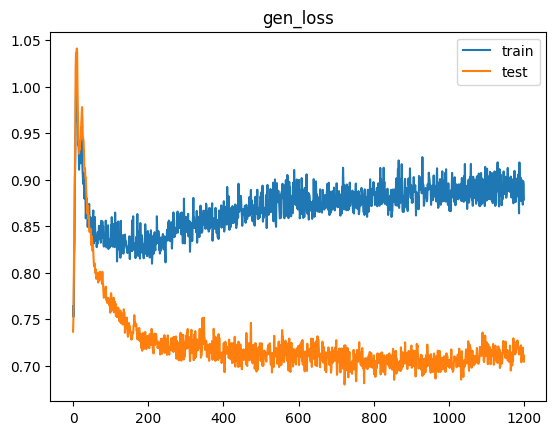

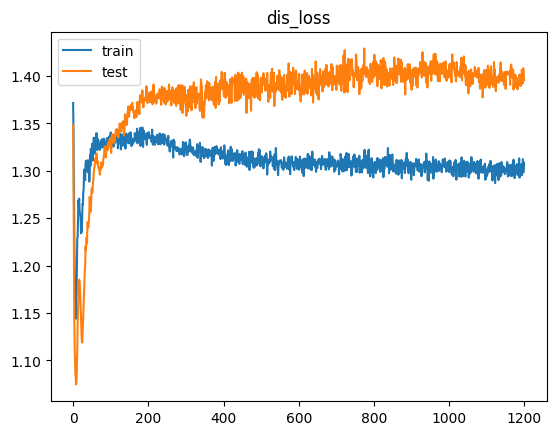

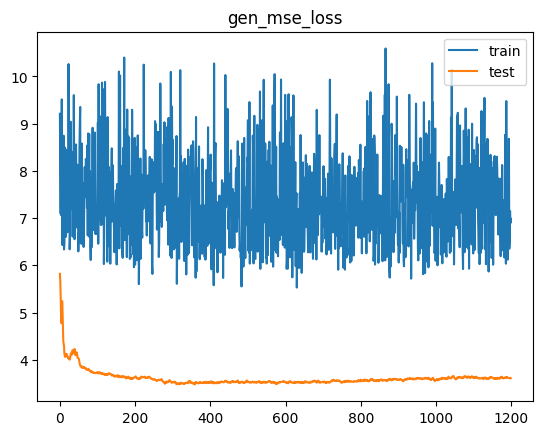

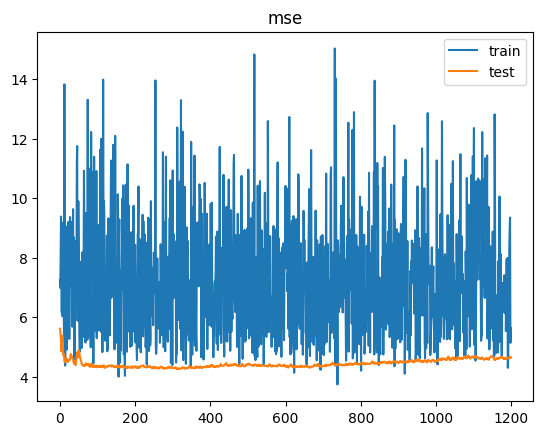

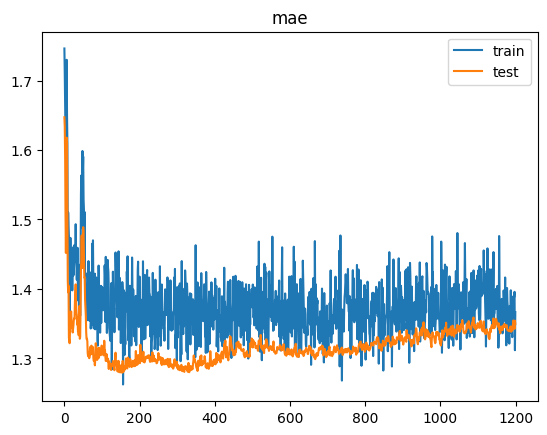

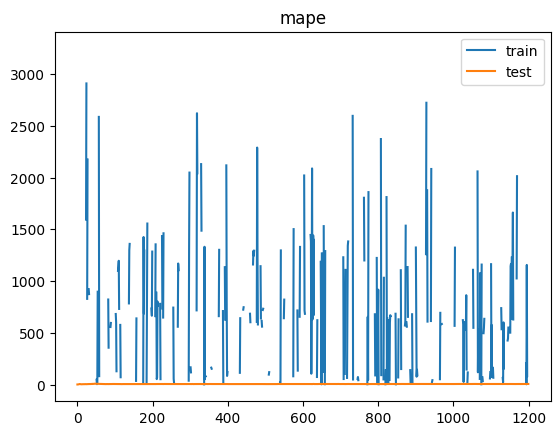

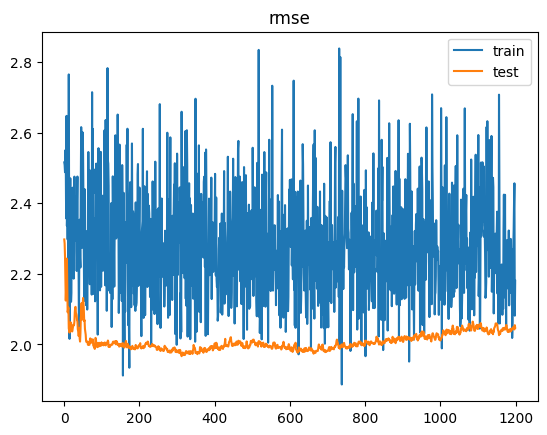

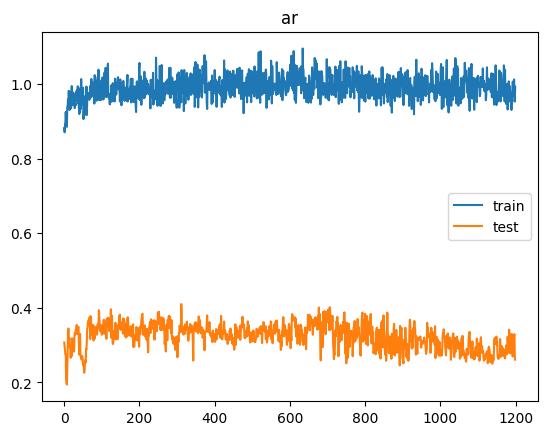

2/2 [==============================] - 1s 4ms/step


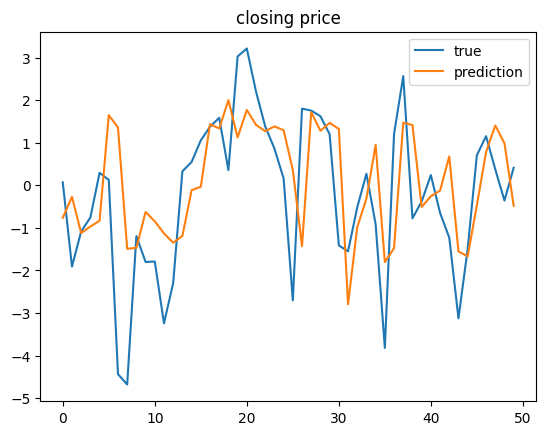

[MSE Baseline] train: 6.545465373205846  test: 4.16723565376744
Delta time with epochs = 1200: 0:20:57.186388
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_10 (Bidirectiona  (None, 5, 20)       1440        ['input_6[0][0]']                
 l)                                                                                               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 5, 27)        0           ['bidirectional_10[0][0]',       
                                                                  'input_6[0][0]'

Time for epoch 46 is 1.0159263610839844 sec Generator Loss: 0.8283130526542664,  Discriminator_loss: 1.3467341661453247
Time for epoch 47 is 0.9803078174591064 sec Generator Loss: 0.84427809715271,  Discriminator_loss: 1.3393217325210571
Time for epoch 48 is 0.9867639541625977 sec Generator Loss: 0.8406005501747131,  Discriminator_loss: 1.3460049629211426
Time for epoch 49 is 1.1687111854553223 sec Generator Loss: 0.8260484337806702,  Discriminator_loss: 1.343648910522461
Time for epoch 50 is 1.16532301902771 sec Generator Loss: 0.8524487614631653,  Discriminator_loss: 1.348562240600586
Time for epoch 51 is 1.3016135692596436 sec Generator Loss: 0.8557562828063965,  Discriminator_loss: 1.3454262018203735
Time for epoch 52 is 1.2367990016937256 sec Generator Loss: 0.8263672590255737,  Discriminator_loss: 1.3466001749038696
Time for epoch 53 is 1.191941499710083 sec Generator Loss: 0.8241672515869141,  Discriminator_loss: 1.3465029001235962
Time for epoch 54 is 1.2010185718536377 sec Gen

Time for epoch 115 is 1.0331134796142578 sec Generator Loss: 0.8423752188682556,  Discriminator_loss: 1.3270459175109863
Time for epoch 116 is 0.969977617263794 sec Generator Loss: 0.8584351539611816,  Discriminator_loss: 1.3291752338409424
Time for epoch 117 is 0.975888729095459 sec Generator Loss: 0.817285418510437,  Discriminator_loss: 1.3333691358566284
Time for epoch 118 is 1.0103895664215088 sec Generator Loss: 0.8321413397789001,  Discriminator_loss: 1.3358122110366821
Time for epoch 119 is 0.9912524223327637 sec Generator Loss: 0.8421241641044617,  Discriminator_loss: 1.3354305028915405
Time for epoch 120 is 1.000664234161377 sec Generator Loss: 0.8370946645736694,  Discriminator_loss: 1.3330506086349487
Time for epoch 121 is 0.9711942672729492 sec Generator Loss: 0.8460874557495117,  Discriminator_loss: 1.3347041606903076
Time for epoch 122 is 1.0344009399414062 sec Generator Loss: 0.8480828404426575,  Discriminator_loss: 1.3332487344741821
Time for epoch 123 is 1.077915430068

Time for epoch 184 is 0.9934251308441162 sec Generator Loss: 0.8392335176467896,  Discriminator_loss: 1.3368948698043823
Time for epoch 185 is 0.9869234561920166 sec Generator Loss: 0.8462914824485779,  Discriminator_loss: 1.3378660678863525
Time for epoch 186 is 0.9909086227416992 sec Generator Loss: 0.8544912338256836,  Discriminator_loss: 1.331477403640747
Time for epoch 187 is 0.9785811901092529 sec Generator Loss: 0.8483331203460693,  Discriminator_loss: 1.335546851158142
Time for epoch 188 is 0.9771218299865723 sec Generator Loss: 0.8463317155838013,  Discriminator_loss: 1.3374329805374146
Time for epoch 189 is 1.051435947418213 sec Generator Loss: 0.8349493145942688,  Discriminator_loss: 1.3312337398529053
Time for epoch 190 is 1.0272467136383057 sec Generator Loss: 0.8588372468948364,  Discriminator_loss: 1.320995807647705
Time for epoch 191 is 0.987802267074585 sec Generator Loss: 0.835835337638855,  Discriminator_loss: 1.3397856950759888
Time for epoch 192 is 0.98145914077758

Time for epoch 253 is 0.9923572540283203 sec Generator Loss: 0.8539395332336426,  Discriminator_loss: 1.3196805715560913
Time for epoch 254 is 0.9851601123809814 sec Generator Loss: 0.8598850965499878,  Discriminator_loss: 1.3202860355377197
Time for epoch 255 is 0.9906802177429199 sec Generator Loss: 0.8435856699943542,  Discriminator_loss: 1.3279166221618652
Time for epoch 256 is 0.9849123954772949 sec Generator Loss: 0.8484205007553101,  Discriminator_loss: 1.3226460218429565
Time for epoch 257 is 1.0042798519134521 sec Generator Loss: 0.844914972782135,  Discriminator_loss: 1.3193271160125732
Time for epoch 258 is 0.9937384128570557 sec Generator Loss: 0.8587300777435303,  Discriminator_loss: 1.3172376155853271
Time for epoch 259 is 1.073080062866211 sec Generator Loss: 0.8377392888069153,  Discriminator_loss: 1.3246424198150635
Time for epoch 260 is 1.045942783355713 sec Generator Loss: 0.8423895835876465,  Discriminator_loss: 1.3214582204818726
Time for epoch 261 is 1.25999355316

Time for epoch 322 is 1.083672046661377 sec Generator Loss: 0.8535435795783997,  Discriminator_loss: 1.3172428607940674
Time for epoch 323 is 1.0944569110870361 sec Generator Loss: 0.8402885794639587,  Discriminator_loss: 1.3259798288345337
Time for epoch 324 is 1.1454365253448486 sec Generator Loss: 0.8594173192977905,  Discriminator_loss: 1.3156296014785767
Time for epoch 325 is 1.1257667541503906 sec Generator Loss: 0.8666275143623352,  Discriminator_loss: 1.3177443742752075
Time for epoch 326 is 1.0697524547576904 sec Generator Loss: 0.8635635375976562,  Discriminator_loss: 1.3171073198318481
Time for epoch 327 is 1.0861072540283203 sec Generator Loss: 0.8542816042900085,  Discriminator_loss: 1.3216294050216675
Time for epoch 328 is 1.1054840087890625 sec Generator Loss: 0.8590491414070129,  Discriminator_loss: 1.3216930627822876
Time for epoch 329 is 1.083129644393921 sec Generator Loss: 0.8674033880233765,  Discriminator_loss: 1.3215110301971436
Time for epoch 330 is 1.0776827335

Time for epoch 391 is 1.0077776908874512 sec Generator Loss: 0.8489214777946472,  Discriminator_loss: 1.3171128034591675
Time for epoch 392 is 1.0056874752044678 sec Generator Loss: 0.8932040333747864,  Discriminator_loss: 1.3209928274154663
Time for epoch 393 is 1.0039031505584717 sec Generator Loss: 0.8578371405601501,  Discriminator_loss: 1.312854290008545
Time for epoch 394 is 1.01301908493042 sec Generator Loss: 0.8606115579605103,  Discriminator_loss: 1.3166022300720215
Time for epoch 395 is 1.1706743240356445 sec Generator Loss: 0.8550068140029907,  Discriminator_loss: 1.3098746538162231
Time for epoch 396 is 1.039722204208374 sec Generator Loss: 0.8915431499481201,  Discriminator_loss: 1.3155052661895752
Time for epoch 397 is 1.011490821838379 sec Generator Loss: 0.8598203063011169,  Discriminator_loss: 1.3237106800079346
Time for epoch 398 is 1.010362148284912 sec Generator Loss: 0.8474344611167908,  Discriminator_loss: 1.3253259658813477
Time for epoch 399 is 1.02837443351745

Time for epoch 460 is 1.0728886127471924 sec Generator Loss: 0.8420054316520691,  Discriminator_loss: 1.3222748041152954
Time for epoch 461 is 1.0790328979492188 sec Generator Loss: 0.8534626960754395,  Discriminator_loss: 1.3059502840042114
Time for epoch 462 is 1.1011872291564941 sec Generator Loss: 0.8531826734542847,  Discriminator_loss: 1.3109674453735352
Time for epoch 463 is 1.012439489364624 sec Generator Loss: 0.857178807258606,  Discriminator_loss: 1.315704345703125
Time for epoch 464 is 1.073697805404663 sec Generator Loss: 0.8609937429428101,  Discriminator_loss: 1.3182133436203003
Time for epoch 465 is 1.0096566677093506 sec Generator Loss: 0.867305338382721,  Discriminator_loss: 1.313813328742981
Time for epoch 466 is 1.0232875347137451 sec Generator Loss: 0.8556963205337524,  Discriminator_loss: 1.3225480318069458
Time for epoch 467 is 1.0368914604187012 sec Generator Loss: 0.8505117297172546,  Discriminator_loss: 1.315675973892212
Time for epoch 468 is 1.071020126342773

Time for epoch 529 is 1.1244661808013916 sec Generator Loss: 0.8643547296524048,  Discriminator_loss: 1.3064181804656982
Time for epoch 530 is 1.1419148445129395 sec Generator Loss: 0.8686287999153137,  Discriminator_loss: 1.3215512037277222
Time for epoch 531 is 1.0341730117797852 sec Generator Loss: 0.8543532490730286,  Discriminator_loss: 1.322196364402771
Time for epoch 532 is 1.0163524150848389 sec Generator Loss: 0.8473499417304993,  Discriminator_loss: 1.314745545387268
Time for epoch 533 is 1.0287647247314453 sec Generator Loss: 0.8756345510482788,  Discriminator_loss: 1.3032538890838623
Time for epoch 534 is 1.0077452659606934 sec Generator Loss: 0.8653045296669006,  Discriminator_loss: 1.318528175354004
Time for epoch 535 is 1.0615403652191162 sec Generator Loss: 0.8677583336830139,  Discriminator_loss: 1.3100568056106567
Time for epoch 536 is 1.0981526374816895 sec Generator Loss: 0.8567357659339905,  Discriminator_loss: 1.319894552230835
Time for epoch 537 is 1.022342920303

Time for epoch 598 is 1.0291292667388916 sec Generator Loss: 0.8752559423446655,  Discriminator_loss: 1.3028875589370728
Time for epoch 599 is 1.015653371810913 sec Generator Loss: 0.8668816089630127,  Discriminator_loss: 1.309149980545044
Time for epoch 600 is 1.03177809715271 sec Generator Loss: 0.8679932951927185,  Discriminator_loss: 1.3106684684753418
Time for epoch 601 is 1.0438520908355713 sec Generator Loss: 0.8890200257301331,  Discriminator_loss: 1.3083993196487427
Time for epoch 602 is 1.0859158039093018 sec Generator Loss: 0.8694429397583008,  Discriminator_loss: 1.3125659227371216
Time for epoch 603 is 1.0425212383270264 sec Generator Loss: 0.87223219871521,  Discriminator_loss: 1.3052833080291748
Time for epoch 604 is 1.0466783046722412 sec Generator Loss: 0.8603572249412537,  Discriminator_loss: 1.3098111152648926
Time for epoch 605 is 1.0517117977142334 sec Generator Loss: 0.8621686697006226,  Discriminator_loss: 1.3189395666122437
Time for epoch 606 is 1.02924060821533

Time for epoch 667 is 1.11564040184021 sec Generator Loss: 0.8688781261444092,  Discriminator_loss: 1.3097034692764282
Time for epoch 668 is 1.0944561958312988 sec Generator Loss: 0.8912443518638611,  Discriminator_loss: 1.304686188697815
Time for epoch 669 is 1.1361663341522217 sec Generator Loss: 0.8706167936325073,  Discriminator_loss: 1.3025108575820923
Time for epoch 670 is 1.1073493957519531 sec Generator Loss: 0.8843688368797302,  Discriminator_loss: 1.3082287311553955
Time for epoch 671 is 1.066542148590088 sec Generator Loss: 0.8922584056854248,  Discriminator_loss: 1.304700493812561
Time for epoch 672 is 1.0986247062683105 sec Generator Loss: 0.8651052117347717,  Discriminator_loss: 1.3044506311416626
Time for epoch 673 is 1.0871474742889404 sec Generator Loss: 0.886638879776001,  Discriminator_loss: 1.307610034942627
Time for epoch 674 is 1.1226165294647217 sec Generator Loss: 0.8707581758499146,  Discriminator_loss: 1.3061366081237793
Time for epoch 675 is 1.088486194610595

Time for epoch 736 is 1.1175878047943115 sec Generator Loss: 0.8699949383735657,  Discriminator_loss: 1.3035528659820557
Time for epoch 737 is 1.1098911762237549 sec Generator Loss: 0.8649117350578308,  Discriminator_loss: 1.3117221593856812
Time for epoch 738 is 1.145569086074829 sec Generator Loss: 0.8909631371498108,  Discriminator_loss: 1.2953342199325562
Time for epoch 739 is 1.1274113655090332 sec Generator Loss: 0.8909292817115784,  Discriminator_loss: 1.2951139211654663
Time for epoch 740 is 1.1928589344024658 sec Generator Loss: 0.8881276845932007,  Discriminator_loss: 1.3062269687652588
Time for epoch 741 is 1.1743268966674805 sec Generator Loss: 0.8681841492652893,  Discriminator_loss: 1.3129929304122925
Time for epoch 742 is 1.1734325885772705 sec Generator Loss: 0.872835099697113,  Discriminator_loss: 1.309043526649475
Time for epoch 743 is 1.181889533996582 sec Generator Loss: 0.8805248141288757,  Discriminator_loss: 1.3072816133499146
Time for epoch 744 is 1.206246614456

Time for epoch 805 is 1.1280035972595215 sec Generator Loss: 0.8731991052627563,  Discriminator_loss: 1.3069995641708374
Time for epoch 806 is 1.10011625289917 sec Generator Loss: 0.8622767925262451,  Discriminator_loss: 1.3112902641296387
Time for epoch 807 is 1.098325490951538 sec Generator Loss: 0.8904849290847778,  Discriminator_loss: 1.2938002347946167
Time for epoch 808 is 1.0950021743774414 sec Generator Loss: 0.8804797530174255,  Discriminator_loss: 1.3115344047546387
Time for epoch 809 is 1.140951156616211 sec Generator Loss: 0.8775714635848999,  Discriminator_loss: 1.3015081882476807
Time for epoch 810 is 1.1073973178863525 sec Generator Loss: 0.864923357963562,  Discriminator_loss: 1.3088890314102173
Time for epoch 811 is 1.1061904430389404 sec Generator Loss: 0.8708943724632263,  Discriminator_loss: 1.3021372556686401
Time for epoch 812 is 1.0936708450317383 sec Generator Loss: 0.8758836984634399,  Discriminator_loss: 1.302222490310669
Time for epoch 813 is 1.09882378578186

Time for epoch 874 is 1.2154183387756348 sec Generator Loss: 0.8750346302986145,  Discriminator_loss: 1.3032283782958984
Time for epoch 875 is 1.252673625946045 sec Generator Loss: 0.8639966249465942,  Discriminator_loss: 1.3085126876831055
Time for epoch 876 is 1.202150821685791 sec Generator Loss: 0.8730899691581726,  Discriminator_loss: 1.3105894327163696
Time for epoch 877 is 1.1751289367675781 sec Generator Loss: 0.8887522220611572,  Discriminator_loss: 1.2900338172912598
Time for epoch 878 is 1.1597673892974854 sec Generator Loss: 0.8943513631820679,  Discriminator_loss: 1.308860182762146
Time for epoch 879 is 1.2952940464019775 sec Generator Loss: 0.8755090236663818,  Discriminator_loss: 1.296669840812683
Time for epoch 880 is 1.2733612060546875 sec Generator Loss: 0.8825929760932922,  Discriminator_loss: 1.3012442588806152
Time for epoch 881 is 1.2650461196899414 sec Generator Loss: 0.8762561678886414,  Discriminator_loss: 1.29863703250885
Time for epoch 882 is 1.23646593093872

Time for epoch 943 is 1.1535167694091797 sec Generator Loss: 0.883601725101471,  Discriminator_loss: 1.2984950542449951
Time for epoch 944 is 1.1317811012268066 sec Generator Loss: 0.8644751906394958,  Discriminator_loss: 1.3115017414093018
Time for epoch 945 is 1.1282446384429932 sec Generator Loss: 0.8769180774688721,  Discriminator_loss: 1.2984721660614014
Time for epoch 946 is 1.1452486515045166 sec Generator Loss: 0.8642327785491943,  Discriminator_loss: 1.3050349950790405
Time for epoch 947 is 1.174375295639038 sec Generator Loss: 0.8728744387626648,  Discriminator_loss: 1.308731198310852
Time for epoch 948 is 1.2062015533447266 sec Generator Loss: 0.8882272243499756,  Discriminator_loss: 1.285617470741272
Time for epoch 949 is 1.1796185970306396 sec Generator Loss: 0.8973284959793091,  Discriminator_loss: 1.2919316291809082
Time for epoch 950 is 1.1976962089538574 sec Generator Loss: 0.8849272727966309,  Discriminator_loss: 1.2972334623336792
Time for epoch 951 is 1.183869600296

Time for epoch 1012 is 1.341233491897583 sec Generator Loss: 0.87724769115448,  Discriminator_loss: 1.3028897047042847
Time for epoch 1013 is 1.2519645690917969 sec Generator Loss: 0.887121319770813,  Discriminator_loss: 1.3052277565002441
Time for epoch 1014 is 1.225409746170044 sec Generator Loss: 0.8754774928092957,  Discriminator_loss: 1.3114104270935059
Time for epoch 1015 is 1.2225620746612549 sec Generator Loss: 0.8900925517082214,  Discriminator_loss: 1.2976964712142944
Time for epoch 1016 is 1.2356224060058594 sec Generator Loss: 0.8857275247573853,  Discriminator_loss: 1.305672287940979
Time for epoch 1017 is 1.2101500034332275 sec Generator Loss: 0.8792737126350403,  Discriminator_loss: 1.299166202545166
Time for epoch 1018 is 1.2090795040130615 sec Generator Loss: 0.8813526630401611,  Discriminator_loss: 1.3047289848327637
Time for epoch 1019 is 1.2182586193084717 sec Generator Loss: 0.8936924338340759,  Discriminator_loss: 1.2991410493850708
Time for epoch 1020 is 1.363490

Time for epoch 1080 is 1.2101659774780273 sec Generator Loss: 0.900047242641449,  Discriminator_loss: 1.2851558923721313
Time for epoch 1081 is 1.1981611251831055 sec Generator Loss: 0.8813356757164001,  Discriminator_loss: 1.3043445348739624
Time for epoch 1082 is 1.1469881534576416 sec Generator Loss: 0.8761788606643677,  Discriminator_loss: 1.308953046798706
Time for epoch 1083 is 1.149796724319458 sec Generator Loss: 0.8690283894538879,  Discriminator_loss: 1.3061379194259644
Time for epoch 1084 is 1.1683552265167236 sec Generator Loss: 0.8840909004211426,  Discriminator_loss: 1.3033689260482788
Time for epoch 1085 is 1.1560523509979248 sec Generator Loss: 0.8925901055335999,  Discriminator_loss: 1.3050960302352905
Time for epoch 1086 is 1.1747114658355713 sec Generator Loss: 0.8872766494750977,  Discriminator_loss: 1.2973718643188477
Time for epoch 1087 is 1.1682183742523193 sec Generator Loss: 0.8892365097999573,  Discriminator_loss: 1.2972798347473145
Time for epoch 1088 is 1.17

Time for epoch 1148 is 1.160771369934082 sec Generator Loss: 0.8855294585227966,  Discriminator_loss: 1.2974059581756592
Time for epoch 1149 is 1.180696964263916 sec Generator Loss: 0.8824854493141174,  Discriminator_loss: 1.3039042949676514
Time for epoch 1150 is 1.179680585861206 sec Generator Loss: 0.897071123123169,  Discriminator_loss: 1.2952378988265991
Time for epoch 1151 is 1.1732380390167236 sec Generator Loss: 0.8999565839767456,  Discriminator_loss: 1.3055325746536255
Time for epoch 1152 is 1.2257344722747803 sec Generator Loss: 0.8909314274787903,  Discriminator_loss: 1.2953377962112427
Time for epoch 1153 is 1.246185064315796 sec Generator Loss: 0.8734753727912903,  Discriminator_loss: 1.3020133972167969
Time for epoch 1154 is 1.245896339416504 sec Generator Loss: 0.8777399063110352,  Discriminator_loss: 1.3001633882522583
Time for epoch 1155 is 1.2606956958770752 sec Generator Loss: 0.8790735602378845,  Discriminator_loss: 1.3051986694335938
Time for epoch 1156 is 1.24102

Time for epoch 1216 is 1.1733019351959229 sec Generator Loss: 0.8930352330207825,  Discriminator_loss: 1.2987568378448486
Time for epoch 1217 is 1.1943013668060303 sec Generator Loss: 0.868939220905304,  Discriminator_loss: 1.301093578338623
Time for epoch 1218 is 1.1941719055175781 sec Generator Loss: 0.8748340010643005,  Discriminator_loss: 1.306640386581421
Time for epoch 1219 is 1.1709785461425781 sec Generator Loss: 0.8869472742080688,  Discriminator_loss: 1.3044705390930176
Time for epoch 1220 is 1.1780457496643066 sec Generator Loss: 0.8861896991729736,  Discriminator_loss: 1.306128740310669
Time for epoch 1221 is 1.1769630908966064 sec Generator Loss: 0.8875138163566589,  Discriminator_loss: 1.296296238899231
Time for epoch 1222 is 1.188112497329712 sec Generator Loss: 0.8966591954231262,  Discriminator_loss: 1.29354989528656
Time for epoch 1223 is 1.1823909282684326 sec Generator Loss: 0.8791987895965576,  Discriminator_loss: 1.2981932163238525
Time for epoch 1224 is 1.1724462

Time for epoch 1284 is 1.2446036338806152 sec Generator Loss: 0.8976590633392334,  Discriminator_loss: 1.3024160861968994
Time for epoch 1285 is 1.2083160877227783 sec Generator Loss: 0.8850842118263245,  Discriminator_loss: 1.2981613874435425
Time for epoch 1286 is 1.1876935958862305 sec Generator Loss: 0.8898881077766418,  Discriminator_loss: 1.3043525218963623
Time for epoch 1287 is 1.1858227252960205 sec Generator Loss: 0.880632221698761,  Discriminator_loss: 1.2959442138671875
Time for epoch 1288 is 1.2168095111846924 sec Generator Loss: 0.8827645778656006,  Discriminator_loss: 1.3016817569732666
Time for epoch 1289 is 1.2169463634490967 sec Generator Loss: 0.9049042463302612,  Discriminator_loss: 1.296067714691162
Time for epoch 1290 is 1.1979775428771973 sec Generator Loss: 0.8894883990287781,  Discriminator_loss: 1.2883827686309814
Time for epoch 1291 is 1.1855957508087158 sec Generator Loss: 0.8856863975524902,  Discriminator_loss: 1.2900115251541138
Time for epoch 1292 is 1.2

Time for epoch 1352 is 1.2892982959747314 sec Generator Loss: 0.9009235501289368,  Discriminator_loss: 1.2949830293655396
Time for epoch 1353 is 1.2919762134552002 sec Generator Loss: 0.8957587480545044,  Discriminator_loss: 1.3002194166183472
Time for epoch 1354 is 1.3235869407653809 sec Generator Loss: 0.8982148766517639,  Discriminator_loss: 1.2925420999526978
Time for epoch 1355 is 1.2704393863677979 sec Generator Loss: 0.8884181976318359,  Discriminator_loss: 1.2952678203582764
Time for epoch 1356 is 1.232537031173706 sec Generator Loss: 0.90645831823349,  Discriminator_loss: 1.3017266988754272
Time for epoch 1357 is 1.2321233749389648 sec Generator Loss: 0.8771381378173828,  Discriminator_loss: 1.3021503686904907
Time for epoch 1358 is 1.2436959743499756 sec Generator Loss: 0.8808780908584595,  Discriminator_loss: 1.3039356470108032
Time for epoch 1359 is 1.2162537574768066 sec Generator Loss: 0.8823662400245667,  Discriminator_loss: 1.29901921749115
Time for epoch 1360 is 1.2119

Time for epoch 1420 is 1.313183069229126 sec Generator Loss: 0.9038671851158142,  Discriminator_loss: 1.2975372076034546
Time for epoch 1421 is 1.3041331768035889 sec Generator Loss: 0.8910176753997803,  Discriminator_loss: 1.3062862157821655
Time for epoch 1422 is 1.2625350952148438 sec Generator Loss: 0.8848881721496582,  Discriminator_loss: 1.297837257385254
Time for epoch 1423 is 1.252018690109253 sec Generator Loss: 0.8862273693084717,  Discriminator_loss: 1.2999690771102905
Time for epoch 1424 is 1.2317912578582764 sec Generator Loss: 0.8912124633789062,  Discriminator_loss: 1.3003759384155273
Time for epoch 1425 is 1.2167179584503174 sec Generator Loss: 0.8999555706977844,  Discriminator_loss: 1.30612051486969
Time for epoch 1426 is 1.227736473083496 sec Generator Loss: 0.8897819519042969,  Discriminator_loss: 1.3123136758804321
Time for epoch 1427 is 1.2464954853057861 sec Generator Loss: 0.8675984740257263,  Discriminator_loss: 1.3098281621932983
Time for epoch 1428 is 1.23627

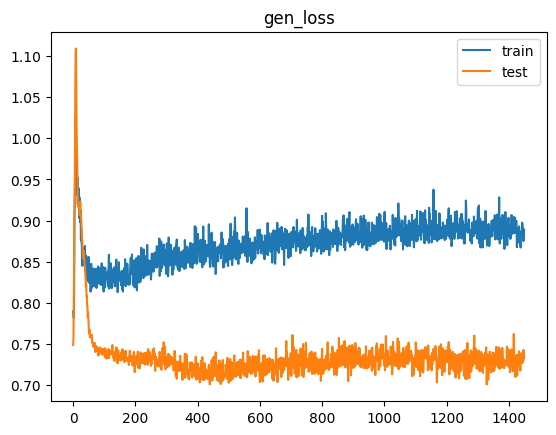

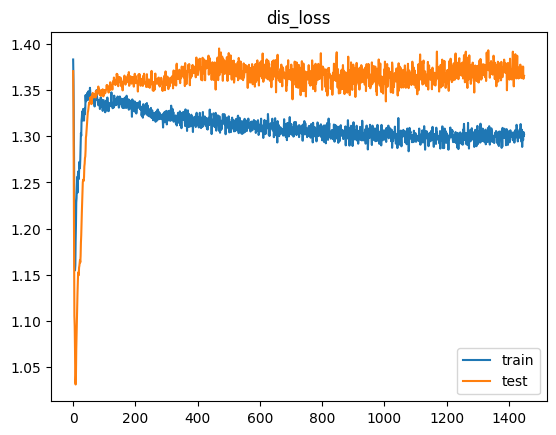

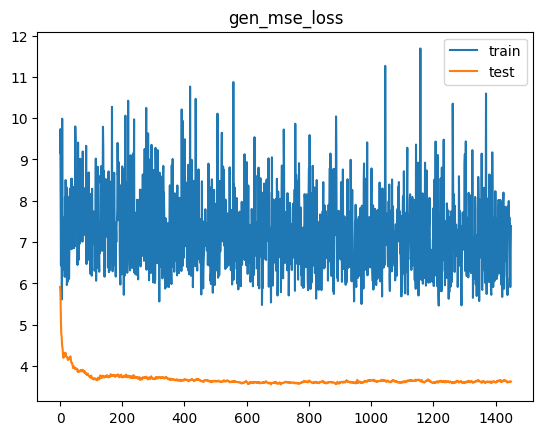

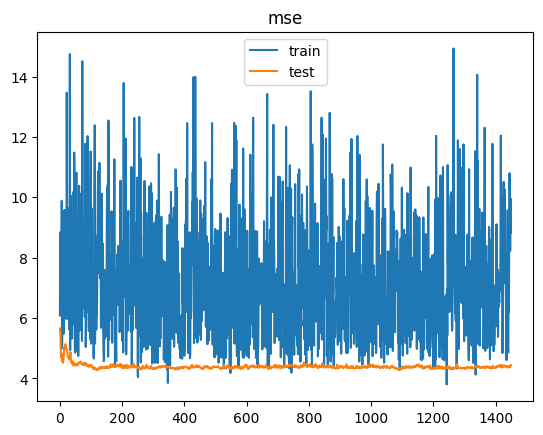

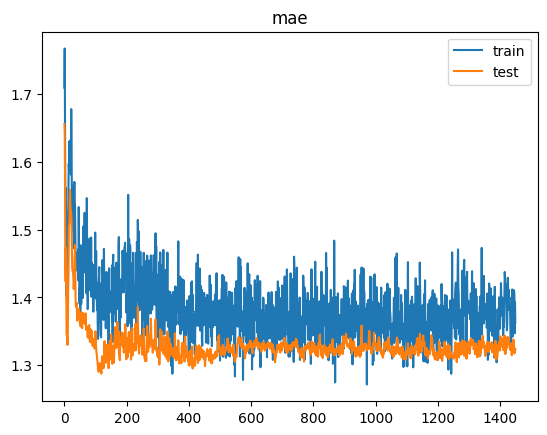

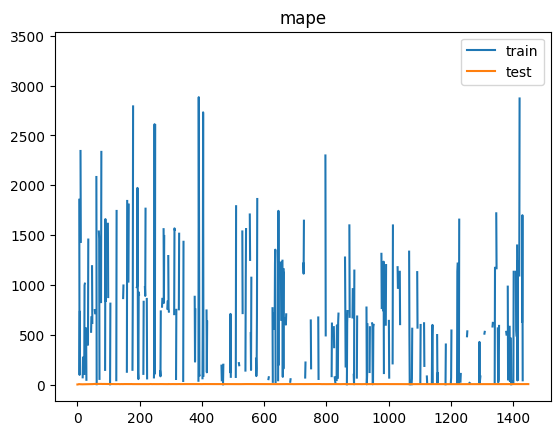

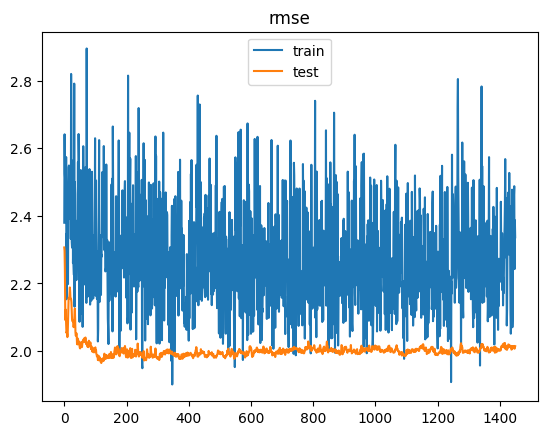

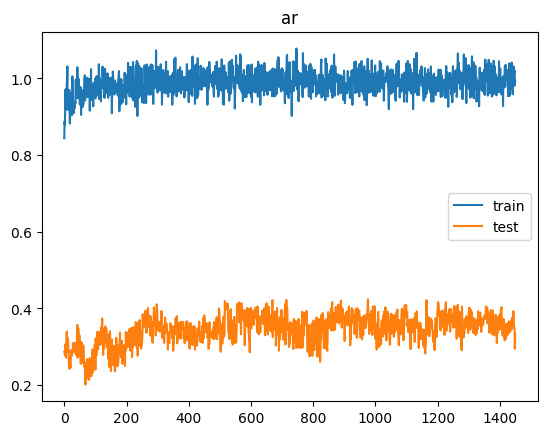

2/2 [==============================] - 1s 7ms/step


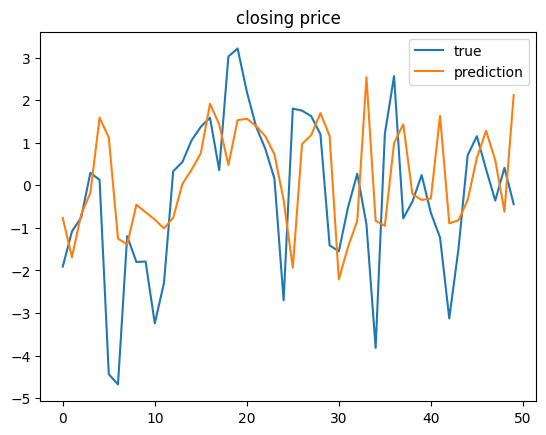

[MSE Baseline] train: 13.727391245058596  test: 4.18451216814071
Delta time with epochs = 1450: 0:27:29.042825
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 5, 20)       1440        ['input_7[0][0]']                
 l)                                                                                               
                                                                                                  
 concatenate_6 (Concatenate)    (None, 5, 27)        0           ['bidirectional_12[0][0]',       
                                                                  'input_7[0][0]

Time for epoch 46 is 1.2569622993469238 sec Generator Loss: 0.8596649169921875,  Discriminator_loss: 1.3086756467819214
Time for epoch 47 is 1.251199722290039 sec Generator Loss: 0.862750232219696,  Discriminator_loss: 1.305891752243042
Time for epoch 48 is 1.2838613986968994 sec Generator Loss: 0.8677235245704651,  Discriminator_loss: 1.310980200767517
Time for epoch 49 is 1.2614691257476807 sec Generator Loss: 0.8479745984077454,  Discriminator_loss: 1.3096306324005127
Time for epoch 50 is 1.2551705837249756 sec Generator Loss: 0.8518553972244263,  Discriminator_loss: 1.3085741996765137
Time for epoch 51 is 1.279585599899292 sec Generator Loss: 0.8529639840126038,  Discriminator_loss: 1.3120020627975464
Time for epoch 52 is 1.2542955875396729 sec Generator Loss: 0.8386631011962891,  Discriminator_loss: 1.3360378742218018
Time for epoch 53 is 1.24666428565979 sec Generator Loss: 0.8386396169662476,  Discriminator_loss: 1.33565354347229
Time for epoch 54 is 1.3078043460845947 sec Gener

Time for epoch 115 is 1.2400095462799072 sec Generator Loss: 0.8196807503700256,  Discriminator_loss: 1.3341585397720337
Time for epoch 116 is 1.2021160125732422 sec Generator Loss: 0.8370078206062317,  Discriminator_loss: 1.3300118446350098
Time for epoch 117 is 1.1907293796539307 sec Generator Loss: 0.8289310932159424,  Discriminator_loss: 1.3291215896606445
Time for epoch 118 is 1.1790797710418701 sec Generator Loss: 0.8464896082878113,  Discriminator_loss: 1.3292007446289062
Time for epoch 119 is 1.1967368125915527 sec Generator Loss: 0.8269668221473694,  Discriminator_loss: 1.328587532043457
Time for epoch 120 is 1.1974389553070068 sec Generator Loss: 0.8223299384117126,  Discriminator_loss: 1.332383632659912
Time for epoch 121 is 1.2113101482391357 sec Generator Loss: 0.8304817080497742,  Discriminator_loss: 1.3308519124984741
Time for epoch 122 is 1.1995680332183838 sec Generator Loss: 0.8318793177604675,  Discriminator_loss: 1.3285515308380127
Time for epoch 123 is 1.2074167728

Time for epoch 184 is 1.3017914295196533 sec Generator Loss: 0.8284916877746582,  Discriminator_loss: 1.334912657737732
Time for epoch 185 is 1.2925946712493896 sec Generator Loss: 0.8114326596260071,  Discriminator_loss: 1.3374985456466675
Time for epoch 186 is 1.2703566551208496 sec Generator Loss: 0.8249819278717041,  Discriminator_loss: 1.327350378036499
Time for epoch 187 is 1.2777328491210938 sec Generator Loss: 0.8388850092887878,  Discriminator_loss: 1.3276758193969727
Time for epoch 188 is 1.2920994758605957 sec Generator Loss: 0.8278903961181641,  Discriminator_loss: 1.3349789381027222
Time for epoch 189 is 1.2770121097564697 sec Generator Loss: 0.8435506820678711,  Discriminator_loss: 1.32891047000885
Time for epoch 190 is 1.2568082809448242 sec Generator Loss: 0.8288047909736633,  Discriminator_loss: 1.33790123462677
Time for epoch 191 is 1.2915771007537842 sec Generator Loss: 0.8319053053855896,  Discriminator_loss: 1.3338606357574463
Time for epoch 192 is 1.29966711997985

Time for epoch 253 is 1.2797231674194336 sec Generator Loss: 0.8256151676177979,  Discriminator_loss: 1.333349585533142
Time for epoch 254 is 1.258601188659668 sec Generator Loss: 0.8286557793617249,  Discriminator_loss: 1.329168677330017
Time for epoch 255 is 1.293257236480713 sec Generator Loss: 0.806666374206543,  Discriminator_loss: 1.3407771587371826
Time for epoch 256 is 1.272082805633545 sec Generator Loss: 0.8284080028533936,  Discriminator_loss: 1.3317883014678955
Time for epoch 257 is 1.2702867984771729 sec Generator Loss: 0.8147273659706116,  Discriminator_loss: 1.3387292623519897
Time for epoch 258 is 1.31111741065979 sec Generator Loss: 0.8486940264701843,  Discriminator_loss: 1.3303316831588745
Time for epoch 259 is 1.2923450469970703 sec Generator Loss: 0.8683974742889404,  Discriminator_loss: 1.3271554708480835
Time for epoch 260 is 1.2542970180511475 sec Generator Loss: 0.8294869065284729,  Discriminator_loss: 1.3346774578094482
Time for epoch 261 is 1.2757911682128906

Time for epoch 322 is 1.2734041213989258 sec Generator Loss: 0.84962397813797,  Discriminator_loss: 1.3273909091949463
Time for epoch 323 is 1.2836451530456543 sec Generator Loss: 0.8385062217712402,  Discriminator_loss: 1.3255810737609863
Time for epoch 324 is 1.2919318675994873 sec Generator Loss: 0.8281097412109375,  Discriminator_loss: 1.3269387483596802
Time for epoch 325 is 1.2547025680541992 sec Generator Loss: 0.8372753858566284,  Discriminator_loss: 1.3269742727279663
Time for epoch 326 is 1.2877256870269775 sec Generator Loss: 0.8338552713394165,  Discriminator_loss: 1.3260350227355957
Time for epoch 327 is 1.2801997661590576 sec Generator Loss: 0.8448942303657532,  Discriminator_loss: 1.3261079788208008
Time for epoch 328 is 1.2893879413604736 sec Generator Loss: 0.8373561501502991,  Discriminator_loss: 1.3306714296340942
Time for epoch 329 is 1.281006097793579 sec Generator Loss: 0.8381949067115784,  Discriminator_loss: 1.3240222930908203
Time for epoch 330 is 1.29043984413

Time for epoch 391 is 1.3120906352996826 sec Generator Loss: 0.8541972637176514,  Discriminator_loss: 1.3251200914382935
Time for epoch 392 is 1.2689611911773682 sec Generator Loss: 0.8510887026786804,  Discriminator_loss: 1.3141412734985352
Time for epoch 393 is 1.299659013748169 sec Generator Loss: 0.8673091530799866,  Discriminator_loss: 1.3177579641342163
Time for epoch 394 is 1.2921745777130127 sec Generator Loss: 0.8631137609481812,  Discriminator_loss: 1.3151241540908813
Time for epoch 395 is 1.287541151046753 sec Generator Loss: 0.8900416493415833,  Discriminator_loss: 1.3224530220031738
Time for epoch 396 is 1.3007478713989258 sec Generator Loss: 0.8486522436141968,  Discriminator_loss: 1.3151111602783203
Time for epoch 397 is 1.303361415863037 sec Generator Loss: 0.8348168134689331,  Discriminator_loss: 1.3288874626159668
Time for epoch 398 is 1.2838056087493896 sec Generator Loss: 0.8493558168411255,  Discriminator_loss: 1.3188849687576294
Time for epoch 399 is 1.28672742843

Time for epoch 459 is 1.335364580154419 sec Generator Loss: 0.8457360863685608,  Discriminator_loss: 1.3192057609558105
Time for epoch 460 is 1.3205335140228271 sec Generator Loss: 0.8357164859771729,  Discriminator_loss: 1.3299500942230225
Time for epoch 461 is 1.320317029953003 sec Generator Loss: 0.8739138841629028,  Discriminator_loss: 1.3163020610809326
Time for epoch 462 is 1.3190248012542725 sec Generator Loss: 0.8462156057357788,  Discriminator_loss: 1.3267587423324585
Time for epoch 463 is 1.329721212387085 sec Generator Loss: 0.8540062308311462,  Discriminator_loss: 1.316530466079712
Time for epoch 464 is 1.3188519477844238 sec Generator Loss: 0.8451632261276245,  Discriminator_loss: 1.3133344650268555
Time for epoch 465 is 1.3235740661621094 sec Generator Loss: 0.8573392629623413,  Discriminator_loss: 1.316222906112671
Time for epoch 466 is 1.3653144836425781 sec Generator Loss: 0.8481544256210327,  Discriminator_loss: 1.3146039247512817
Time for epoch 467 is 1.3030095100402

Time for epoch 527 is 1.5364389419555664 sec Generator Loss: 0.8848273158073425,  Discriminator_loss: 1.313058853149414
Time for epoch 528 is 1.4665942192077637 sec Generator Loss: 0.841702401638031,  Discriminator_loss: 1.3092375993728638
Time for epoch 529 is 1.504086971282959 sec Generator Loss: 0.8723655343055725,  Discriminator_loss: 1.3113188743591309
Time for epoch 530 is 1.6659252643585205 sec Generator Loss: 0.855905294418335,  Discriminator_loss: 1.3220362663269043
Time for epoch 531 is 1.781106948852539 sec Generator Loss: 0.8493427038192749,  Discriminator_loss: 1.3203502893447876
Time for epoch 532 is 1.6849768161773682 sec Generator Loss: 0.8560302257537842,  Discriminator_loss: 1.3174656629562378
Time for epoch 533 is 2.1928694248199463 sec Generator Loss: 0.8564525246620178,  Discriminator_loss: 1.3225321769714355
Time for epoch 534 is 1.642054796218872 sec Generator Loss: 0.8611793518066406,  Discriminator_loss: 1.317070722579956
Time for epoch 535 is 1.669839143753051

Time for epoch 596 is 1.6104731559753418 sec Generator Loss: 0.855958878993988,  Discriminator_loss: 1.3185429573059082
Time for epoch 597 is 1.6378064155578613 sec Generator Loss: 0.8623263239860535,  Discriminator_loss: 1.308068871498108
Time for epoch 598 is 1.646399736404419 sec Generator Loss: 0.8481553196907043,  Discriminator_loss: 1.3183070421218872
Time for epoch 599 is 1.8233482837677002 sec Generator Loss: 0.8686410188674927,  Discriminator_loss: 1.3111581802368164
Time for epoch 600 is 1.589918613433838 sec Generator Loss: 0.8610460162162781,  Discriminator_loss: 1.3086925745010376
Time for epoch 601 is 1.5859103202819824 sec Generator Loss: 0.8488246202468872,  Discriminator_loss: 1.3169691562652588
Time for epoch 602 is 1.5359067916870117 sec Generator Loss: 0.8761364817619324,  Discriminator_loss: 1.3122588396072388
Time for epoch 603 is 1.7147912979125977 sec Generator Loss: 0.8710052371025085,  Discriminator_loss: 1.309227466583252
Time for epoch 604 is 1.5909111499786

Time for epoch 665 is 1.4732341766357422 sec Generator Loss: 0.8598636984825134,  Discriminator_loss: 1.3163995742797852
Time for epoch 666 is 1.488996982574463 sec Generator Loss: 0.8625136613845825,  Discriminator_loss: 1.3184144496917725
Time for epoch 667 is 1.441429853439331 sec Generator Loss: 0.8670191764831543,  Discriminator_loss: 1.3099831342697144
Time for epoch 668 is 1.4649899005889893 sec Generator Loss: 0.8881142735481262,  Discriminator_loss: 1.3056342601776123
Time for epoch 669 is 1.5948526859283447 sec Generator Loss: 0.8746840357780457,  Discriminator_loss: 1.308975100517273
Time for epoch 670 is 1.5071563720703125 sec Generator Loss: 0.8557349443435669,  Discriminator_loss: 1.3075168132781982
Time for epoch 671 is 1.482452154159546 sec Generator Loss: 0.8833535313606262,  Discriminator_loss: 1.3128365278244019
Time for epoch 672 is 1.473982334136963 sec Generator Loss: 0.8480883836746216,  Discriminator_loss: 1.3188104629516602
Time for epoch 673 is 1.4989089965820

Time for epoch 734 is 1.5412743091583252 sec Generator Loss: 0.8650035858154297,  Discriminator_loss: 1.3078410625457764
Time for epoch 735 is 1.6320054531097412 sec Generator Loss: 0.8604293465614319,  Discriminator_loss: 1.3199493885040283
Time for epoch 736 is 1.6789355278015137 sec Generator Loss: 0.851498007774353,  Discriminator_loss: 1.3154023885726929
Time for epoch 737 is 1.6424493789672852 sec Generator Loss: 0.8622405529022217,  Discriminator_loss: 1.3128734827041626
Time for epoch 738 is 1.9239087104797363 sec Generator Loss: 0.8864345550537109,  Discriminator_loss: 1.3049414157867432
Time for epoch 739 is 1.910632848739624 sec Generator Loss: 0.8545064926147461,  Discriminator_loss: 1.3107692003250122
Time for epoch 740 is 1.6878364086151123 sec Generator Loss: 0.8619808554649353,  Discriminator_loss: 1.3136926889419556
Time for epoch 741 is 1.5225510597229004 sec Generator Loss: 0.8689688444137573,  Discriminator_loss: 1.3091881275177002
Time for epoch 742 is 1.7246162891

Time for epoch 803 is 1.7235758304595947 sec Generator Loss: 0.8582615256309509,  Discriminator_loss: 1.3121720552444458
Time for epoch 804 is 1.7050871849060059 sec Generator Loss: 0.8636131882667542,  Discriminator_loss: 1.3138558864593506
Time for epoch 805 is 2.0268917083740234 sec Generator Loss: 0.8698890805244446,  Discriminator_loss: 1.3080981969833374
Time for epoch 806 is 1.6326756477355957 sec Generator Loss: 0.8481629490852356,  Discriminator_loss: 1.321524977684021
Time for epoch 807 is 1.613039255142212 sec Generator Loss: 0.8641206622123718,  Discriminator_loss: 1.3067383766174316
Time for epoch 808 is 1.7340171337127686 sec Generator Loss: 0.8691155910491943,  Discriminator_loss: 1.305167317390442
Time for epoch 809 is 1.6491119861602783 sec Generator Loss: 0.8802347183227539,  Discriminator_loss: 1.3079153299331665
Time for epoch 810 is 1.7471332550048828 sec Generator Loss: 0.8803972005844116,  Discriminator_loss: 1.3103902339935303
Time for epoch 811 is 1.62727546691

Time for epoch 872 is 1.6927073001861572 sec Generator Loss: 0.8848550319671631,  Discriminator_loss: 1.3094154596328735
Time for epoch 873 is 1.7504100799560547 sec Generator Loss: 0.884320855140686,  Discriminator_loss: 1.3122718334197998
Time for epoch 874 is 1.8615000247955322 sec Generator Loss: 0.8880096673965454,  Discriminator_loss: 1.3007214069366455
Time for epoch 875 is 1.7292780876159668 sec Generator Loss: 0.8658930659294128,  Discriminator_loss: 1.3048914670944214
Time for epoch 876 is 1.631566047668457 sec Generator Loss: 0.8829213380813599,  Discriminator_loss: 1.307848572731018
Time for epoch 877 is 1.6528308391571045 sec Generator Loss: 0.8689991235733032,  Discriminator_loss: 1.3098300695419312
Time for epoch 878 is 1.6350514888763428 sec Generator Loss: 0.8660237193107605,  Discriminator_loss: 1.3077657222747803
Time for epoch 879 is 1.6545722484588623 sec Generator Loss: 0.8695897459983826,  Discriminator_loss: 1.3195850849151611
Time for epoch 880 is 1.64173889160

Time for epoch 941 is 1.723400354385376 sec Generator Loss: 0.8898569345474243,  Discriminator_loss: 1.2997443675994873
Time for epoch 942 is 1.6110951900482178 sec Generator Loss: 0.8659178614616394,  Discriminator_loss: 1.3115195035934448
Time for epoch 943 is 1.6596744060516357 sec Generator Loss: 0.8728887438774109,  Discriminator_loss: 1.307262659072876
Time for epoch 944 is 1.6595580577850342 sec Generator Loss: 0.8767479062080383,  Discriminator_loss: 1.307607650756836
Time for epoch 945 is 1.6476247310638428 sec Generator Loss: 0.8803777694702148,  Discriminator_loss: 1.3033161163330078
Time for epoch 946 is 1.6756513118743896 sec Generator Loss: 0.8756920099258423,  Discriminator_loss: 1.3116658926010132
Time for epoch 947 is 1.8891170024871826 sec Generator Loss: 0.8862389326095581,  Discriminator_loss: 1.3139086961746216
Time for epoch 948 is 1.7563846111297607 sec Generator Loss: 0.8693027496337891,  Discriminator_loss: 1.301369309425354
Time for epoch 949 is 1.634140729904

In [ ]:
for epochs in [200, 450, 700, 950, 1200, 1450, 1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("dcbilstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_14 (Bidirectiona  (None, 5, 20)       1440        ['input_8[0][0]']                
 l)                                                                                               
                                                                                                  
 concatenate_7 (Concatenate)    (None, 5, 27)        0           ['bidirectional_14[0][0]',       
                                                                  'input_8[0][0]']                
                                                                                            

Time for epoch 47 is 1.8372883796691895 sec Generator Loss: 0.8525853157043457,  Discriminator_loss: 1.3364092111587524
Time for epoch 48 is 1.8129158020019531 sec Generator Loss: 0.8429157137870789,  Discriminator_loss: 1.3254858255386353
Time for epoch 49 is 1.7300426959991455 sec Generator Loss: 0.8635560274124146,  Discriminator_loss: 1.3323081731796265
Time for epoch 50 is 1.7556142807006836 sec Generator Loss: 0.8607726097106934,  Discriminator_loss: 1.3335936069488525
Time for epoch 51 is 1.7894814014434814 sec Generator Loss: 0.8399694561958313,  Discriminator_loss: 1.3284696340560913
Time for epoch 52 is 1.7019774913787842 sec Generator Loss: 0.8755894303321838,  Discriminator_loss: 1.3264551162719727
Time for epoch 53 is 1.769545316696167 sec Generator Loss: 0.8317845463752747,  Discriminator_loss: 1.3378204107284546
Time for epoch 54 is 1.7232184410095215 sec Generator Loss: 0.8437902331352234,  Discriminator_loss: 1.3268029689788818
Time for epoch 55 is 1.6828064918518066 s

Time for epoch 116 is 1.89674973487854 sec Generator Loss: 0.8377379179000854,  Discriminator_loss: 1.335148811340332
Time for epoch 117 is 1.7357990741729736 sec Generator Loss: 0.835166871547699,  Discriminator_loss: 1.3372453451156616
Time for epoch 118 is 1.7095861434936523 sec Generator Loss: 0.8477967381477356,  Discriminator_loss: 1.3312315940856934
Time for epoch 119 is 1.7447929382324219 sec Generator Loss: 0.8477209210395813,  Discriminator_loss: 1.3299905061721802
Time for epoch 120 is 2.079343557357788 sec Generator Loss: 0.8388811349868774,  Discriminator_loss: 1.332676649093628
Time for epoch 121 is 2.0111677646636963 sec Generator Loss: 0.8440901637077332,  Discriminator_loss: 1.3329170942306519
Time for epoch 122 is 2.081326484680176 sec Generator Loss: 0.8358370661735535,  Discriminator_loss: 1.3321632146835327
Time for epoch 123 is 2.085418939590454 sec Generator Loss: 0.8296994566917419,  Discriminator_loss: 1.3358274698257446
Time for epoch 124 is 2.121495246887207 

Time for epoch 185 is 1.8483784198760986 sec Generator Loss: 0.8383204936981201,  Discriminator_loss: 1.3380178213119507
Time for epoch 186 is 1.9468226432800293 sec Generator Loss: 0.8338529467582703,  Discriminator_loss: 1.3340650796890259
Time for epoch 187 is 1.815636396408081 sec Generator Loss: 0.828477144241333,  Discriminator_loss: 1.3387166261672974
Time for epoch 188 is 1.8660681247711182 sec Generator Loss: 0.8485363125801086,  Discriminator_loss: 1.3316272497177124
Time for epoch 189 is 1.8079588413238525 sec Generator Loss: 0.8402853012084961,  Discriminator_loss: 1.340455174446106
Time for epoch 190 is 1.7380554676055908 sec Generator Loss: 0.8402763605117798,  Discriminator_loss: 1.341104507446289
Time for epoch 191 is 1.85606050491333 sec Generator Loss: 0.8367714881896973,  Discriminator_loss: 1.3388795852661133
Time for epoch 192 is 1.9282233715057373 sec Generator Loss: 0.8648344874382019,  Discriminator_loss: 1.3390724658966064
Time for epoch 193 is 1.86686182022094

Time for epoch 253 is 1.8286302089691162 sec Generator Loss: 0.8472260236740112,  Discriminator_loss: 1.332392692565918
Time for epoch 254 is 1.8299496173858643 sec Generator Loss: 0.8356560468673706,  Discriminator_loss: 1.3283740282058716
Time for epoch 255 is 2.1596503257751465 sec Generator Loss: 0.8330448269844055,  Discriminator_loss: 1.3433139324188232
Time for epoch 256 is 2.262408971786499 sec Generator Loss: 0.8569746613502502,  Discriminator_loss: 1.3224422931671143
Time for epoch 257 is 2.1194348335266113 sec Generator Loss: 0.8398725390434265,  Discriminator_loss: 1.3318182229995728
Time for epoch 258 is 1.873960256576538 sec Generator Loss: 0.8428854942321777,  Discriminator_loss: 1.3256592750549316
Time for epoch 259 is 2.246107339859009 sec Generator Loss: 0.8372217416763306,  Discriminator_loss: 1.331278920173645
Time for epoch 260 is 1.964359998703003 sec Generator Loss: 0.8566868305206299,  Discriminator_loss: 1.3271597623825073
Time for epoch 261 is 1.81737518310546

Time for epoch 322 is 1.847168207168579 sec Generator Loss: 0.8780520558357239,  Discriminator_loss: 1.323261022567749
Time for epoch 323 is 1.9304563999176025 sec Generator Loss: 0.8728841543197632,  Discriminator_loss: 1.3267780542373657
Time for epoch 324 is 2.0334577560424805 sec Generator Loss: 0.8512660264968872,  Discriminator_loss: 1.3236578702926636
Time for epoch 325 is 1.9171514511108398 sec Generator Loss: 0.8488593697547913,  Discriminator_loss: 1.3282166719436646
Time for epoch 326 is 2.1277823448181152 sec Generator Loss: 0.8575956225395203,  Discriminator_loss: 1.3262020349502563
Time for epoch 327 is 1.9093899726867676 sec Generator Loss: 0.8748850226402283,  Discriminator_loss: 1.3202303647994995
Time for epoch 328 is 2.0758063793182373 sec Generator Loss: 0.8420222401618958,  Discriminator_loss: 1.319261908531189
Time for epoch 329 is 2.2458386421203613 sec Generator Loss: 0.8347046971321106,  Discriminator_loss: 1.3229219913482666
Time for epoch 330 is 2.01025795936

Time for epoch 391 is 1.9766595363616943 sec Generator Loss: 0.8515954613685608,  Discriminator_loss: 1.3186980485916138
Time for epoch 392 is 2.3610215187072754 sec Generator Loss: 0.8592801690101624,  Discriminator_loss: 1.319421648979187
Time for epoch 393 is 1.9277219772338867 sec Generator Loss: 0.8459275960922241,  Discriminator_loss: 1.3182750940322876
Time for epoch 394 is 1.9201405048370361 sec Generator Loss: 0.8679657578468323,  Discriminator_loss: 1.3170607089996338
Time for epoch 395 is 2.16391921043396 sec Generator Loss: 0.8632516860961914,  Discriminator_loss: 1.3184762001037598
Time for epoch 396 is 1.9900751113891602 sec Generator Loss: 0.8660094738006592,  Discriminator_loss: 1.3158048391342163
Time for epoch 397 is 2.4461867809295654 sec Generator Loss: 0.8623352646827698,  Discriminator_loss: 1.3169078826904297
Time for epoch 398 is 2.294884443283081 sec Generator Loss: 0.8546303510665894,  Discriminator_loss: 1.323626160621643
Time for epoch 399 is 1.8934731483459

Time for epoch 460 is 1.9143931865692139 sec Generator Loss: 0.8600590229034424,  Discriminator_loss: 1.3165749311447144
Time for epoch 461 is 1.852362871170044 sec Generator Loss: 0.8718063235282898,  Discriminator_loss: 1.3186781406402588
Time for epoch 462 is 1.86085844039917 sec Generator Loss: 0.8671161532402039,  Discriminator_loss: 1.3149683475494385
Time for epoch 463 is 1.926802158355713 sec Generator Loss: 0.8711841702461243,  Discriminator_loss: 1.325235366821289
Time for epoch 464 is 1.8782548904418945 sec Generator Loss: 0.870087206363678,  Discriminator_loss: 1.3152371644973755
Time for epoch 465 is 1.874422550201416 sec Generator Loss: 0.8702808022499084,  Discriminator_loss: 1.3233230113983154
Time for epoch 466 is 1.8861005306243896 sec Generator Loss: 0.8477169871330261,  Discriminator_loss: 1.322425365447998
Time for epoch 467 is 1.8704698085784912 sec Generator Loss: 0.8676877617835999,  Discriminator_loss: 1.3092985153198242
Time for epoch 468 is 1.8708467483520508

Time for epoch 529 is 1.9633042812347412 sec Generator Loss: 0.8707691431045532,  Discriminator_loss: 1.3115037679672241
Time for epoch 530 is 1.932227373123169 sec Generator Loss: 0.8537403345108032,  Discriminator_loss: 1.3141344785690308
Time for epoch 531 is 1.9320921897888184 sec Generator Loss: 0.8497813940048218,  Discriminator_loss: 1.3167369365692139
Time for epoch 532 is 1.9380416870117188 sec Generator Loss: 0.8649172782897949,  Discriminator_loss: 1.3201059103012085
Time for epoch 533 is 1.875535488128662 sec Generator Loss: 0.853848934173584,  Discriminator_loss: 1.3253834247589111
Time for epoch 534 is 2.03940486907959 sec Generator Loss: 0.8646128177642822,  Discriminator_loss: 1.3155781030654907
Time for epoch 535 is 2.014979362487793 sec Generator Loss: 0.8783081769943237,  Discriminator_loss: 1.2995994091033936
Time for epoch 536 is 2.0480194091796875 sec Generator Loss: 0.8511974811553955,  Discriminator_loss: 1.3167686462402344
Time for epoch 537 is 2.00461244583129

Time for epoch 598 is 1.9570839405059814 sec Generator Loss: 0.8720759749412537,  Discriminator_loss: 1.318849802017212
Time for epoch 599 is 2.0209219455718994 sec Generator Loss: 0.8715023398399353,  Discriminator_loss: 1.3033154010772705
Time for epoch 600 is 1.9688146114349365 sec Generator Loss: 0.8713080883026123,  Discriminator_loss: 1.3122502565383911
Time for epoch 601 is 2.101475238800049 sec Generator Loss: 0.8704929351806641,  Discriminator_loss: 1.3116874694824219
Time for epoch 602 is 2.1387593746185303 sec Generator Loss: 0.8746888041496277,  Discriminator_loss: 1.3104931116104126
Time for epoch 603 is 2.09171199798584 sec Generator Loss: 0.8560252785682678,  Discriminator_loss: 1.320474624633789
Time for epoch 604 is 2.2039647102355957 sec Generator Loss: 0.8780137300491333,  Discriminator_loss: 1.3016061782836914
Time for epoch 605 is 2.1022796630859375 sec Generator Loss: 0.8933758735656738,  Discriminator_loss: 1.3087056875228882
Time for epoch 606 is 2.2384617328643

Time for epoch 667 is 1.9319539070129395 sec Generator Loss: 0.8560342788696289,  Discriminator_loss: 1.3118970394134521
Time for epoch 668 is 1.9568097591400146 sec Generator Loss: 0.8835434913635254,  Discriminator_loss: 1.3105610609054565
Time for epoch 669 is 1.9927520751953125 sec Generator Loss: 0.8999298810958862,  Discriminator_loss: 1.300780177116394
Time for epoch 670 is 1.9807639122009277 sec Generator Loss: 0.8681166172027588,  Discriminator_loss: 1.3192299604415894
Time for epoch 671 is 1.9886174201965332 sec Generator Loss: 0.885555624961853,  Discriminator_loss: 1.318575382232666
Time for epoch 672 is 2.0033698081970215 sec Generator Loss: 0.8781585693359375,  Discriminator_loss: 1.303748369216919
Time for epoch 673 is 1.98258638381958 sec Generator Loss: 0.875173032283783,  Discriminator_loss: 1.307636022567749
Time for epoch 674 is 1.9951186180114746 sec Generator Loss: 0.8902550935745239,  Discriminator_loss: 1.3033219575881958
Time for epoch 675 is 1.9411144256591797

Time for epoch 736 is 2.188795328140259 sec Generator Loss: 0.8524451851844788,  Discriminator_loss: 1.326155662536621
Time for epoch 737 is 2.1233904361724854 sec Generator Loss: 0.8689975738525391,  Discriminator_loss: 1.3114453554153442
Time for epoch 738 is 2.0529727935791016 sec Generator Loss: 0.878574550151825,  Discriminator_loss: 1.3220038414001465
Time for epoch 739 is 2.1539793014526367 sec Generator Loss: 0.8547194004058838,  Discriminator_loss: 1.3191685676574707
Time for epoch 740 is 2.149472951889038 sec Generator Loss: 0.8629943132400513,  Discriminator_loss: 1.3130472898483276
Time for epoch 741 is 2.1267294883728027 sec Generator Loss: 0.876103937625885,  Discriminator_loss: 1.304026484489441
Time for epoch 742 is 2.2434868812561035 sec Generator Loss: 0.866568386554718,  Discriminator_loss: 1.3137258291244507
Time for epoch 743 is 1.9886395931243896 sec Generator Loss: 0.886913537979126,  Discriminator_loss: 1.3108373880386353
Time for epoch 744 is 2.019066333770752 

Time for epoch 805 is 2.0742759704589844 sec Generator Loss: 0.8560914993286133,  Discriminator_loss: 1.3176040649414062
Time for epoch 806 is 2.1959595680236816 sec Generator Loss: 0.8618716597557068,  Discriminator_loss: 1.3163659572601318
Time for epoch 807 is 2.2747867107391357 sec Generator Loss: 0.8849392533302307,  Discriminator_loss: 1.312068223953247
Time for epoch 808 is 2.1740365028381348 sec Generator Loss: 0.8705763220787048,  Discriminator_loss: 1.3163107633590698
Time for epoch 809 is 1.7611281871795654 sec Generator Loss: 0.8770543932914734,  Discriminator_loss: 1.313427209854126
Time for epoch 810 is 1.9192590713500977 sec Generator Loss: 0.8711079359054565,  Discriminator_loss: 1.3087507486343384
Time for epoch 811 is 2.0702924728393555 sec Generator Loss: 0.8669532537460327,  Discriminator_loss: 1.3106268644332886
Time for epoch 812 is 2.0351459980010986 sec Generator Loss: 0.8821877241134644,  Discriminator_loss: 1.307454228401184
Time for epoch 813 is 1.90968656539

Time for epoch 874 is 2.0432398319244385 sec Generator Loss: 0.8659070730209351,  Discriminator_loss: 1.3123469352722168
Time for epoch 875 is 1.9302358627319336 sec Generator Loss: 0.8750128149986267,  Discriminator_loss: 1.3205981254577637
Time for epoch 876 is 2.0876779556274414 sec Generator Loss: 0.8835300207138062,  Discriminator_loss: 1.3127503395080566
Time for epoch 877 is 2.053797960281372 sec Generator Loss: 0.8870190382003784,  Discriminator_loss: 1.303339958190918
Time for epoch 878 is 2.0578737258911133 sec Generator Loss: 0.8717066049575806,  Discriminator_loss: 1.3129023313522339
Time for epoch 879 is 2.149564743041992 sec Generator Loss: 0.8938755393028259,  Discriminator_loss: 1.3107831478118896
Time for epoch 880 is 2.0972561836242676 sec Generator Loss: 0.8620249629020691,  Discriminator_loss: 1.3225089311599731
Time for epoch 881 is 2.1099894046783447 sec Generator Loss: 0.8907760381698608,  Discriminator_loss: 1.3066701889038086
Time for epoch 882 is 2.13976287841

Time for epoch 943 is 2.1756207942962646 sec Generator Loss: 0.8838148713111877,  Discriminator_loss: 1.3190464973449707
Time for epoch 944 is 2.127890110015869 sec Generator Loss: 0.8600820302963257,  Discriminator_loss: 1.3167716264724731
Time for epoch 945 is 2.1769700050354004 sec Generator Loss: 0.871880829334259,  Discriminator_loss: 1.3163291215896606
Time for epoch 946 is 2.211867094039917 sec Generator Loss: 0.8705074787139893,  Discriminator_loss: 1.3197927474975586
Time for epoch 947 is 2.189668655395508 sec Generator Loss: 0.8652802109718323,  Discriminator_loss: 1.321713924407959
Time for epoch 948 is 2.1246755123138428 sec Generator Loss: 0.8624244332313538,  Discriminator_loss: 1.3126065731048584
Time for epoch 949 is 2.1344683170318604 sec Generator Loss: 0.8707425594329834,  Discriminator_loss: 1.3138960599899292
Time for epoch 950 is 2.1629080772399902 sec Generator Loss: 0.882886528968811,  Discriminator_loss: 1.3085564374923706
Time for epoch 951 is 1.96323394775390

Time for epoch 1012 is 2.1860105991363525 sec Generator Loss: 0.8875611424446106,  Discriminator_loss: 1.302864670753479
Time for epoch 1013 is 2.179389238357544 sec Generator Loss: 0.8792707920074463,  Discriminator_loss: 1.3089892864227295
Time for epoch 1014 is 2.3441669940948486 sec Generator Loss: 0.862806499004364,  Discriminator_loss: 1.3164238929748535
Time for epoch 1015 is 2.2291975021362305 sec Generator Loss: 0.8630768060684204,  Discriminator_loss: 1.3092663288116455
Time for epoch 1016 is 2.315803289413452 sec Generator Loss: 0.8764523267745972,  Discriminator_loss: 1.3096219301223755
Time for epoch 1017 is 2.2665932178497314 sec Generator Loss: 0.864716649055481,  Discriminator_loss: 1.3253241777420044
Time for epoch 1018 is 2.336845636367798 sec Generator Loss: 0.8635601997375488,  Discriminator_loss: 1.3196728229522705
Time for epoch 1019 is 2.268537998199463 sec Generator Loss: 0.8672438263893127,  Discriminator_loss: 1.31416916847229
Time for epoch 1020 is 2.19549131

Time for epoch 1080 is 2.2200264930725098 sec Generator Loss: 0.8921520709991455,  Discriminator_loss: 1.310386300086975
Time for epoch 1081 is 2.1405999660491943 sec Generator Loss: 0.865123450756073,  Discriminator_loss: 1.318456768989563
Time for epoch 1082 is 2.1771838665008545 sec Generator Loss: 0.8869709968566895,  Discriminator_loss: 1.3139457702636719
Time for epoch 1083 is 2.2352983951568604 sec Generator Loss: 0.8901975154876709,  Discriminator_loss: 1.314576506614685
Time for epoch 1084 is 2.173248767852783 sec Generator Loss: 0.9038462042808533,  Discriminator_loss: 1.3102781772613525
Time for epoch 1085 is 2.158109426498413 sec Generator Loss: 0.8619282245635986,  Discriminator_loss: 1.3118783235549927
Time for epoch 1086 is 2.1710033416748047 sec Generator Loss: 0.8613820672035217,  Discriminator_loss: 1.3141953945159912
Time for epoch 1087 is 2.198164939880371 sec Generator Loss: 0.9027611613273621,  Discriminator_loss: 1.3097310066223145
Time for epoch 1088 is 2.179978

Time for epoch 1148 is 2.4028830528259277 sec Generator Loss: 0.8708286881446838,  Discriminator_loss: 1.3089057207107544
Time for epoch 1149 is 2.3395638465881348 sec Generator Loss: 0.8769663572311401,  Discriminator_loss: 1.3100906610488892
Time for epoch 1150 is 2.306354522705078 sec Generator Loss: 0.8734371662139893,  Discriminator_loss: 1.3055859804153442
Time for epoch 1151 is 2.2518773078918457 sec Generator Loss: 0.8704245090484619,  Discriminator_loss: 1.3059759140014648
Time for epoch 1152 is 2.350069999694824 sec Generator Loss: 0.9051278233528137,  Discriminator_loss: 1.3102867603302002
Time for epoch 1153 is 2.240285873413086 sec Generator Loss: 0.8916150331497192,  Discriminator_loss: 1.3000885248184204
Time for epoch 1154 is 2.372596502304077 sec Generator Loss: 0.8667707443237305,  Discriminator_loss: 1.3252674341201782
Time for epoch 1155 is 2.2348215579986572 sec Generator Loss: 0.8634960651397705,  Discriminator_loss: 1.3197523355484009
Time for epoch 1156 is 2.309

Time for epoch 1216 is 1.9203717708587646 sec Generator Loss: 0.8753294944763184,  Discriminator_loss: 1.3191337585449219
Time for epoch 1217 is 1.931607723236084 sec Generator Loss: 0.8831268548965454,  Discriminator_loss: 1.3105193376541138
Time for epoch 1218 is 1.8670427799224854 sec Generator Loss: 0.8746485114097595,  Discriminator_loss: 1.3152117729187012
Time for epoch 1219 is 1.885033130645752 sec Generator Loss: 0.8733184933662415,  Discriminator_loss: 1.309828758239746
Time for epoch 1220 is 1.9806804656982422 sec Generator Loss: 0.9046365022659302,  Discriminator_loss: 1.306922435760498
Time for epoch 1221 is 1.901454210281372 sec Generator Loss: 0.8867959976196289,  Discriminator_loss: 1.316329836845398
Time for epoch 1222 is 1.900153398513794 sec Generator Loss: 0.8613664507865906,  Discriminator_loss: 1.3217060565948486
Time for epoch 1223 is 1.9126825332641602 sec Generator Loss: 0.856540322303772,  Discriminator_loss: 1.3197581768035889
Time for epoch 1224 is 1.9102778

Time for epoch 1284 is 1.9476139545440674 sec Generator Loss: 0.8875808715820312,  Discriminator_loss: 1.3071832656860352
Time for epoch 1285 is 1.8932359218597412 sec Generator Loss: 0.8696471452713013,  Discriminator_loss: 1.3176336288452148
Time for epoch 1286 is 1.9746837615966797 sec Generator Loss: 0.8588393926620483,  Discriminator_loss: 1.3213751316070557
Time for epoch 1287 is 2.0135815143585205 sec Generator Loss: 0.8793749213218689,  Discriminator_loss: 1.3146439790725708
Time for epoch 1288 is 1.9972171783447266 sec Generator Loss: 0.8711190223693848,  Discriminator_loss: 1.3084510564804077
Time for epoch 1289 is 2.000298023223877 sec Generator Loss: 0.8955553770065308,  Discriminator_loss: 1.3100262880325317
Time for epoch 1290 is 2.0116286277770996 sec Generator Loss: 0.8928669095039368,  Discriminator_loss: 1.3149932622909546
Time for epoch 1291 is 1.975511074066162 sec Generator Loss: 0.8565744161605835,  Discriminator_loss: 1.309220552444458
Time for epoch 1292 is 2.00

Time for epoch 1352 is 1.9868457317352295 sec Generator Loss: 0.8939614295959473,  Discriminator_loss: 1.303728699684143
Time for epoch 1353 is 2.0219061374664307 sec Generator Loss: 0.883734941482544,  Discriminator_loss: 1.3084441423416138
Time for epoch 1354 is 1.9722120761871338 sec Generator Loss: 0.8717846870422363,  Discriminator_loss: 1.3126627206802368
Time for epoch 1355 is 1.9096336364746094 sec Generator Loss: 0.8783366680145264,  Discriminator_loss: 1.308820366859436
Time for epoch 1356 is 1.8893425464630127 sec Generator Loss: 0.865639865398407,  Discriminator_loss: 1.3207942247390747
Time for epoch 1357 is 1.8938169479370117 sec Generator Loss: 0.8944578766822815,  Discriminator_loss: 1.3174536228179932
Time for epoch 1358 is 1.9275825023651123 sec Generator Loss: 0.8794959187507629,  Discriminator_loss: 1.3066189289093018
Time for epoch 1359 is 1.9304068088531494 sec Generator Loss: 0.8698935508728027,  Discriminator_loss: 1.3125615119934082
Time for epoch 1360 is 1.893

Time for epoch 1420 is 1.9171812534332275 sec Generator Loss: 0.8757818937301636,  Discriminator_loss: 1.3064545392990112
Time for epoch 1421 is 1.8634018898010254 sec Generator Loss: 0.8821218609809875,  Discriminator_loss: 1.3190103769302368
Time for epoch 1422 is 2.0330557823181152 sec Generator Loss: 0.8816999197006226,  Discriminator_loss: 1.3166084289550781
Time for epoch 1423 is 1.9440202713012695 sec Generator Loss: 0.8796985745429993,  Discriminator_loss: 1.309715986251831
Time for epoch 1424 is 1.9751880168914795 sec Generator Loss: 0.8822354078292847,  Discriminator_loss: 1.3030681610107422
Time for epoch 1425 is 2.409236192703247 sec Generator Loss: 0.8730661869049072,  Discriminator_loss: 1.316036343574524
Time for epoch 1426 is 2.249075412750244 sec Generator Loss: 0.867173433303833,  Discriminator_loss: 1.3132143020629883
Time for epoch 1427 is 2.179955244064331 sec Generator Loss: 0.8903008103370667,  Discriminator_loss: 1.305146336555481
Time for epoch 1428 is 2.052032

Time for epoch 1488 is 2.0670647621154785 sec Generator Loss: 0.892934262752533,  Discriminator_loss: 1.3104170560836792
Time for epoch 1489 is 2.1312029361724854 sec Generator Loss: 0.8664220571517944,  Discriminator_loss: 1.3200535774230957
Time for epoch 1490 is 2.102259874343872 sec Generator Loss: 0.8877952098846436,  Discriminator_loss: 1.321509838104248
Time for epoch 1491 is 2.1288256645202637 sec Generator Loss: 0.8691148161888123,  Discriminator_loss: 1.3210291862487793
Time for epoch 1492 is 2.0796117782592773 sec Generator Loss: 0.8818398714065552,  Discriminator_loss: 1.308875322341919
Time for epoch 1493 is 2.1303327083587646 sec Generator Loss: 0.8836794495582581,  Discriminator_loss: 1.3175694942474365
Time for epoch 1494 is 2.2203872203826904 sec Generator Loss: 0.8598767518997192,  Discriminator_loss: 1.3129208087921143
Time for epoch 1495 is 2.2412478923797607 sec Generator Loss: 0.8861865401268005,  Discriminator_loss: 1.307070016860962
Time for epoch 1496 is 2.2541

Time for epoch 1556 is 2.61553955078125 sec Generator Loss: 0.8587634563446045,  Discriminator_loss: 1.3134803771972656
Time for epoch 1557 is 2.222524404525757 sec Generator Loss: 0.883044958114624,  Discriminator_loss: 1.3212909698486328
Time for epoch 1558 is 2.433581590652466 sec Generator Loss: 0.8646606206893921,  Discriminator_loss: 1.3127578496932983
Time for epoch 1559 is 2.7642712593078613 sec Generator Loss: 0.8874175548553467,  Discriminator_loss: 1.3236448764801025
Time for epoch 1560 is 2.6044347286224365 sec Generator Loss: 0.8585420250892639,  Discriminator_loss: 1.3197318315505981
Time for epoch 1561 is 2.8563930988311768 sec Generator Loss: 0.8543612957000732,  Discriminator_loss: 1.3223727941513062
Time for epoch 1562 is 2.6626882553100586 sec Generator Loss: 0.8888290524482727,  Discriminator_loss: 1.3022880554199219
Time for epoch 1563 is 2.279390811920166 sec Generator Loss: 0.8579283356666565,  Discriminator_loss: 1.324793815612793
Time for epoch 1564 is 2.658619

Time for epoch 1624 is 2.1548445224761963 sec Generator Loss: 0.87824946641922,  Discriminator_loss: 1.3101516962051392
Time for epoch 1625 is 2.0968070030212402 sec Generator Loss: 0.859830915927887,  Discriminator_loss: 1.3254601955413818
Time for epoch 1626 is 2.144878387451172 sec Generator Loss: 0.880803644657135,  Discriminator_loss: 1.3069713115692139
Time for epoch 1627 is 2.1829636096954346 sec Generator Loss: 0.8897683024406433,  Discriminator_loss: 1.317494511604309
Time for epoch 1628 is 2.4947047233581543 sec Generator Loss: 0.8660869002342224,  Discriminator_loss: 1.3191790580749512
Time for epoch 1629 is 2.3837125301361084 sec Generator Loss: 0.8971661925315857,  Discriminator_loss: 1.301422119140625
Time for epoch 1630 is 2.2660791873931885 sec Generator Loss: 0.8751538395881653,  Discriminator_loss: 1.321065902709961
Time for epoch 1631 is 2.321568250656128 sec Generator Loss: 0.8705806732177734,  Discriminator_loss: 1.3187178373336792
Time for epoch 1632 is 2.29785370

Time for epoch 1692 is 2.3029911518096924 sec Generator Loss: 0.8664957880973816,  Discriminator_loss: 1.3172030448913574
Time for epoch 1693 is 2.179013729095459 sec Generator Loss: 0.8778867125511169,  Discriminator_loss: 1.3103476762771606
Time for epoch 1694 is 2.041883707046509 sec Generator Loss: 0.8702806830406189,  Discriminator_loss: 1.3182700872421265
Time for epoch 1695 is 2.0618438720703125 sec Generator Loss: 0.8740097284317017,  Discriminator_loss: 1.3166722059249878
Time for epoch 1696 is 2.0703623294830322 sec Generator Loss: 0.8562005162239075,  Discriminator_loss: 1.3158836364746094
Time for epoch 1697 is 1.8990492820739746 sec Generator Loss: 0.8765212297439575,  Discriminator_loss: 1.3159849643707275
Time for epoch 1698 is 1.919313669204712 sec Generator Loss: 0.896969735622406,  Discriminator_loss: 1.3131459951400757
Time for epoch 1699 is 1.9197955131530762 sec Generator Loss: 0.8774937987327576,  Discriminator_loss: 1.3110331296920776
Time for epoch 1700 is 1.936

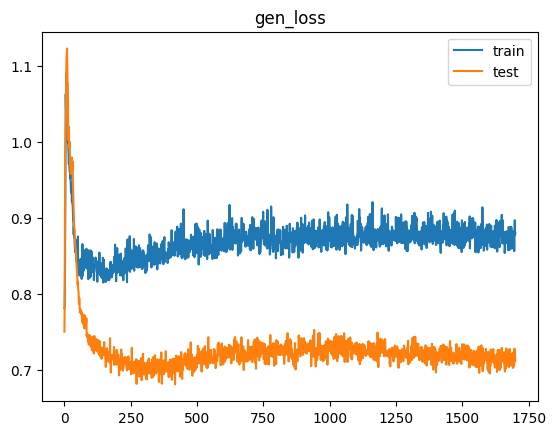

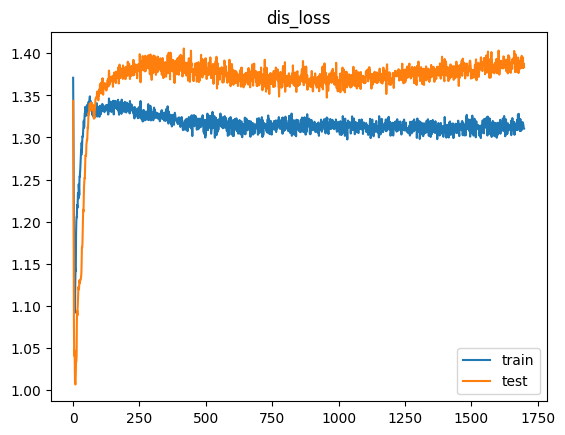

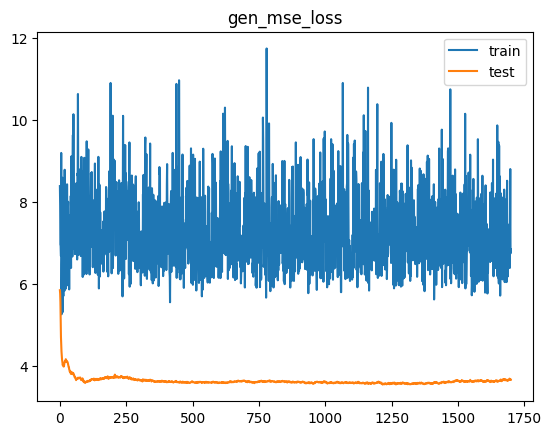

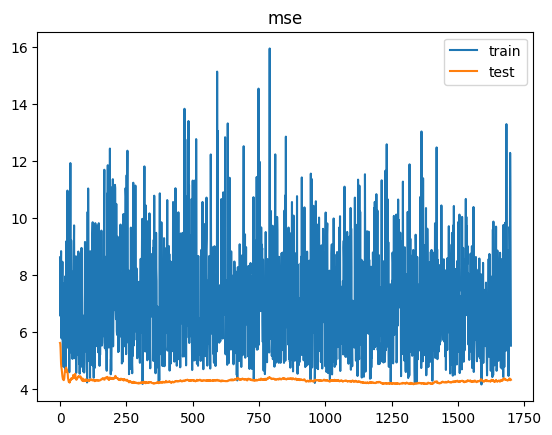

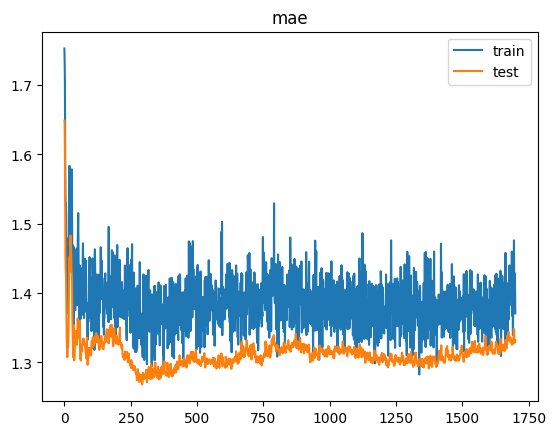

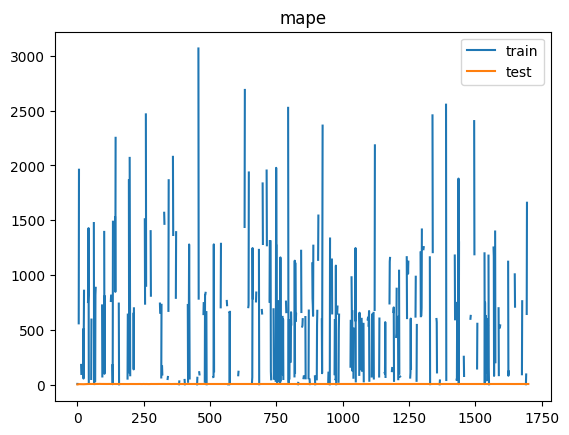

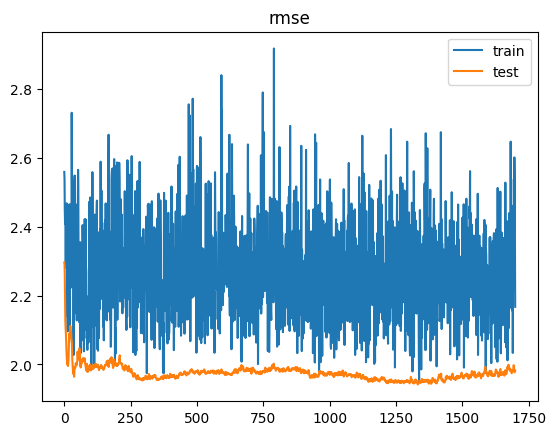

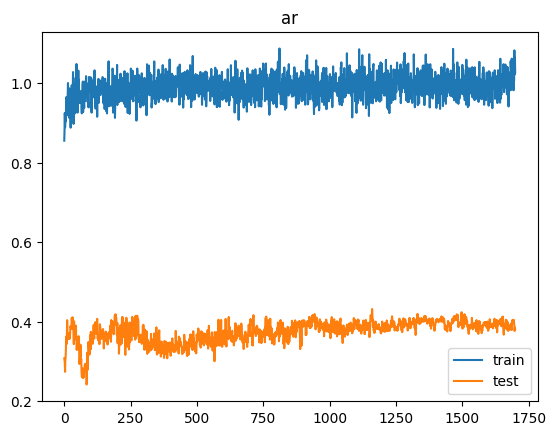

2/2 [==============================] - 1s 10ms/step


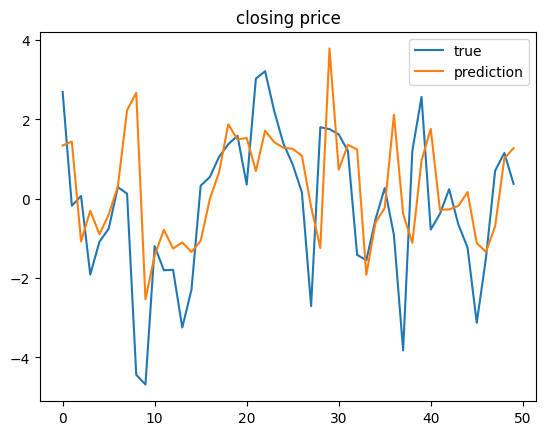

[MSE Baseline] train: 7.321519286952347  test: 4.137918162168212
Delta time with epochs = 1700: 0:59:15.280324
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_16 (Bidirectiona  (None, 5, 20)       1440        ['input_9[0][0]']                
 l)                                                                                               
                                                                                                  
 concatenate_8 (Concatenate)    (None, 5, 27)        0           ['bidirectional_16[0][0]',       
                                                                  'input_9[0][0]

Time for epoch 46 is 2.1390724182128906 sec Generator Loss: 0.8479573130607605,  Discriminator_loss: 1.3213320970535278
Time for epoch 47 is 2.066425085067749 sec Generator Loss: 0.8566871881484985,  Discriminator_loss: 1.3227754831314087
Time for epoch 48 is 2.0766029357910156 sec Generator Loss: 0.835625946521759,  Discriminator_loss: 1.329235315322876
Time for epoch 49 is 1.9324297904968262 sec Generator Loss: 0.8426468372344971,  Discriminator_loss: 1.3241709470748901
Time for epoch 50 is 1.8918235301971436 sec Generator Loss: 0.8590570688247681,  Discriminator_loss: 1.3202413320541382
Time for epoch 51 is 2.003364086151123 sec Generator Loss: 0.8330608606338501,  Discriminator_loss: 1.335035800933838
Time for epoch 52 is 1.9676182270050049 sec Generator Loss: 0.8461746573448181,  Discriminator_loss: 1.3363890647888184
Time for epoch 53 is 1.9656128883361816 sec Generator Loss: 0.840114176273346,  Discriminator_loss: 1.3314348459243774
Time for epoch 54 is 1.9640686511993408 sec Ge

Time for epoch 115 is 2.0578815937042236 sec Generator Loss: 0.8292511701583862,  Discriminator_loss: 1.3387917280197144
Time for epoch 116 is 2.0731000900268555 sec Generator Loss: 0.8133600950241089,  Discriminator_loss: 1.3464024066925049
Time for epoch 117 is 2.1358540058135986 sec Generator Loss: 0.8302732110023499,  Discriminator_loss: 1.3500869274139404
Time for epoch 118 is 2.1634786128997803 sec Generator Loss: 0.8125351071357727,  Discriminator_loss: 1.349755048751831
Time for epoch 119 is 2.315072774887085 sec Generator Loss: 0.8077626824378967,  Discriminator_loss: 1.3518427610397339
Time for epoch 120 is 2.3236660957336426 sec Generator Loss: 0.8202871084213257,  Discriminator_loss: 1.342113971710205
Time for epoch 121 is 2.094405174255371 sec Generator Loss: 0.8202217817306519,  Discriminator_loss: 1.3575787544250488
Time for epoch 122 is 2.1505792140960693 sec Generator Loss: 0.81369549036026,  Discriminator_loss: 1.3539304733276367
Time for epoch 123 is 2.37482380867004

Time for epoch 184 is 2.035712480545044 sec Generator Loss: 0.8101570010185242,  Discriminator_loss: 1.3421040773391724
Time for epoch 185 is 2.18686842918396 sec Generator Loss: 0.8258358240127563,  Discriminator_loss: 1.3440231084823608
Time for epoch 186 is 2.05134916305542 sec Generator Loss: 0.8152579069137573,  Discriminator_loss: 1.331531286239624
Time for epoch 187 is 2.090378522872925 sec Generator Loss: 0.8219424486160278,  Discriminator_loss: 1.3493174314498901
Time for epoch 188 is 2.065976619720459 sec Generator Loss: 0.8031452298164368,  Discriminator_loss: 1.3483308553695679
Time for epoch 189 is 2.0419373512268066 sec Generator Loss: 0.833672285079956,  Discriminator_loss: 1.342069149017334
Time for epoch 190 is 2.05940842628479 sec Generator Loss: 0.8176298141479492,  Discriminator_loss: 1.3443013429641724
Time for epoch 191 is 2.0166282653808594 sec Generator Loss: 0.8490514755249023,  Discriminator_loss: 1.3388277292251587
Time for epoch 192 is 2.089233636856079 sec 

Time for epoch 253 is 2.007970094680786 sec Generator Loss: 0.8281508684158325,  Discriminator_loss: 1.3278028964996338
Time for epoch 254 is 2.0456314086914062 sec Generator Loss: 0.8314489126205444,  Discriminator_loss: 1.328028678894043
Time for epoch 255 is 2.1613407135009766 sec Generator Loss: 0.8426629304885864,  Discriminator_loss: 1.3265382051467896
Time for epoch 256 is 2.0767922401428223 sec Generator Loss: 0.8470869660377502,  Discriminator_loss: 1.328878402709961
Time for epoch 257 is 2.0137104988098145 sec Generator Loss: 0.853230893611908,  Discriminator_loss: 1.3240140676498413
Time for epoch 258 is 2.187516927719116 sec Generator Loss: 0.8480648398399353,  Discriminator_loss: 1.3229544162750244
Time for epoch 259 is 2.1633546352386475 sec Generator Loss: 0.8369013667106628,  Discriminator_loss: 1.3255176544189453
Time for epoch 260 is 2.1306846141815186 sec Generator Loss: 0.8426592946052551,  Discriminator_loss: 1.3308779001235962
Time for epoch 261 is 2.1421992778778

Time for epoch 322 is 2.7519872188568115 sec Generator Loss: 0.8640233278274536,  Discriminator_loss: 1.3129279613494873
Time for epoch 323 is 2.797661304473877 sec Generator Loss: 0.8570795655250549,  Discriminator_loss: 1.319647192955017
Time for epoch 324 is 2.786876678466797 sec Generator Loss: 0.8693927526473999,  Discriminator_loss: 1.3068498373031616
Time for epoch 325 is 2.574277400970459 sec Generator Loss: 0.8590837121009827,  Discriminator_loss: 1.3163578510284424
Time for epoch 326 is 2.7823503017425537 sec Generator Loss: 0.8575654625892639,  Discriminator_loss: 1.3182023763656616
Time for epoch 327 is 2.6586976051330566 sec Generator Loss: 0.8315867781639099,  Discriminator_loss: 1.3304978609085083
Time for epoch 328 is 2.655379295349121 sec Generator Loss: 0.8414864540100098,  Discriminator_loss: 1.3231587409973145
Time for epoch 329 is 2.393842935562134 sec Generator Loss: 0.85455721616745,  Discriminator_loss: 1.3221545219421387
Time for epoch 330 is 2.277745485305786 

Time for epoch 391 is 2.364997625350952 sec Generator Loss: 0.8589159846305847,  Discriminator_loss: 1.3196961879730225
Time for epoch 392 is 2.326639175415039 sec Generator Loss: 0.8702424168586731,  Discriminator_loss: 1.3118934631347656
Time for epoch 393 is 2.3987038135528564 sec Generator Loss: 0.8622454404830933,  Discriminator_loss: 1.3197206258773804
Time for epoch 394 is 2.3384037017822266 sec Generator Loss: 0.8534843921661377,  Discriminator_loss: 1.3254393339157104
Time for epoch 395 is 2.43843674659729 sec Generator Loss: 0.8661672472953796,  Discriminator_loss: 1.3117753267288208
Time for epoch 396 is 2.322498321533203 sec Generator Loss: 0.8631744384765625,  Discriminator_loss: 1.3016266822814941
Time for epoch 397 is 2.449676036834717 sec Generator Loss: 0.8476701378822327,  Discriminator_loss: 1.3185793161392212
Time for epoch 398 is 2.356156349182129 sec Generator Loss: 0.864129364490509,  Discriminator_loss: 1.3253700733184814
Time for epoch 399 is 2.409572124481201 

Time for epoch 460 is 2.238422393798828 sec Generator Loss: 0.8884499073028564,  Discriminator_loss: 1.3132503032684326
Time for epoch 461 is 2.2599966526031494 sec Generator Loss: 0.8640730381011963,  Discriminator_loss: 1.2972372770309448
Time for epoch 462 is 2.609805107116699 sec Generator Loss: 0.8756076693534851,  Discriminator_loss: 1.3037796020507812
Time for epoch 463 is 2.250953435897827 sec Generator Loss: 0.8622700572013855,  Discriminator_loss: 1.3092706203460693
Time for epoch 464 is 2.2729403972625732 sec Generator Loss: 0.8764135837554932,  Discriminator_loss: 1.3122320175170898
Time for epoch 465 is 2.152433395385742 sec Generator Loss: 0.8626102805137634,  Discriminator_loss: 1.3182268142700195
Time for epoch 466 is 2.106062173843384 sec Generator Loss: 0.8819448947906494,  Discriminator_loss: 1.3094186782836914
Time for epoch 467 is 2.1343579292297363 sec Generator Loss: 0.8700223565101624,  Discriminator_loss: 1.309187650680542
Time for epoch 468 is 2.07275652885437

Time for epoch 529 is 2.841095209121704 sec Generator Loss: 0.8824153542518616,  Discriminator_loss: 1.308772325515747
Time for epoch 530 is 2.759972095489502 sec Generator Loss: 0.8754919171333313,  Discriminator_loss: 1.3036659955978394
Time for epoch 531 is 2.865816831588745 sec Generator Loss: 0.8559138774871826,  Discriminator_loss: 1.3124223947525024
Time for epoch 532 is 2.4994707107543945 sec Generator Loss: 0.8664976358413696,  Discriminator_loss: 1.3034765720367432
Time for epoch 533 is 2.3568766117095947 sec Generator Loss: 0.8718464374542236,  Discriminator_loss: 1.302269458770752
Time for epoch 534 is 2.437739133834839 sec Generator Loss: 0.8780996799468994,  Discriminator_loss: 1.3044581413269043
Time for epoch 535 is 2.1541037559509277 sec Generator Loss: 0.8736128807067871,  Discriminator_loss: 1.3096562623977661
Time for epoch 536 is 2.245487928390503 sec Generator Loss: 0.896024227142334,  Discriminator_loss: 1.2943885326385498
Time for epoch 537 is 2.1668293476104736

Time for epoch 598 is 2.338796854019165 sec Generator Loss: 0.8607263565063477,  Discriminator_loss: 1.3100117444992065
Time for epoch 599 is 2.336000680923462 sec Generator Loss: 0.8766648769378662,  Discriminator_loss: 1.3046116828918457
Time for epoch 600 is 2.2616915702819824 sec Generator Loss: 0.8897890448570251,  Discriminator_loss: 1.300106406211853
Time for epoch 601 is 2.1522064208984375 sec Generator Loss: 0.8700383305549622,  Discriminator_loss: 1.3070226907730103
Time for epoch 602 is 2.370051383972168 sec Generator Loss: 0.8804282546043396,  Discriminator_loss: 1.3060663938522339
Time for epoch 603 is 2.8345730304718018 sec Generator Loss: 0.8558855056762695,  Discriminator_loss: 1.31057870388031
Time for epoch 604 is 2.91206955909729 sec Generator Loss: 0.8645368218421936,  Discriminator_loss: 1.307567834854126
Time for epoch 605 is 2.7911412715911865 sec Generator Loss: 0.8572299480438232,  Discriminator_loss: 1.3156323432922363
Time for epoch 606 is 2.676264524459839 s

Time for epoch 667 is 2.9314486980438232 sec Generator Loss: 0.888765275478363,  Discriminator_loss: 1.312606692314148
Time for epoch 668 is 2.6612980365753174 sec Generator Loss: 0.8740273118019104,  Discriminator_loss: 1.3061537742614746
Time for epoch 669 is 2.6195313930511475 sec Generator Loss: 0.8618311285972595,  Discriminator_loss: 1.2958285808563232
Time for epoch 670 is 2.6511495113372803 sec Generator Loss: 0.87841796875,  Discriminator_loss: 1.3063511848449707
Time for epoch 671 is 2.6577835083007812 sec Generator Loss: 0.8818179368972778,  Discriminator_loss: 1.3067759275436401
Time for epoch 672 is 2.8060624599456787 sec Generator Loss: 0.8744933605194092,  Discriminator_loss: 1.3025447130203247
Time for epoch 673 is 3.0571579933166504 sec Generator Loss: 0.8867335915565491,  Discriminator_loss: 1.2979736328125
Time for epoch 674 is 3.1726691722869873 sec Generator Loss: 0.8762139678001404,  Discriminator_loss: 1.3076963424682617
Time for epoch 675 is 3.0579469203948975 s

Time for epoch 736 is 3.0018470287323 sec Generator Loss: 0.8551150560379028,  Discriminator_loss: 1.3140137195587158
Time for epoch 737 is 2.9142203330993652 sec Generator Loss: 0.8722236752510071,  Discriminator_loss: 1.3113596439361572
Time for epoch 738 is 3.628437042236328 sec Generator Loss: 0.8685277700424194,  Discriminator_loss: 1.3126975297927856
Time for epoch 739 is 3.526108741760254 sec Generator Loss: 0.8602166175842285,  Discriminator_loss: 1.3114677667617798
Time for epoch 740 is 3.0653505325317383 sec Generator Loss: 0.8681808114051819,  Discriminator_loss: 1.3134992122650146
Time for epoch 741 is 2.7585463523864746 sec Generator Loss: 0.8697630763053894,  Discriminator_loss: 1.2998406887054443
Time for epoch 742 is 2.7712903022766113 sec Generator Loss: 0.8851630091667175,  Discriminator_loss: 1.3142858743667603
Time for epoch 743 is 2.9611928462982178 sec Generator Loss: 0.8747928142547607,  Discriminator_loss: 1.30813729763031
Time for epoch 744 is 2.754205465316772

Time for epoch 805 is 2.714374542236328 sec Generator Loss: 0.8773409724235535,  Discriminator_loss: 1.304366946220398
Time for epoch 806 is 2.8446123600006104 sec Generator Loss: 0.8797140121459961,  Discriminator_loss: 1.3132983446121216
Time for epoch 807 is 3.1241817474365234 sec Generator Loss: 0.8574827313423157,  Discriminator_loss: 1.3135099411010742
Time for epoch 808 is 3.2728729248046875 sec Generator Loss: 0.8775359988212585,  Discriminator_loss: 1.3055484294891357
Time for epoch 809 is 3.0541343688964844 sec Generator Loss: 0.8725345134735107,  Discriminator_loss: 1.303061842918396
Time for epoch 810 is 3.097015142440796 sec Generator Loss: 0.882823646068573,  Discriminator_loss: 1.3107447624206543
Time for epoch 811 is 3.1206133365631104 sec Generator Loss: 0.8480680584907532,  Discriminator_loss: 1.3115791082382202
Time for epoch 812 is 2.979898691177368 sec Generator Loss: 0.8841177225112915,  Discriminator_loss: 1.310226559638977
Time for epoch 813 is 3.048904418945312

Time for epoch 874 is 3.334226131439209 sec Generator Loss: 0.8703877329826355,  Discriminator_loss: 1.3147389888763428
Time for epoch 875 is 3.2820849418640137 sec Generator Loss: 0.8863314390182495,  Discriminator_loss: 1.3072453737258911
Time for epoch 876 is 3.3113882541656494 sec Generator Loss: 0.8623710870742798,  Discriminator_loss: 1.3103599548339844
Time for epoch 877 is 3.2818703651428223 sec Generator Loss: 0.8632228374481201,  Discriminator_loss: 1.3059667348861694
Time for epoch 878 is 3.3152692317962646 sec Generator Loss: 0.8663864731788635,  Discriminator_loss: 1.3077863454818726
Time for epoch 879 is 3.3080759048461914 sec Generator Loss: 0.8639740943908691,  Discriminator_loss: 1.3189747333526611
Time for epoch 880 is 3.3605451583862305 sec Generator Loss: 0.875174343585968,  Discriminator_loss: 1.3065791130065918
Time for epoch 881 is 3.232448101043701 sec Generator Loss: 0.8918991088867188,  Discriminator_loss: 1.3034764528274536
Time for epoch 882 is 3.26518321037

Time for epoch 943 is 3.1450629234313965 sec Generator Loss: 0.8722531795501709,  Discriminator_loss: 1.3119235038757324
Time for epoch 944 is 3.137615442276001 sec Generator Loss: 0.8611302971839905,  Discriminator_loss: 1.3137389421463013
Time for epoch 945 is 3.204815626144409 sec Generator Loss: 0.8501786589622498,  Discriminator_loss: 1.3142831325531006
Time for epoch 946 is 3.1408965587615967 sec Generator Loss: 0.8767282962799072,  Discriminator_loss: 1.3094357252120972
Time for epoch 947 is 3.1812591552734375 sec Generator Loss: 0.8613900542259216,  Discriminator_loss: 1.3091886043548584
Time for epoch 948 is 3.1965408325195312 sec Generator Loss: 0.8767112493515015,  Discriminator_loss: 1.3063852787017822
Time for epoch 949 is 3.549149751663208 sec Generator Loss: 0.8748987913131714,  Discriminator_loss: 1.3150938749313354
Time for epoch 950 is 3.4858193397521973 sec Generator Loss: 0.8782087564468384,  Discriminator_loss: 1.306904673576355
Time for epoch 951 is 3.415195941925

Time for epoch 1012 is 3.4973509311676025 sec Generator Loss: 0.8595501184463501,  Discriminator_loss: 1.3140995502471924
Time for epoch 1013 is 3.2222065925598145 sec Generator Loss: 0.8964591026306152,  Discriminator_loss: 1.3013774156570435
Time for epoch 1014 is 3.4091217517852783 sec Generator Loss: 0.8523126244544983,  Discriminator_loss: 1.3180618286132812
Time for epoch 1015 is 3.031264305114746 sec Generator Loss: 0.8647396564483643,  Discriminator_loss: 1.309362530708313
Time for epoch 1016 is 2.945783853530884 sec Generator Loss: 0.8628473877906799,  Discriminator_loss: 1.3190999031066895
Time for epoch 1017 is 3.0938868522644043 sec Generator Loss: 0.8669611811637878,  Discriminator_loss: 1.317318081855774
Time for epoch 1018 is 3.0077106952667236 sec Generator Loss: 0.8993078470230103,  Discriminator_loss: 1.313955545425415
Time for epoch 1019 is 3.3167312145233154 sec Generator Loss: 0.873550534248352,  Discriminator_loss: 1.314730167388916
Time for epoch 1020 is 3.382451

Time for epoch 1080 is 3.175373077392578 sec Generator Loss: 0.8845317959785461,  Discriminator_loss: 1.3140959739685059
Time for epoch 1081 is 3.1323280334472656 sec Generator Loss: 0.8662679195404053,  Discriminator_loss: 1.3161718845367432
Time for epoch 1082 is 3.4914159774780273 sec Generator Loss: 0.8607590794563293,  Discriminator_loss: 1.3174229860305786
Time for epoch 1083 is 3.6958696842193604 sec Generator Loss: 0.8503603339195251,  Discriminator_loss: 1.3191968202590942
Time for epoch 1084 is 3.6400210857391357 sec Generator Loss: 0.8568915724754333,  Discriminator_loss: 1.3170053958892822
Time for epoch 1085 is 3.5852813720703125 sec Generator Loss: 0.8588463068008423,  Discriminator_loss: 1.3088905811309814
Time for epoch 1086 is 3.5765514373779297 sec Generator Loss: 0.8552230596542358,  Discriminator_loss: 1.3121967315673828
Time for epoch 1087 is 3.5275657176971436 sec Generator Loss: 0.8618035912513733,  Discriminator_loss: 1.3089085817337036
Time for epoch 1088 is 3.

Time for epoch 1148 is 3.326777935028076 sec Generator Loss: 0.8554589748382568,  Discriminator_loss: 1.3104846477508545
Time for epoch 1149 is 3.4908759593963623 sec Generator Loss: 0.8635318279266357,  Discriminator_loss: 1.3091257810592651
Time for epoch 1150 is 3.026207685470581 sec Generator Loss: 0.8557291030883789,  Discriminator_loss: 1.3201494216918945
Time for epoch 1151 is 2.816894054412842 sec Generator Loss: 0.8657585978507996,  Discriminator_loss: 1.3150601387023926
Time for epoch 1152 is 2.888007164001465 sec Generator Loss: 0.8921245336532593,  Discriminator_loss: 1.3047866821289062
Time for epoch 1153 is 2.7899181842803955 sec Generator Loss: 0.8655403852462769,  Discriminator_loss: 1.3226157426834106
Time for epoch 1154 is 2.8778445720672607 sec Generator Loss: 0.8469710350036621,  Discriminator_loss: 1.317124366760254
Time for epoch 1155 is 2.8320577144622803 sec Generator Loss: 0.8552693724632263,  Discriminator_loss: 1.3167204856872559
Time for epoch 1156 is 2.9466

Time for epoch 1216 is 3.4552810192108154 sec Generator Loss: 0.8663851618766785,  Discriminator_loss: 1.3125216960906982
Time for epoch 1217 is 3.3884217739105225 sec Generator Loss: 0.8619691729545593,  Discriminator_loss: 1.3142386674880981
Time for epoch 1218 is 3.3362274169921875 sec Generator Loss: 0.860142707824707,  Discriminator_loss: 1.3189109563827515
Time for epoch 1219 is 3.6855807304382324 sec Generator Loss: 0.8542495369911194,  Discriminator_loss: 1.3239941596984863
Time for epoch 1220 is 3.349210739135742 sec Generator Loss: 0.8667086362838745,  Discriminator_loss: 1.3164103031158447
Time for epoch 1221 is 3.22236704826355 sec Generator Loss: 0.879618763923645,  Discriminator_loss: 1.3131307363510132
Time for epoch 1222 is 3.185688018798828 sec Generator Loss: 0.8791283369064331,  Discriminator_loss: 1.3074491024017334
Time for epoch 1223 is 3.3992068767547607 sec Generator Loss: 0.8606658577919006,  Discriminator_loss: 1.3092397451400757
Time for epoch 1224 is 3.43735

Time for epoch 1284 is 3.855469226837158 sec Generator Loss: 0.8661227822303772,  Discriminator_loss: 1.3164175748825073
Time for epoch 1285 is 3.677528142929077 sec Generator Loss: 0.8610484004020691,  Discriminator_loss: 1.3122062683105469
Time for epoch 1286 is 3.6653146743774414 sec Generator Loss: 0.8480738997459412,  Discriminator_loss: 1.32831871509552
Time for epoch 1287 is 3.5764756202697754 sec Generator Loss: 0.8576340079307556,  Discriminator_loss: 1.3113279342651367
Time for epoch 1288 is 3.6582281589508057 sec Generator Loss: 0.8615691065788269,  Discriminator_loss: 1.3175270557403564
Time for epoch 1289 is 3.5343902111053467 sec Generator Loss: 0.8692483901977539,  Discriminator_loss: 1.3140794038772583
Time for epoch 1290 is 3.5486207008361816 sec Generator Loss: 0.8782536387443542,  Discriminator_loss: 1.312591552734375
Time for epoch 1291 is 3.3592758178710938 sec Generator Loss: 0.8757069706916809,  Discriminator_loss: 1.3086401224136353
Time for epoch 1292 is 3.3213

Time for epoch 1352 is 3.4081506729125977 sec Generator Loss: 0.8548006415367126,  Discriminator_loss: 1.3174539804458618
Time for epoch 1353 is 3.49396014213562 sec Generator Loss: 0.876248300075531,  Discriminator_loss: 1.3236678838729858
Time for epoch 1354 is 3.5705196857452393 sec Generator Loss: 0.8634645938873291,  Discriminator_loss: 1.3154292106628418
Time for epoch 1355 is 3.716961622238159 sec Generator Loss: 0.8708521127700806,  Discriminator_loss: 1.3108117580413818
Time for epoch 1356 is 3.638171911239624 sec Generator Loss: 0.896630048751831,  Discriminator_loss: 1.3088130950927734
Time for epoch 1357 is 3.6017723083496094 sec Generator Loss: 0.8647754192352295,  Discriminator_loss: 1.3188362121582031
Time for epoch 1358 is 3.7373061180114746 sec Generator Loss: 0.864895761013031,  Discriminator_loss: 1.3139982223510742
Time for epoch 1359 is 3.587294578552246 sec Generator Loss: 0.8544926643371582,  Discriminator_loss: 1.3188592195510864
Time for epoch 1360 is 3.5380268

Time for epoch 1420 is 3.040041923522949 sec Generator Loss: 0.8672044277191162,  Discriminator_loss: 1.320438027381897
Time for epoch 1421 is 3.038386344909668 sec Generator Loss: 0.8914432525634766,  Discriminator_loss: 1.303915023803711
Time for epoch 1422 is 3.126105308532715 sec Generator Loss: 0.8731070160865784,  Discriminator_loss: 1.3148356676101685
Time for epoch 1423 is 3.781345844268799 sec Generator Loss: 0.8651184439659119,  Discriminator_loss: 1.3162950277328491
Time for epoch 1424 is 3.8365581035614014 sec Generator Loss: 0.8756989240646362,  Discriminator_loss: 1.3145374059677124
Time for epoch 1425 is 3.9841878414154053 sec Generator Loss: 0.871077835559845,  Discriminator_loss: 1.3242926597595215
Time for epoch 1426 is 3.2815704345703125 sec Generator Loss: 0.862377941608429,  Discriminator_loss: 1.3202813863754272
Time for epoch 1427 is 3.2278950214385986 sec Generator Loss: 0.8551536798477173,  Discriminator_loss: 1.316919207572937
Time for epoch 1428 is 3.48256921

Time for epoch 1488 is 3.267009973526001 sec Generator Loss: 0.8738687038421631,  Discriminator_loss: 1.3166676759719849
Time for epoch 1489 is 3.2429044246673584 sec Generator Loss: 0.8848013877868652,  Discriminator_loss: 1.3156569004058838
Time for epoch 1490 is 3.1843295097351074 sec Generator Loss: 0.875557005405426,  Discriminator_loss: 1.3066047430038452
Time for epoch 1491 is 3.1944820880889893 sec Generator Loss: 0.8753113746643066,  Discriminator_loss: 1.3130806684494019
Time for epoch 1492 is 3.2196695804595947 sec Generator Loss: 0.8663672804832458,  Discriminator_loss: 1.3121867179870605
Time for epoch 1493 is 3.254795551300049 sec Generator Loss: 0.8778570890426636,  Discriminator_loss: 1.311112642288208
Time for epoch 1494 is 3.2143094539642334 sec Generator Loss: 0.8637733459472656,  Discriminator_loss: 1.3123263120651245
Time for epoch 1495 is 3.3867807388305664 sec Generator Loss: 0.8727658987045288,  Discriminator_loss: 1.3026047945022583
Time for epoch 1496 is 3.525

Time for epoch 1556 is 3.2255303859710693 sec Generator Loss: 0.8717747926712036,  Discriminator_loss: 1.306921124458313
Time for epoch 1557 is 3.216287612915039 sec Generator Loss: 0.8638689517974854,  Discriminator_loss: 1.316400408744812
Time for epoch 1558 is 3.228241443634033 sec Generator Loss: 0.8417236804962158,  Discriminator_loss: 1.312846064567566
Time for epoch 1559 is 3.1622262001037598 sec Generator Loss: 0.8732091784477234,  Discriminator_loss: 1.3097447156906128
Time for epoch 1560 is 3.2244651317596436 sec Generator Loss: 0.8701215982437134,  Discriminator_loss: 1.3058005571365356
Time for epoch 1561 is 3.204934597015381 sec Generator Loss: 0.8668344020843506,  Discriminator_loss: 1.3087941408157349
Time for epoch 1562 is 3.116725206375122 sec Generator Loss: 0.8718437552452087,  Discriminator_loss: 1.3170138597488403
Time for epoch 1563 is 3.2991716861724854 sec Generator Loss: 0.876474916934967,  Discriminator_loss: 1.3142871856689453
Time for epoch 1564 is 3.1220719

Time for epoch 1624 is 3.4267098903656006 sec Generator Loss: 0.8785468935966492,  Discriminator_loss: 1.314710021018982
Time for epoch 1625 is 3.254204273223877 sec Generator Loss: 0.856268048286438,  Discriminator_loss: 1.3187810182571411
Time for epoch 1626 is 3.3084113597869873 sec Generator Loss: 0.8901910781860352,  Discriminator_loss: 1.312150239944458
Time for epoch 1627 is 3.1718122959136963 sec Generator Loss: 0.8869407773017883,  Discriminator_loss: 1.316707968711853
Time for epoch 1628 is 3.136638641357422 sec Generator Loss: 0.8660064339637756,  Discriminator_loss: 1.3097000122070312
Time for epoch 1629 is 3.144975423812866 sec Generator Loss: 0.8454398512840271,  Discriminator_loss: 1.3268293142318726
Time for epoch 1630 is 3.0019962787628174 sec Generator Loss: 0.8654661178588867,  Discriminator_loss: 1.30665922164917
Time for epoch 1631 is 3.0808045864105225 sec Generator Loss: 0.8676238656044006,  Discriminator_loss: 1.3136944770812988
Time for epoch 1632 is 2.98108649

Time for epoch 1692 is 3.3049256801605225 sec Generator Loss: 0.8617222309112549,  Discriminator_loss: 1.3172693252563477
Time for epoch 1693 is 3.169893503189087 sec Generator Loss: 0.8695829510688782,  Discriminator_loss: 1.312749981880188
Time for epoch 1694 is 3.2834088802337646 sec Generator Loss: 0.8700138330459595,  Discriminator_loss: 1.3145008087158203
Time for epoch 1695 is 3.0131595134735107 sec Generator Loss: 0.8775864839553833,  Discriminator_loss: 1.3152358531951904
Time for epoch 1696 is 3.387712001800537 sec Generator Loss: 0.8477576971054077,  Discriminator_loss: 1.3170137405395508
Time for epoch 1697 is 3.1760077476501465 sec Generator Loss: 0.8972711563110352,  Discriminator_loss: 1.3071770668029785
Time for epoch 1698 is 2.995670795440674 sec Generator Loss: 0.8789938688278198,  Discriminator_loss: 1.3131881952285767
Time for epoch 1699 is 3.1273162364959717 sec Generator Loss: 0.8723445534706116,  Discriminator_loss: 1.3047086000442505
Time for epoch 1700 is 3.093

Time for epoch 1760 is 3.4317898750305176 sec Generator Loss: 0.8593295812606812,  Discriminator_loss: 1.3261624574661255
Time for epoch 1761 is 3.4175257682800293 sec Generator Loss: 0.8665587902069092,  Discriminator_loss: 1.3070192337036133
Time for epoch 1762 is 3.692281484603882 sec Generator Loss: 0.8740771412849426,  Discriminator_loss: 1.3162118196487427
Time for epoch 1763 is 3.5564348697662354 sec Generator Loss: 0.8697115778923035,  Discriminator_loss: 1.3125195503234863
Time for epoch 1764 is 3.6637392044067383 sec Generator Loss: 0.869207501411438,  Discriminator_loss: 1.3129489421844482
Time for epoch 1765 is 3.2804930210113525 sec Generator Loss: 0.868162989616394,  Discriminator_loss: 1.312414526939392
Time for epoch 1766 is 3.3382275104522705 sec Generator Loss: 0.8674911856651306,  Discriminator_loss: 1.3118318319320679
Time for epoch 1767 is 3.5224874019622803 sec Generator Loss: 0.880921483039856,  Discriminator_loss: 1.3125362396240234
Time for epoch 1768 is 3.4330

Time for epoch 1828 is 3.4447896480560303 sec Generator Loss: 0.8802523612976074,  Discriminator_loss: 1.3277424573898315
Time for epoch 1829 is 3.8175723552703857 sec Generator Loss: 0.8600562214851379,  Discriminator_loss: 1.306549072265625
Time for epoch 1830 is 3.683130979537964 sec Generator Loss: 0.8716479539871216,  Discriminator_loss: 1.3201727867126465
Time for epoch 1831 is 3.5637447834014893 sec Generator Loss: 0.8773476481437683,  Discriminator_loss: 1.30690336227417
Time for epoch 1832 is 3.5654172897338867 sec Generator Loss: 0.8802054524421692,  Discriminator_loss: 1.313072919845581
Time for epoch 1833 is 3.515085458755493 sec Generator Loss: 0.8670772910118103,  Discriminator_loss: 1.3120951652526855
Time for epoch 1834 is 3.6910035610198975 sec Generator Loss: 0.8514730930328369,  Discriminator_loss: 1.3125213384628296
Time for epoch 1835 is 3.3457632064819336 sec Generator Loss: 0.8718193173408508,  Discriminator_loss: 1.3114567995071411
Time for epoch 1836 is 3.36416

Time for epoch 1896 is 3.5436370372772217 sec Generator Loss: 0.8692233562469482,  Discriminator_loss: 1.31294846534729
Time for epoch 1897 is 4.7136149406433105 sec Generator Loss: 0.8549016714096069,  Discriminator_loss: 1.316720724105835
Time for epoch 1898 is 4.792638540267944 sec Generator Loss: 0.8855295181274414,  Discriminator_loss: 1.3121025562286377
Time for epoch 1899 is 4.563892602920532 sec Generator Loss: 0.8583967089653015,  Discriminator_loss: 1.3169173002243042
Time for epoch 1900 is 4.790469408035278 sec Generator Loss: 0.8566619753837585,  Discriminator_loss: 1.3165439367294312
Time for epoch 1901 is 4.339192152023315 sec Generator Loss: 0.8765468597412109,  Discriminator_loss: 1.3189988136291504
Time for epoch 1902 is 4.3524010181427 sec Generator Loss: 0.8732359409332275,  Discriminator_loss: 1.3106608390808105
Time for epoch 1903 is 4.423276901245117 sec Generator Loss: 0.8709652423858643,  Discriminator_loss: 1.3180025815963745
Time for epoch 1904 is 4.5153493881

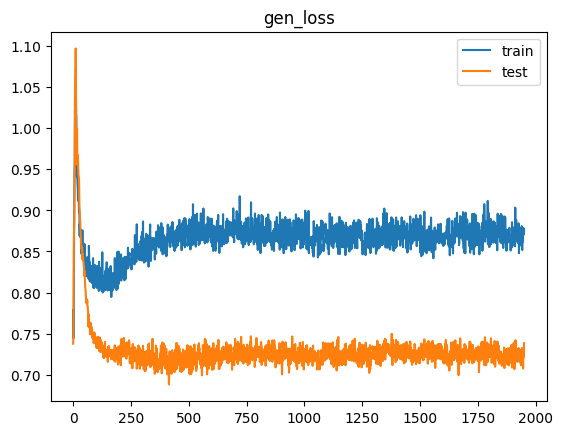

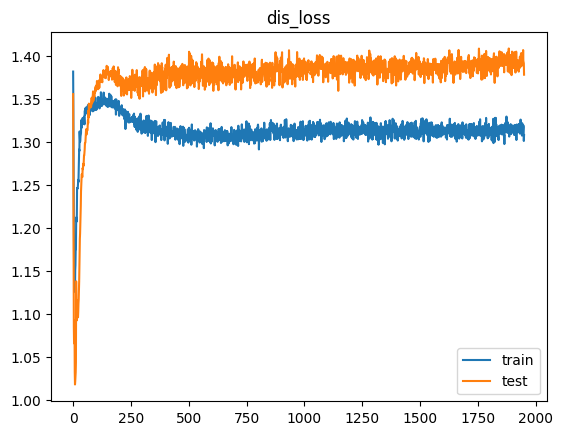

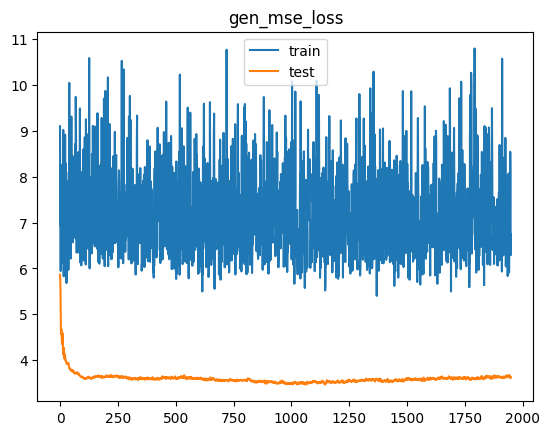

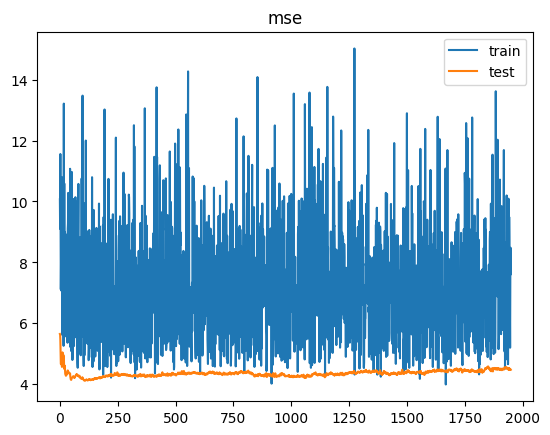

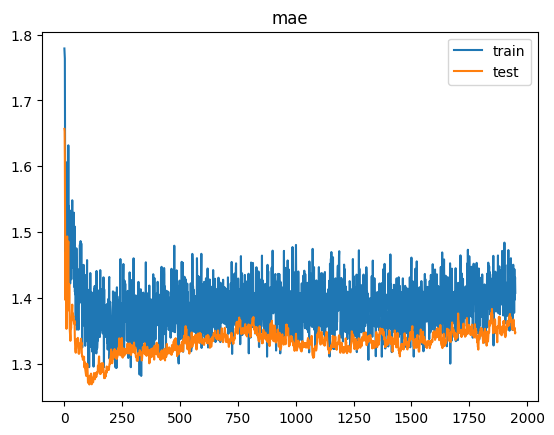

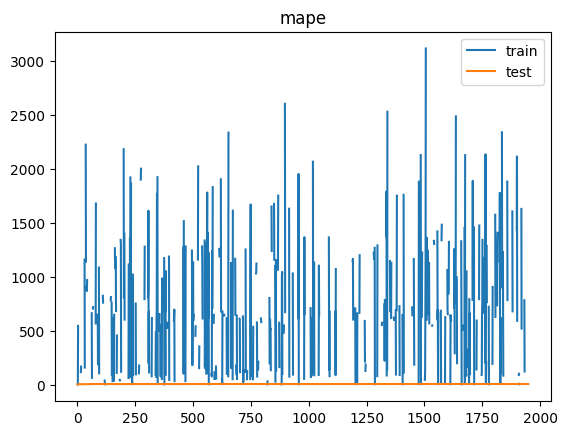

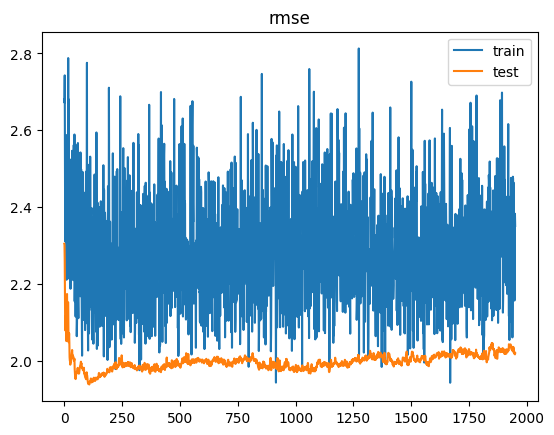

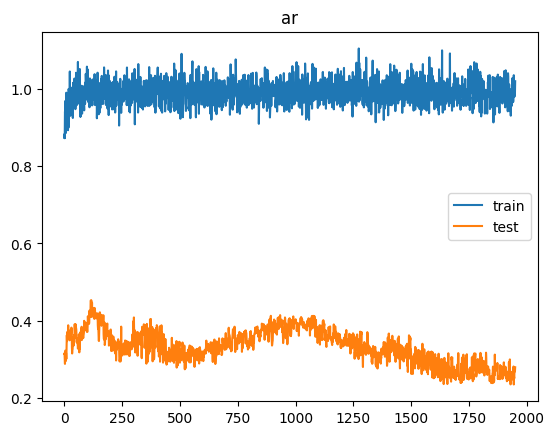

2/2 [==============================] - 1s 12ms/step


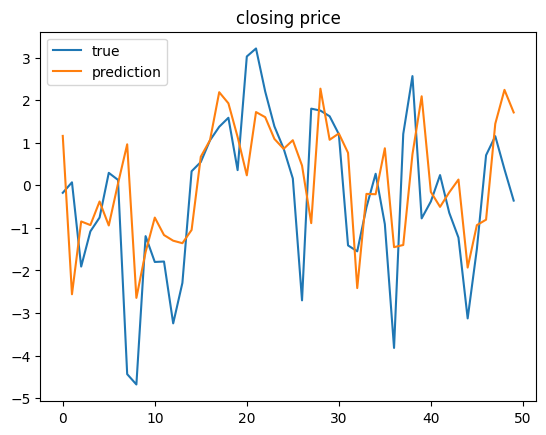

[MSE Baseline] train: 6.37602911504245  test: 4.1521541466081695
Delta time with epochs = 1950: 1:37:06.198640


In [40]:
for epochs in [1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("dcbilstm_ffnn_epochs_{0}.h5".format(epochs))